In [1]:
#!pip install tensorflow


In [140]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences   
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Activation, Input, Bidirectional,SimpleRNN, Embedding, Conv1D, LSTM, MaxPooling1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split



from nltk.stem import PorterStemmer
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns

print(tf.__version__)


2.8.0


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HARYS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HARYS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
#!pip install emot

In [4]:
from __future__ import unicode_literals
import csv
from io import open

# Import the datatset
#data = pd.read_csv('C:/Users/HARYS/OneDrive/Documents/senego/twitter/twittertwo/twitterdatacomb2trans.csv', encoding = "UTF-8")
data = pd.read_excel('C:/Users/HARYS/OneDrive/Documents/senego/facebook/facebookthree/facebook3.xlsx', sheet_name='Sheet1')
columns = ['score', 'textr'] 
dataset = pd.DataFrame(data, columns=columns)
#dataset = dataset[col]

# Drop rows with missing labels
dataset.dropna(subset=["textr"], inplace=True)

# Rename column
dataset.columns=['Product', 'ConsumerComplaint'] 

# Only include the following products
dataset=dataset[dataset['Product'].isin(['poverty', 
                                         'hunger', 
                                         'covid',
                                         'neutral'])]

#dataset["ConsumerComplaint"] = dataset["ConsumerComplaint"].apply(convert_emoji).apply(convert_emoticons)

# Print the top
dataset.head()


,Product,ConsumerComplaint
0,poverty,8 Years of Modi Government: '12 percent people...
1,poverty,I WAS AN ASHAWO before I meant. Chief veto\n...
2,poverty,We have enter new month I WAS AN ASHAWO BEFORE...
3,poverty,Hello all; I have a friend in Cameroon Africa ...
4,poverty,���������I WAS AN ASHAWO before I meant. Chief...


In [5]:
import neattext as nt
import neattext.functions as nfx
#pd.DataFrame(dataset.Product.unique())

In [6]:
dataset['ConsumerComplaint'].apply(lambda x : nt.TextFrame(x).noise_scan()['text_noise'])

0        8.910891
1       12.336449
2       12.199037
3       12.149336
4       12.211838
          ...    
4047    13.899614
4048     7.861272
4049    11.267606
4050     9.415584
4051    12.749004
Name: ConsumerComplaint, Length: 4048, dtype: float64

In [7]:
dataset['clean_text']=dataset['ConsumerComplaint'].apply(nfx.remove_userhandles)

In [8]:
dataset['clean_text'].apply(nfx.remove_hashtags)

0       8 Years of Modi Government: '12 percent people...
1       I WAS AN ASHAWO  before I  meant. Chief veto\n...
2       We have enter new month I WAS AN ASHAWO BEFORE...
3       Hello all; I have a friend in Cameroon Africa ...
4       ���������I WAS AN ASHAWO before I meant. Chief...
                              ...                        
4047    How to Hunger for God How to Hunger for God\nG...
4048    Herbal Appetite Suppressant Pills Are Now Intr...
4049    PCOS and Hunger Women with PCOS have disordere...
4050    Trailer for Pierre: Senegal to Brooklyn We're ...
4051    Six Ways to Control Appetite -- Herbalife Peop...
Name: clean_text, Length: 4048, dtype: object

In [9]:
dataset['hashtags'] = dataset['clean_text'].apply(lambda x: nfx.remove_custom_pattern(x,term_pattern=r'&#\S+'))
dataset['hashtags'].head(2)

0    8 Years of Modi Government: '12 percent people...
1    I WAS AN ASHAWO  before I  meant. Chief veto\n...
Name: hashtags, dtype: object

In [10]:
dataset['special'] = dataset['hashtags'].apply(nfx.remove_special_characters)
dataset['special'].head()

0    8 Years of Modi Government 12 percent people h...
1    I WAS AN ASHAWO  before I  meant Chief vetopos...
2    We have enter new month I WAS AN ASHAWO BEFORE...
3    Hello all I have a friend in Cameroon Africa w...
4    I WAS AN ASHAWO before I meant Chief ogidigan ...
Name: special, dtype: object

In [11]:
dataset['space']= dataset['special'].apply(nfx.remove_multiple_spaces)
dataset['space'].head()

0    8 Years of Modi Government 12 percent people h...
1    I WAS AN ASHAWO before I meant Chief vetopost ...
2    We have enter new month I WAS AN ASHAWO BEFORE...
3    Hello all I have a friend in Cameroon Africa w...
4    I WAS AN ASHAWO before I meant Chief ogidigan ...
Name: space, dtype: object

In [12]:
# Extarct stopwords
dataset['space'].apply(lambda x: nt.TextExtractor(x).extract_stopwords())

0       [of, have, been, out, of, the, of, have, been,...
1       [i, was, an, before, i, on, was, the, one, tha...
2       [we, have, i, was, an, before, i, a, of, mine,...
3       [all, i, have, a, in, who, a, to, in, out, to,...
4       [i, was, an, before, i, on, he, was, the, one,...
                              ...                        
4047    [how, to, for, how, to, for, us, that, if, we,...
4048    [are, now, in, you, can, more, at, in, this, w...
4049    [and, with, have, and, but, there, are, that, ...
4050    [for, to, were, to, an, of, our, to, this, is,...
4051    [six, to, who, are, to, their, say, they, all,...
Name: space, Length: 4048, dtype: object

In [13]:
#Remove stopwords
#Method one using Textfame
dataset['stop']= dataset['space'].apply(lambda x: nt.TextFrame(x).remove_stopwords())
dataset['stop'].head()

0    8 Years Modi Government 12 percent people take...
1    ASHAWO meant Chief vetopost Facebook 070185428...
2    enter new month ASHAWO PROSTITUTIONUntil meant...
3    Hello friend Cameroon Africa runs program tryi...
4    ASHAWO meant Chief ogidigan post Facebook23481...
Name: stop, dtype: object

In [14]:
# remove stopwords
#Method 2 using neattext
dataset['stop2']=dataset['space'].apply(nfx.remove_stopwords)
dataset['stop2'].head()

0    8 Years Modi Government 12 percent people take...
1    ASHAWO meant Chief vetopost Facebook 070185428...
2    enter new month ASHAWO PROSTITUTIONUntil meant...
3    Hello friend Cameroon Africa runs program tryi...
4    ASHAWO meant Chief ogidigan post Facebook23481...
Name: stop2, dtype: object

In [15]:
dataset['stop2'].apply(lambda x: nt.TextFrame(x).noise_scan()['text_noise'])

0       0
1       0
2       0
3       0
4       0
       ..
4047    0
4048    0
4049    0
4050    0
4051    0
Name: stop2, Length: 4048, dtype: int64

In [16]:

#pd.DataFrame(dataset.Product.unique())

dataset.rename(columns={'ConsumerComplaint': 'ConsumerComplaint1', 'stop2': 'ConsumerComplaint'}, inplace=True)

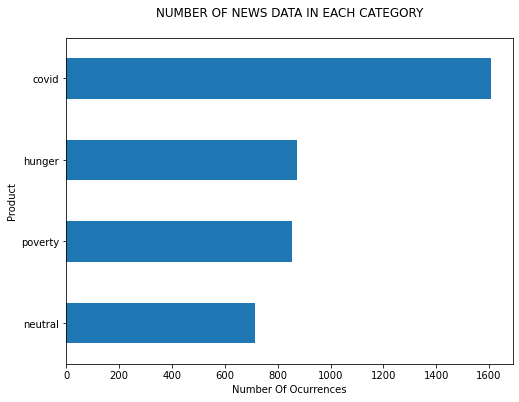

In [17]:
# The bar chart to show the number of news per category
fig = plt.figure(figsize=(8,6))
dataset.groupby('Product').ConsumerComplaint.count().sort_values().plot.barh(
    ylim=0, title= 'NUMBER OF NEWS DATA IN EACH CATEGORY\n')
plt.xlabel('Number Of Ocurrences', fontsize = 10);
plt.savefig('category_graph.png', bbox_inches='tight')

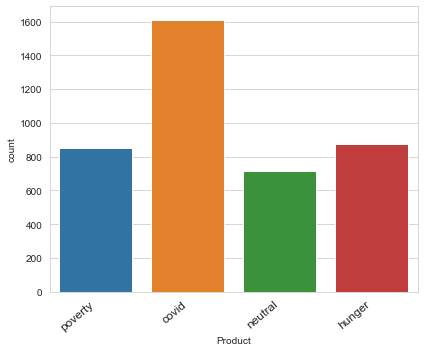

In [18]:
sns.set_style('whitegrid')
plt.figure(figsize=(6, 5))
ax = sns.countplot(x='Product', data=dataset)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

In [19]:
#!pip install emoji


In [20]:
EMOTICONS = {
    u":‑\)":"Happy face or smiley",
    u":\)":"Happy face or smiley",
    u":-\]":"Happy face or smiley",
    u":\]":"Happy face or smiley",
    u":-3":"Happy face smiley",
    u":3":"Happy face smiley",
    u":->":"Happy face smiley",
    u":>":"Happy face smiley",
    u"8-\)":"Happy face smiley",
    u":o\)":"Happy face smiley",
    u":-\}":"Happy face smiley",
    u":\}":"Happy face smiley",
    u":-\)":"Happy face smiley",
    u":c\)":"Happy face smiley",
    u":\^\)":"Happy face smiley",
    u"=\]":"Happy face smiley",
    u"=\)":"Happy face smiley",
    u":‑D":"Laughing, big grin or laugh with glasses",
    u":D":"Laughing, big grin or laugh with glasses",
    u"8‑D":"Laughing, big grin or laugh with glasses",
    u"8D":"Laughing, big grin or laugh with glasses",
    u"X‑D":"Laughing, big grin or laugh with glasses",
    u"XD":"Laughing, big grin or laugh with glasses",
    u"=D":"Laughing, big grin or laugh with glasses",
    u"=3":"Laughing, big grin or laugh with glasses",
    u"B\^D":"Laughing, big grin or laugh with glasses",
    u":-\)\)":"Very happy",
    u":‑\(":"Frown, sad, andry or pouting",
    u":-\(":"Frown, sad, andry or pouting",
    u":\(":"Frown, sad, andry or pouting",
    u":‑c":"Frown, sad, andry or pouting",
    u":c":"Frown, sad, andry or pouting",
    u":‑<":"Frown, sad, andry or pouting",
    u":<":"Frown, sad, andry or pouting",
    u":‑\[":"Frown, sad, andry or pouting",
    u":\[":"Frown, sad, andry or pouting",
    u":-\|\|":"Frown, sad, andry or pouting",
    u">:\[":"Frown, sad, andry or pouting",
    u":\{":"Frown, sad, andry or pouting",
    u":@":"Frown, sad, andry or pouting",
    u">:\(":"Frown, sad, andry or pouting",
    u":'‑\(":"Crying",
    u":'\(":"Crying",
    u":'‑\)":"Tears of happiness",
    u":'\)":"Tears of happiness",
    u"D‑':":"Horror",
    u"D:<":"Disgust",
    u"D:":"Sadness",
    u"D8":"Great dismay",
    u"D;":"Great dismay",
    u"D=":"Great dismay",
    u"DX":"Great dismay",
    u":‑O":"Surprise",
    u":O":"Surprise",
    u":‑o":"Surprise",
    u":o":"Surprise",
    u":-0":"Shock",
    u"8‑0":"Yawn",
    u">:O":"Yawn",
    u":-\*":"Kiss",
    u":\*":"Kiss",
    u":X":"Kiss",
    u";‑\)":"Wink or smirk",
    u";\)":"Wink or smirk",
    u"\*-\)":"Wink or smirk",
    u"\*\)":"Wink or smirk",
    u";‑\]":"Wink or smirk",
    u";\]":"Wink or smirk",
    u";\^\)":"Wink or smirk",
    u":‑,":"Wink or smirk",
    u";D":"Wink or smirk",
    u":‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"X‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"XP":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"d:":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"=p":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u">:P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":-[.]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":S":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":‑\|":"Straight face",
    u":\|":"Straight face",
    u":$":"Embarrassed or blushing",
    u":‑x":"Sealed lips or wearing braces or tongue-tied",
    u":x":"Sealed lips or wearing braces or tongue-tied",
    u":‑#":"Sealed lips or wearing braces or tongue-tied",
    u":#":"Sealed lips or wearing braces or tongue-tied",
    u":‑&":"Sealed lips or wearing braces or tongue-tied",
    u":&":"Sealed lips or wearing braces or tongue-tied",
    u"O:‑\)":"Angel, saint or innocent",
    u"O:\)":"Angel, saint or innocent",
    u"0:‑3":"Angel, saint or innocent",
    u"0:3":"Angel, saint or innocent",
    u"0:‑\)":"Angel, saint or innocent",
    u"0:\)":"Angel, saint or innocent",
    u":‑b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"0;\^\)":"Angel, saint or innocent",
    u">:‑\)":"Evil or devilish",
    u">:\)":"Evil or devilish",
    u"\}:‑\)":"Evil or devilish",
    u"\}:\)":"Evil or devilish",
    u"3:‑\)":"Evil or devilish",
    u"3:\)":"Evil or devilish",
    u">;\)":"Evil or devilish",
    u"\|;‑\)":"Cool",
    u"\|‑O":"Bored",
    u":‑J":"Tongue-in-cheek",
    u"#‑\)":"Party all night",
    u"%‑\)":"Drunk or confused",
    u"%\)":"Drunk or confused",
    u":-###..":"Being sick",
    u":###..":"Being sick",
    u"<:‑\|":"Dump",
    u"\(>_<\)":"Troubled",
    u"\(>_<\)>":"Troubled",
    u"\(';'\)":"Baby",
    u"\(\^\^>``":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(\^_\^;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(~_~;\) \(・\.・;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-\)zzz":"Sleeping",
    u"\(\^_-\)":"Wink",
    u"\(\(\+_\+\)\)":"Confused",
    u"\(\+o\+\)":"Confused",
    u"\(o\|o\)":"Ultraman",
    u"\^_\^":"Joyful",
    u"\(\^_\^\)/":"Joyful",
    u"\(\^O\^\)／":"Joyful",
    u"\(\^o\^\)／":"Joyful",
    u"\(__\)":"Kowtow as a sign of respect, or dogeza for apology",
    u"_\(\._\.\)_":"Kowtow as a sign of respect, or dogeza for apology",
    u"<\(_ _\)>":"Kowtow as a sign of respect, or dogeza for apology",
    u"<m\(__\)m>":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(__\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(_ _\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"\('_'\)":"Sad or Crying",
    u"\(/_;\)":"Sad or Crying",
    u"\(T_T\) \(;_;\)":"Sad or Crying",
    u"\(;_;":"Sad of Crying",
    u"\(;_:\)":"Sad or Crying",
    u"\(;O;\)":"Sad or Crying",
    u"\(:_;\)":"Sad or Crying",
    u"\(ToT\)":"Sad or Crying",
    u";_;":"Sad or Crying",
    u";-;":"Sad or Crying",
    u";n;":"Sad or Crying",
    u";;":"Sad or Crying",
    u"Q\.Q":"Sad or Crying",
    u"T\.T":"Sad or Crying",
    u"QQ":"Sad or Crying",
    u"Q_Q":"Sad or Crying",
    u"\(-\.-\)":"Shame",
    u"\(-_-\)":"Shame",
    u"\(一一\)":"Shame",
    u"\(；一_一\)":"Shame",
    u"\(=_=\)":"Tired",
    u"\(=\^\·\^=\)":"cat",
    u"\(=\^\·\·\^=\)":"cat",
    u"=_\^=	":"cat",
    u"\(\.\.\)":"Looking down",
    u"\(\._\.\)":"Looking down",
    u"\^m\^":"Giggling with hand covering mouth",
    u"\(\・\・?":"Confusion",
    u"\(?_?\)":"Confusion",
    u">\^_\^<":"Normal Laugh",
    u"<\^!\^>":"Normal Laugh",
    u"\^/\^":"Normal Laugh",
    u"\（\*\^_\^\*）" :"Normal Laugh",
    u"\(\^<\^\) \(\^\.\^\)":"Normal Laugh",
    u"\(^\^\)":"Normal Laugh",
    u"\(\^\.\^\)":"Normal Laugh",
    u"\(\^_\^\.\)":"Normal Laugh",
    u"\(\^_\^\)":"Normal Laugh",
    u"\(\^\^\)":"Normal Laugh",
    u"\(\^J\^\)":"Normal Laugh",
    u"\(\*\^\.\^\*\)":"Normal Laugh",
    u"\(\^—\^\）":"Normal Laugh",
    u"\(#\^\.\^#\)":"Normal Laugh",
    u"\（\^—\^\）":"Waving",
    u"\(;_;\)/~~~":"Waving",
    u"\(\^\.\^\)/~~~":"Waving",
    u"\(-_-\)/~~~ \($\·\·\)/~~~":"Waving",
    u"\(T_T\)/~~~":"Waving",
    u"\(ToT\)/~~~":"Waving",
    u"\(\*\^0\^\*\)":"Excited",
    u"\(\*_\*\)":"Amazed",
    u"\(\*_\*;":"Amazed",
    u"\(\+_\+\) \(@_@\)":"Amazed",
    u"\(\*\^\^\)v":"Laughing,Cheerful",
    u"\(\^_\^\)v":"Laughing,Cheerful",
    u"\(\(d[-_-]b\)\)":"Headphones,Listening to music",
    u'\(-"-\)':"Worried",
    u"\(ーー;\)":"Worried",
    u"\(\^0_0\^\)":"Eyeglasses",
    u"\(\＾ｖ\＾\)":"Happy",
    u"\(\＾ｕ\＾\)":"Happy",
    u"\(\^\)o\(\^\)":"Happy",
    u"\(\^O\^\)":"Happy",
    u"\(\^o\^\)":"Happy",
    u"\)\^o\^\(":"Happy",
    u":O o_O":"Surprised",
    u"o_0":"Surprised",
    u"o\.O":"Surpised",
    u"\(o\.o\)":"Surprised",
    u"oO":"Surprised",
    u"\(\*￣m￣\)":"Dissatisfied",
    u"\(‘A`\)":"Snubbed or Deflated"
}

In [21]:

EMO_UNICODE = {
    u':1st_place_medal:': u'\U0001F947',
    u':2nd_place_medal:': u'\U0001F948',
    u':3rd_place_medal:': u'\U0001F949',
    u':AB_button_(blood_type):': u'\U0001F18E',
    u':ATM_sign:': u'\U0001F3E7',
    u':A_button_(blood_type):': u'\U0001F170',
    u':Afghanistan:': u'\U0001F1E6 \U0001F1EB',
    u':Albania:': u'\U0001F1E6 \U0001F1F1',
    u':Algeria:': u'\U0001F1E9 \U0001F1FF',
    u':American_Samoa:': u'\U0001F1E6 \U0001F1F8',
    u':Andorra:': u'\U0001F1E6 \U0001F1E9',
    u':Angola:': u'\U0001F1E6 \U0001F1F4',
    u':Anguilla:': u'\U0001F1E6 \U0001F1EE',
    u':Antarctica:': u'\U0001F1E6 \U0001F1F6',
    u':Antigua_&_Barbuda:': u'\U0001F1E6 \U0001F1EC',
    u':Aquarius:': u'\U00002652',
    u':Argentina:': u'\U0001F1E6 \U0001F1F7',
    u':Aries:': u'\U00002648',
    u':Armenia:': u'\U0001F1E6 \U0001F1F2',
    u':Aruba:': u'\U0001F1E6 \U0001F1FC',
    u':Ascension_Island:': u'\U0001F1E6 \U0001F1E8',
    u':Australia:': u'\U0001F1E6 \U0001F1FA',
    u':Austria:': u'\U0001F1E6 \U0001F1F9',
    u':Azerbaijan:': u'\U0001F1E6 \U0001F1FF',
    u':BACK_arrow:': u'\U0001F519',
    u':B_button_(blood_type):': u'\U0001F171',
    u':Bahamas:': u'\U0001F1E7 \U0001F1F8',
    u':Bahrain:': u'\U0001F1E7 \U0001F1ED',
    u':Bangladesh:': u'\U0001F1E7 \U0001F1E9',
    u':Barbados:': u'\U0001F1E7 \U0001F1E7',
    u':Belarus:': u'\U0001F1E7 \U0001F1FE',
    u':Belgium:': u'\U0001F1E7 \U0001F1EA',
    u':Belize:': u'\U0001F1E7 \U0001F1FF',
    u':Benin:': u'\U0001F1E7 \U0001F1EF',
    u':Bermuda:': u'\U0001F1E7 \U0001F1F2',
    u':Bhutan:': u'\U0001F1E7 \U0001F1F9',
    u':Bolivia:': u'\U0001F1E7 \U0001F1F4',
    u':Bosnia_&_Herzegovina:': u'\U0001F1E7 \U0001F1E6',
    u':Botswana:': u'\U0001F1E7 \U0001F1FC',
    u':Bouvet_Island:': u'\U0001F1E7 \U0001F1FB',
    u':Brazil:': u'\U0001F1E7 \U0001F1F7',
    u':British_Indian_Ocean_Territory:': u'\U0001F1EE \U0001F1F4',
    u':British_Virgin_Islands:': u'\U0001F1FB \U0001F1EC',
    u':Brunei:': u'\U0001F1E7 \U0001F1F3',
    u':Bulgaria:': u'\U0001F1E7 \U0001F1EC',
    u':Burkina_Faso:': u'\U0001F1E7 \U0001F1EB',
    u':Burundi:': u'\U0001F1E7 \U0001F1EE',
    u':CL_button:': u'\U0001F191',
    u':COOL_button:': u'\U0001F192',
    u':Cambodia:': u'\U0001F1F0 \U0001F1ED',
    u':Cameroon:': u'\U0001F1E8 \U0001F1F2',
    u':Canada:': u'\U0001F1E8 \U0001F1E6',
    u':Canary_Islands:': u'\U0001F1EE \U0001F1E8',
    u':Cancer:': u'\U0000264B',
    u':Cape_Verde:': u'\U0001F1E8 \U0001F1FB',
    u':Capricorn:': u'\U00002651',
    u':Caribbean_Netherlands:': u'\U0001F1E7 \U0001F1F6',
    u':Cayman_Islands:': u'\U0001F1F0 \U0001F1FE',
    u':Central_African_Republic:': u'\U0001F1E8 \U0001F1EB',
    u':Ceuta_&_Melilla:': u'\U0001F1EA \U0001F1E6',
    u':Chad:': u'\U0001F1F9 \U0001F1E9',
    u':Chile:': u'\U0001F1E8 \U0001F1F1',
    u':China:': u'\U0001F1E8 \U0001F1F3',
    u':Christmas_Island:': u'\U0001F1E8 \U0001F1FD',
    u':Christmas_tree:': u'\U0001F384',
    u':Clipperton_Island:': u'\U0001F1E8 \U0001F1F5',
    u':Cocos_(Keeling)_Islands:': u'\U0001F1E8 \U0001F1E8',
    u':Colombia:': u'\U0001F1E8 \U0001F1F4',
    u':Comoros:': u'\U0001F1F0 \U0001F1F2',
    u':Congo_-_Brazzaville:': u'\U0001F1E8 \U0001F1EC',
    u':Congo_-_Kinshasa:': u'\U0001F1E8 \U0001F1E9',
    u':Cook_Islands:': u'\U0001F1E8 \U0001F1F0',
    u':Costa_Rica:': u'\U0001F1E8 \U0001F1F7',
    u':Croatia:': u'\U0001F1ED \U0001F1F7',
    u':Cuba:': u'\U0001F1E8 \U0001F1FA',
    u':Curaçao:': u'\U0001F1E8 \U0001F1FC',
    u':Cyprus:': u'\U0001F1E8 \U0001F1FE',
    u':Czech_Republic:': u'\U0001F1E8 \U0001F1FF',
    u':Côte_d’Ivoire:': u'\U0001F1E8 \U0001F1EE',
    u':Denmark:': u'\U0001F1E9 \U0001F1F0',
    u':Diego_Garcia:': u'\U0001F1E9 \U0001F1EC',
    u':Djibouti:': u'\U0001F1E9 \U0001F1EF',
    u':Dominica:': u'\U0001F1E9 \U0001F1F2',
    u':Dominican_Republic:': u'\U0001F1E9 \U0001F1F4',
    u':END_arrow:': u'\U0001F51A',
    u':Ecuador:': u'\U0001F1EA \U0001F1E8',
    u':Egypt:': u'\U0001F1EA \U0001F1EC',
    u':El_Salvador:': u'\U0001F1F8 \U0001F1FB',
    u':Equatorial_Guinea:': u'\U0001F1EC \U0001F1F6',
    u':Eritrea:': u'\U0001F1EA \U0001F1F7',
    u':Estonia:': u'\U0001F1EA \U0001F1EA',
    u':Ethiopia:': u'\U0001F1EA \U0001F1F9',
    u':European_Union:': u'\U0001F1EA \U0001F1FA',
    u':FREE_button:': u'\U0001F193',
    u':Falkland_Islands:': u'\U0001F1EB \U0001F1F0',
    u':Faroe_Islands:': u'\U0001F1EB \U0001F1F4',
    u':Fiji:': u'\U0001F1EB \U0001F1EF',
    u':Finland:': u'\U0001F1EB \U0001F1EE',
    u':France:': u'\U0001F1EB \U0001F1F7',
    u':French_Guiana:': u'\U0001F1EC \U0001F1EB',
    u':French_Polynesia:': u'\U0001F1F5 \U0001F1EB',
    u':French_Southern_Territories:': u'\U0001F1F9 \U0001F1EB',
    u':Gabon:': u'\U0001F1EC \U0001F1E6',
    u':Gambia:': u'\U0001F1EC \U0001F1F2',
    u':Gemini:': u'\U0000264A',
    u':Georgia:': u'\U0001F1EC \U0001F1EA',
    u':Germany:': u'\U0001F1E9 \U0001F1EA',
    u':Ghana:': u'\U0001F1EC \U0001F1ED',
    u':Gibraltar:': u'\U0001F1EC \U0001F1EE',
    u':Greece:': u'\U0001F1EC \U0001F1F7',
    u':Greenland:': u'\U0001F1EC \U0001F1F1',
    u':Grenada:': u'\U0001F1EC \U0001F1E9',
    u':Guadeloupe:': u'\U0001F1EC \U0001F1F5',
    u':Guam:': u'\U0001F1EC \U0001F1FA',
    u':Guatemala:': u'\U0001F1EC \U0001F1F9',
    u':Guernsey:': u'\U0001F1EC \U0001F1EC',
    u':Guinea:': u'\U0001F1EC \U0001F1F3',
    u':Guinea-Bissau:': u'\U0001F1EC \U0001F1FC',
    u':Guyana:': u'\U0001F1EC \U0001F1FE',
    u':Haiti:': u'\U0001F1ED \U0001F1F9',
    u':Heard_&_McDonald_Islands:': u'\U0001F1ED \U0001F1F2',
    u':Honduras:': u'\U0001F1ED \U0001F1F3',
    u':Hong_Kong_SAR_China:': u'\U0001F1ED \U0001F1F0',
    u':Hungary:': u'\U0001F1ED \U0001F1FA',
    u':ID_button:': u'\U0001F194',
    u':Iceland:': u'\U0001F1EE \U0001F1F8',
    u':India:': u'\U0001F1EE \U0001F1F3',
    u':Indonesia:': u'\U0001F1EE \U0001F1E9',
    u':Iran:': u'\U0001F1EE \U0001F1F7',
    u':Iraq:': u'\U0001F1EE \U0001F1F6',
    u':Ireland:': u'\U0001F1EE \U0001F1EA',
    u':Isle_of_Man:': u'\U0001F1EE \U0001F1F2',
    u':Israel:': u'\U0001F1EE \U0001F1F1',
    u':Italy:': u'\U0001F1EE \U0001F1F9',
    u':Jamaica:': u'\U0001F1EF \U0001F1F2',
    u':Japan:': u'\U0001F1EF \U0001F1F5',
    u':Japanese_acceptable_button:': u'\U0001F251',
    u':Japanese_application_button:': u'\U0001F238',
    u':Japanese_bargain_button:': u'\U0001F250',
    u':Japanese_castle:': u'\U0001F3EF',
    u':Japanese_congratulations_button:': u'\U00003297',
    u':Japanese_discount_button:': u'\U0001F239',
    u':Japanese_dolls:': u'\U0001F38E',
    u':Japanese_free_of_charge_button:': u'\U0001F21A',
    u':Japanese_here_button:': u'\U0001F201',
    u':Japanese_monthly_amount_button:': u'\U0001F237',
    u':Japanese_no_vacancy_button:': u'\U0001F235',
    u':Japanese_not_free_of_charge_button:': u'\U0001F236',
    u':Japanese_open_for_business_button:': u'\U0001F23A',
    u':Japanese_passing_grade_button:': u'\U0001F234',
    u':Japanese_post_office:': u'\U0001F3E3',
    u':Japanese_prohibited_button:': u'\U0001F232',
    u':Japanese_reserved_button:': u'\U0001F22F',
    u':Japanese_secret_button:': u'\U00003299',
    u':Japanese_service_charge_button:': u'\U0001F202',
    u':Japanese_symbol_for_beginner:': u'\U0001F530',
    u':Japanese_vacancy_button:': u'\U0001F233',
    u':Jersey:': u'\U0001F1EF \U0001F1EA',
    u':Jordan:': u'\U0001F1EF \U0001F1F4',
    u':Kazakhstan:': u'\U0001F1F0 \U0001F1FF',
    u':Kenya:': u'\U0001F1F0 \U0001F1EA',
    u':Kiribati:': u'\U0001F1F0 \U0001F1EE',
    u':Kosovo:': u'\U0001F1FD \U0001F1F0',
    u':Kuwait:': u'\U0001F1F0 \U0001F1FC',
    u':Kyrgyzstan:': u'\U0001F1F0 \U0001F1EC',
    u':Laos:': u'\U0001F1F1 \U0001F1E6',
    u':Latvia:': u'\U0001F1F1 \U0001F1FB',
    u':Lebanon:': u'\U0001F1F1 \U0001F1E7',
    u':Leo:': u'\U0000264C',
    u':Lesotho:': u'\U0001F1F1 \U0001F1F8',
    u':Liberia:': u'\U0001F1F1 \U0001F1F7',
    u':Libra:': u'\U0000264E',
    u':Libya:': u'\U0001F1F1 \U0001F1FE',
    u':Liechtenstein:': u'\U0001F1F1 \U0001F1EE',
    u':Lithuania:': u'\U0001F1F1 \U0001F1F9',
    u':Luxembourg:': u'\U0001F1F1 \U0001F1FA',
    u':Macau_SAR_China:': u'\U0001F1F2 \U0001F1F4',
    u':Macedonia:': u'\U0001F1F2 \U0001F1F0',
    u':Madagascar:': u'\U0001F1F2 \U0001F1EC',
    u':Malawi:': u'\U0001F1F2 \U0001F1FC',
    u':Malaysia:': u'\U0001F1F2 \U0001F1FE',
    u':Maldives:': u'\U0001F1F2 \U0001F1FB',
    u':Mali:': u'\U0001F1F2 \U0001F1F1',
    u':Malta:': u'\U0001F1F2 \U0001F1F9',
    u':Marshall_Islands:': u'\U0001F1F2 \U0001F1ED',
    u':Martinique:': u'\U0001F1F2 \U0001F1F6',
    u':Mauritania:': u'\U0001F1F2 \U0001F1F7',
    u':Mauritius:': u'\U0001F1F2 \U0001F1FA',
    u':Mayotte:': u'\U0001F1FE \U0001F1F9',
    u':Mexico:': u'\U0001F1F2 \U0001F1FD',
    u':Micronesia:': u'\U0001F1EB \U0001F1F2',
    u':Moldova:': u'\U0001F1F2 \U0001F1E9',
    u':Monaco:': u'\U0001F1F2 \U0001F1E8',
    u':Mongolia:': u'\U0001F1F2 \U0001F1F3',
    u':Montenegro:': u'\U0001F1F2 \U0001F1EA',
    u':Montserrat:': u'\U0001F1F2 \U0001F1F8',
    u':Morocco:': u'\U0001F1F2 \U0001F1E6',
    u':Mozambique:': u'\U0001F1F2 \U0001F1FF',
    u':Mrs._Claus:': u'\U0001F936',
    u':Mrs._Claus_dark_skin_tone:': u'\U0001F936 \U0001F3FF',
    u':Mrs._Claus_light_skin_tone:': u'\U0001F936 \U0001F3FB',
    u':Mrs._Claus_medium-dark_skin_tone:': u'\U0001F936 \U0001F3FE',
    u':Mrs._Claus_medium-light_skin_tone:': u'\U0001F936 \U0001F3FC',
    u':Mrs._Claus_medium_skin_tone:': u'\U0001F936 \U0001F3FD',
    u':Myanmar_(Burma):': u'\U0001F1F2 \U0001F1F2',
    u':NEW_button:': u'\U0001F195',
    u':NG_button:': u'\U0001F196',
    u':Namibia:': u'\U0001F1F3 \U0001F1E6',
    u':Nauru:': u'\U0001F1F3 \U0001F1F7',
    u':Nepal:': u'\U0001F1F3 \U0001F1F5',
    u':Netherlands:': u'\U0001F1F3 \U0001F1F1',
    u':New_Caledonia:': u'\U0001F1F3 \U0001F1E8',
    u':New_Zealand:': u'\U0001F1F3 \U0001F1FF',
    u':Nicaragua:': u'\U0001F1F3 \U0001F1EE',
    u':Niger:': u'\U0001F1F3 \U0001F1EA',
    u':Nigeria:': u'\U0001F1F3 \U0001F1EC',
    u':Niue:': u'\U0001F1F3 \U0001F1FA',
    u':Norfolk_Island:': u'\U0001F1F3 \U0001F1EB',
    u':North_Korea:': u'\U0001F1F0 \U0001F1F5',
    u':Northern_Mariana_Islands:': u'\U0001F1F2 \U0001F1F5',
    u':Norway:': u'\U0001F1F3 \U0001F1F4',
    u':OK_button:': u'\U0001F197',
    u':OK_hand:': u'\U0001F44C',
    u':OK_hand_dark_skin_tone:': u'\U0001F44C \U0001F3FF',
    u':OK_hand_light_skin_tone:': u'\U0001F44C \U0001F3FB',
    u':OK_hand_medium-dark_skin_tone:': u'\U0001F44C \U0001F3FE',
    u':OK_hand_medium-light_skin_tone:': u'\U0001F44C \U0001F3FC',
    u':OK_hand_medium_skin_tone:': u'\U0001F44C \U0001F3FD',
    u':ON!_arrow:': u'\U0001F51B',
    u':O_button_(blood_type):': u'\U0001F17E',
    u':Oman:': u'\U0001F1F4 \U0001F1F2',
    u':Ophiuchus:': u'\U000026CE',
    u':P_button:': u'\U0001F17F',
    u':Pakistan:': u'\U0001F1F5 \U0001F1F0',
    u':Palau:': u'\U0001F1F5 \U0001F1FC',
    u':Palestinian_Territories:': u'\U0001F1F5 \U0001F1F8',
    u':Panama:': u'\U0001F1F5 \U0001F1E6',
    u':Papua_New_Guinea:': u'\U0001F1F5 \U0001F1EC',
    u':Paraguay:': u'\U0001F1F5 \U0001F1FE',
    u':Peru:': u'\U0001F1F5 \U0001F1EA',
    u':Philippines:': u'\U0001F1F5 \U0001F1ED',
    u':Pisces:': u'\U00002653',
    u':Pitcairn_Islands:': u'\U0001F1F5 \U0001F1F3',
    u':Poland:': u'\U0001F1F5 \U0001F1F1',
    u':Portugal:': u'\U0001F1F5 \U0001F1F9',
    u':Puerto_Rico:': u'\U0001F1F5 \U0001F1F7',
    u':Qatar:': u'\U0001F1F6 \U0001F1E6',
    u':Romania:': u'\U0001F1F7 \U0001F1F4',
    u':Russia:': u'\U0001F1F7 \U0001F1FA',
    u':Rwanda:': u'\U0001F1F7 \U0001F1FC',
    u':Réunion:': u'\U0001F1F7 \U0001F1EA',
    u':SOON_arrow:': u'\U0001F51C',
    u':SOS_button:': u'\U0001F198',
    u':Sagittarius:': u'\U00002650',
    u':Samoa:': u'\U0001F1FC \U0001F1F8',
    u':San_Marino:': u'\U0001F1F8 \U0001F1F2',
    u':Santa_Claus:': u'\U0001F385',
    u':Santa_Claus_dark_skin_tone:': u'\U0001F385 \U0001F3FF',
    u':Santa_Claus_light_skin_tone:': u'\U0001F385 \U0001F3FB',
    u':Santa_Claus_medium-dark_skin_tone:': u'\U0001F385 \U0001F3FE',
    u':Santa_Claus_medium-light_skin_tone:': u'\U0001F385 \U0001F3FC',
    u':Santa_Claus_medium_skin_tone:': u'\U0001F385 \U0001F3FD',
    u':Saudi_Arabia:': u'\U0001F1F8 \U0001F1E6',
    u':Scorpius:': u'\U0000264F',
    u':Senegal:': u'\U0001F1F8 \U0001F1F3',
    u':Serbia:': u'\U0001F1F7 \U0001F1F8',
    u':Seychelles:': u'\U0001F1F8 \U0001F1E8',
    u':Sierra_Leone:': u'\U0001F1F8 \U0001F1F1',
    u':Singapore:': u'\U0001F1F8 \U0001F1EC',
    u':Sint_Maarten:': u'\U0001F1F8 \U0001F1FD',
    u':Slovakia:': u'\U0001F1F8 \U0001F1F0',
    u':Slovenia:': u'\U0001F1F8 \U0001F1EE',
    u':Solomon_Islands:': u'\U0001F1F8 \U0001F1E7',
    u':Somalia:': u'\U0001F1F8 \U0001F1F4',
    u':South_Africa:': u'\U0001F1FF \U0001F1E6',
    u':South_Georgia_&_South_Sandwich_Islands:': u'\U0001F1EC \U0001F1F8',
    u':South_Korea:': u'\U0001F1F0 \U0001F1F7',
    u':South_Sudan:': u'\U0001F1F8 \U0001F1F8',
    u':Spain:': u'\U0001F1EA \U0001F1F8',
    u':Sri_Lanka:': u'\U0001F1F1 \U0001F1F0',
    u':St._Barthélemy:': u'\U0001F1E7 \U0001F1F1',
    u':St._Helena:': u'\U0001F1F8 \U0001F1ED',
    u':St._Kitts_&_Nevis:': u'\U0001F1F0 \U0001F1F3',
    u':St._Lucia:': u'\U0001F1F1 \U0001F1E8',
    u':St._Martin:': u'\U0001F1F2 \U0001F1EB',
    u':St._Pierre_&_Miquelon:': u'\U0001F1F5 \U0001F1F2',
    u':St._Vincent_&_Grenadines:': u'\U0001F1FB \U0001F1E8',
    u':Statue_of_Liberty:': u'\U0001F5FD',
    u':Sudan:': u'\U0001F1F8 \U0001F1E9',
    u':Suriname:': u'\U0001F1F8 \U0001F1F7',
    u':Svalbard_&_Jan_Mayen:': u'\U0001F1F8 \U0001F1EF',
    u':Swaziland:': u'\U0001F1F8 \U0001F1FF',
    u':Sweden:': u'\U0001F1F8 \U0001F1EA',
    u':Switzerland:': u'\U0001F1E8 \U0001F1ED',
    u':Syria:': u'\U0001F1F8 \U0001F1FE',
    u':São_Tomé_&_Príncipe:': u'\U0001F1F8 \U0001F1F9',
    u':TOP_arrow:': u'\U0001F51D',
    u':Taiwan:': u'\U0001F1F9 \U0001F1FC',
    u':Tajikistan:': u'\U0001F1F9 \U0001F1EF',
    u':Tanzania:': u'\U0001F1F9 \U0001F1FF',
    u':Taurus:': u'\U00002649',
    u':Thailand:': u'\U0001F1F9 \U0001F1ED',
    u':Timor-Leste:': u'\U0001F1F9 \U0001F1F1',
    u':Togo:': u'\U0001F1F9 \U0001F1EC',
    u':Tokelau:': u'\U0001F1F9 \U0001F1F0',
    u':Tokyo_tower:': u'\U0001F5FC',
    u':Tonga:': u'\U0001F1F9 \U0001F1F4',
    u':Trinidad_&_Tobago:': u'\U0001F1F9 \U0001F1F9',
    u':Tristan_da_Cunha:': u'\U0001F1F9 \U0001F1E6',
    u':Tunisia:': u'\U0001F1F9 \U0001F1F3',
    u':Turkey:': u'\U0001F1F9 \U0001F1F7',
    u':Turkmenistan:': u'\U0001F1F9 \U0001F1F2',
    u':Turks_&_Caicos_Islands:': u'\U0001F1F9 \U0001F1E8',
    u':Tuvalu:': u'\U0001F1F9 \U0001F1FB',
    u':U.S._Outlying_Islands:': u'\U0001F1FA \U0001F1F2',
    u':U.S._Virgin_Islands:': u'\U0001F1FB \U0001F1EE',
    u':UP!_button:': u'\U0001F199',
    u':Uganda:': u'\U0001F1FA \U0001F1EC',
    u':Ukraine:': u'\U0001F1FA \U0001F1E6',
    u':United_Arab_Emirates:': u'\U0001F1E6 \U0001F1EA',
    u':United_Kingdom:': u'\U0001F1EC \U0001F1E7',
    u':United_Nations:': u'\U0001F1FA \U0001F1F3',
    u':United_States:': u'\U0001F1FA \U0001F1F8',
    u':Uruguay:': u'\U0001F1FA \U0001F1FE',
    u':Uzbekistan:': u'\U0001F1FA \U0001F1FF',
    u':VS_button:': u'\U0001F19A',
    u':Vanuatu:': u'\U0001F1FB \U0001F1FA',
    u':Vatican_City:': u'\U0001F1FB \U0001F1E6',
    u':Venezuela:': u'\U0001F1FB \U0001F1EA',
    u':Vietnam:': u'\U0001F1FB \U0001F1F3',
    u':Virgo:': u'\U0000264D',
    u':Wallis_&_Futuna:': u'\U0001F1FC \U0001F1EB',
    u':Western_Sahara:': u'\U0001F1EA \U0001F1ED',
    u':Yemen:': u'\U0001F1FE \U0001F1EA',
    u':Zambia:': u'\U0001F1FF \U0001F1F2',
    u':Zimbabwe:': u'\U0001F1FF \U0001F1FC',
    u':admission_tickets:': u'\U0001F39F',
    u':aerial_tramway:': u'\U0001F6A1',
    u':airplane:': u'\U00002708',
    u':airplane_arrival:': u'\U0001F6EC',
    u':airplane_departure:': u'\U0001F6EB',
    u':alarm_clock:': u'\U000023F0',
    u':alembic:': u'\U00002697',
    u':alien:': u'\U0001F47D',
    u':alien_monster:': u'\U0001F47E',
    u':ambulance:': u'\U0001F691',
    u':american_football:': u'\U0001F3C8',
    u':amphora:': u'\U0001F3FA',
    u':anchor:': u'\U00002693',
    u':anger_symbol:': u'\U0001F4A2',
    u':angry_face:': u'\U0001F620',
    u':angry_face_with_horns:': u'\U0001F47F',
    u':anguished_face:': u'\U0001F627',
    u':ant:': u'\U0001F41C',
    u':antenna_bars:': u'\U0001F4F6',
    u':anticlockwise_arrows_button:': u'\U0001F504',
    u':articulated_lorry:': u'\U0001F69B',
    u':artist_palette:': u'\U0001F3A8',
    u':astonished_face:': u'\U0001F632',
    u':atom_symbol:': u'\U0000269B',
    u':automobile:': u'\U0001F697',
    u':avocado:': u'\U0001F951',
    u':baby:': u'\U0001F476',
    u':baby_angel:': u'\U0001F47C',
    u':baby_angel_dark_skin_tone:': u'\U0001F47C \U0001F3FF',
    u':baby_angel_light_skin_tone:': u'\U0001F47C \U0001F3FB',
    u':baby_angel_medium-dark_skin_tone:': u'\U0001F47C \U0001F3FE',
    u':baby_angel_medium-light_skin_tone:': u'\U0001F47C \U0001F3FC',
    u':baby_angel_medium_skin_tone:': u'\U0001F47C \U0001F3FD',
    u':baby_bottle:': u'\U0001F37C',
    u':baby_chick:': u'\U0001F424',
    u':baby_dark_skin_tone:': u'\U0001F476 \U0001F3FF',
    u':baby_light_skin_tone:': u'\U0001F476 \U0001F3FB',
    u':baby_medium-dark_skin_tone:': u'\U0001F476 \U0001F3FE',
    u':baby_medium-light_skin_tone:': u'\U0001F476 \U0001F3FC',
    u':baby_medium_skin_tone:': u'\U0001F476 \U0001F3FD',
    u':baby_symbol:': u'\U0001F6BC',
    u':backhand_index_pointing_down:': u'\U0001F447',
    u':backhand_index_pointing_down_dark_skin_tone:': u'\U0001F447 \U0001F3FF',
    u':backhand_index_pointing_down_light_skin_tone:': u'\U0001F447 \U0001F3FB',
    u':backhand_index_pointing_down_medium-dark_skin_tone:': u'\U0001F447 \U0001F3FE',
    u':backhand_index_pointing_down_medium-light_skin_tone:': u'\U0001F447 \U0001F3FC',
    u':backhand_index_pointing_down_medium_skin_tone:': u'\U0001F447 \U0001F3FD',
    u':backhand_index_pointing_left:': u'\U0001F448',
    u':backhand_index_pointing_left_dark_skin_tone:': u'\U0001F448 \U0001F3FF',
    u':backhand_index_pointing_left_light_skin_tone:': u'\U0001F448 \U0001F3FB',
    u':backhand_index_pointing_left_medium-dark_skin_tone:': u'\U0001F448 \U0001F3FE',
    u':backhand_index_pointing_left_medium-light_skin_tone:': u'\U0001F448 \U0001F3FC',
    u':backhand_index_pointing_left_medium_skin_tone:': u'\U0001F448 \U0001F3FD',
    u':backhand_index_pointing_right:': u'\U0001F449',
    u':backhand_index_pointing_right_dark_skin_tone:': u'\U0001F449 \U0001F3FF',
    u':backhand_index_pointing_right_light_skin_tone:': u'\U0001F449 \U0001F3FB',
    u':backhand_index_pointing_right_medium-dark_skin_tone:': u'\U0001F449 \U0001F3FE',
    u':backhand_index_pointing_right_medium-light_skin_tone:': u'\U0001F449 \U0001F3FC',
    u':backhand_index_pointing_right_medium_skin_tone:': u'\U0001F449 \U0001F3FD',
    u':backhand_index_pointing_up:': u'\U0001F446',
    u':backhand_index_pointing_up_dark_skin_tone:': u'\U0001F446 \U0001F3FF',
    u':backhand_index_pointing_up_light_skin_tone:': u'\U0001F446 \U0001F3FB',
    u':backhand_index_pointing_up_medium-dark_skin_tone:': u'\U0001F446 \U0001F3FE',
    u':backhand_index_pointing_up_medium-light_skin_tone:': u'\U0001F446 \U0001F3FC',
    u':backhand_index_pointing_up_medium_skin_tone:': u'\U0001F446 \U0001F3FD',
    u':bacon:': u'\U0001F953',
    u':badminton:': u'\U0001F3F8',
    u':baggage_claim:': u'\U0001F6C4',
    u':baguette_bread:': u'\U0001F956',
    u':balance_scale:': u'\U00002696',
    u':balloon:': u'\U0001F388',
    u':ballot_box_with_ballot:': u'\U0001F5F3',
    u':ballot_box_with_check:': u'\U00002611',
    u':banana:': u'\U0001F34C',
    u':bank:': u'\U0001F3E6',
    u':bar_chart:': u'\U0001F4CA',
    u':barber_pole:': u'\U0001F488',
    u':baseball:': u'\U000026BE',
    u':basketball:': u'\U0001F3C0',
    u':bat:': u'\U0001F987',
    u':bathtub:': u'\U0001F6C1',
    u':battery:': u'\U0001F50B',
    u':beach_with_umbrella:': u'\U0001F3D6',
    u':bear_face:': u'\U0001F43B',
    u':beating_heart:': u'\U0001F493',
    u':bed:': u'\U0001F6CF',
    u':beer_mug:': u'\U0001F37A',
    u':bell:': u'\U0001F514',
    u':bell_with_slash:': u'\U0001F515',
    u':bellhop_bell:': u'\U0001F6CE',
    u':bento_box:': u'\U0001F371',
    u':bicycle:': u'\U0001F6B2',
    u':bikini:': u'\U0001F459',
    u':biohazard:': u'\U00002623',
    u':bird:': u'\U0001F426',
    u':birthday_cake:': u'\U0001F382',
    u':black_circle:': u'\U000026AB',
    u':black_flag:': u'\U0001F3F4',
    u':black_heart:': u'\U0001F5A4',
    u':black_large_square:': u'\U00002B1B',
    u':black_medium-small_square:': u'\U000025FE',
    u':black_medium_square:': u'\U000025FC',
    u':black_nib:': u'\U00002712',
    u':black_small_square:': u'\U000025AA',
    u':black_square_button:': u'\U0001F532',
    u':blond-haired_man:': u'\U0001F471 \U0000200D \U00002642 \U0000FE0F',
    u':blond-haired_man_dark_skin_tone:': u'\U0001F471 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':blond-haired_man_light_skin_tone:': u'\U0001F471 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':blond-haired_man_medium-dark_skin_tone:': u'\U0001F471 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':blond-haired_man_medium-light_skin_tone:': u'\U0001F471 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':blond-haired_man_medium_skin_tone:': u'\U0001F471 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':blond-haired_person:': u'\U0001F471',
    u':blond-haired_person_dark_skin_tone:': u'\U0001F471 \U0001F3FF',
    u':blond-haired_person_light_skin_tone:': u'\U0001F471 \U0001F3FB',
    u':blond-haired_person_medium-dark_skin_tone:': u'\U0001F471 \U0001F3FE',
    u':blond-haired_person_medium-light_skin_tone:': u'\U0001F471 \U0001F3FC',
    u':blond-haired_person_medium_skin_tone:': u'\U0001F471 \U0001F3FD',
    u':blond-haired_woman:': u'\U0001F471 \U0000200D \U00002640 \U0000FE0F',
    u':blond-haired_woman_dark_skin_tone:': u'\U0001F471 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':blond-haired_woman_light_skin_tone:': u'\U0001F471 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':blond-haired_woman_medium-dark_skin_tone:': u'\U0001F471 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':blond-haired_woman_medium-light_skin_tone:': u'\U0001F471 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':blond-haired_woman_medium_skin_tone:': u'\U0001F471 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':blossom:': u'\U0001F33C',
    u':blowfish:': u'\U0001F421',
    u':blue_book:': u'\U0001F4D8',
    u':blue_circle:': u'\U0001F535',
    u':blue_heart:': u'\U0001F499',
    u':boar:': u'\U0001F417',
    u':bomb:': u'\U0001F4A3',
    u':bookmark:': u'\U0001F516',
    u':bookmark_tabs:': u'\U0001F4D1',
    u':books:': u'\U0001F4DA',
    u':bottle_with_popping_cork:': u'\U0001F37E',
    u':bouquet:': u'\U0001F490',
    u':bow_and_arrow:': u'\U0001F3F9',
    u':bowling:': u'\U0001F3B3',
    u':boxing_glove:': u'\U0001F94A',
    u':boy:': u'\U0001F466',
    u':boy_dark_skin_tone:': u'\U0001F466 \U0001F3FF',
    u':boy_light_skin_tone:': u'\U0001F466 \U0001F3FB',
    u':boy_medium-dark_skin_tone:': u'\U0001F466 \U0001F3FE',
    u':boy_medium-light_skin_tone:': u'\U0001F466 \U0001F3FC',
    u':boy_medium_skin_tone:': u'\U0001F466 \U0001F3FD',
    u':bread:': u'\U0001F35E',
    u':bride_with_veil:': u'\U0001F470',
    u':bride_with_veil_dark_skin_tone:': u'\U0001F470 \U0001F3FF',
    u':bride_with_veil_light_skin_tone:': u'\U0001F470 \U0001F3FB',
    u':bride_with_veil_medium-dark_skin_tone:': u'\U0001F470 \U0001F3FE',
    u':bride_with_veil_medium-light_skin_tone:': u'\U0001F470 \U0001F3FC',
    u':bride_with_veil_medium_skin_tone:': u'\U0001F470 \U0001F3FD',
    u':bridge_at_night:': u'\U0001F309',
    u':briefcase:': u'\U0001F4BC',
    u':bright_button:': u'\U0001F506',
    u':broken_heart:': u'\U0001F494',
    u':bug:': u'\U0001F41B',
    u':building_construction:': u'\U0001F3D7',
    u':burrito:': u'\U0001F32F',
    u':bus:': u'\U0001F68C',
    u':bus_stop:': u'\U0001F68F',
    u':bust_in_silhouette:': u'\U0001F464',
    u':busts_in_silhouette:': u'\U0001F465',
    u':butterfly:': u'\U0001F98B',
    u':cactus:': u'\U0001F335',
    u':calendar:': u'\U0001F4C5',
    u':call_me_hand:': u'\U0001F919',
    u':call_me_hand_dark_skin_tone:': u'\U0001F919 \U0001F3FF',
    u':call_me_hand_light_skin_tone:': u'\U0001F919 \U0001F3FB',
    u':call_me_hand_medium-dark_skin_tone:': u'\U0001F919 \U0001F3FE',
    u':call_me_hand_medium-light_skin_tone:': u'\U0001F919 \U0001F3FC',
    u':call_me_hand_medium_skin_tone:': u'\U0001F919 \U0001F3FD',
    u':camel:': u'\U0001F42A',
    u':camera:': u'\U0001F4F7',
    u':camera_with_flash:': u'\U0001F4F8',
    u':camping:': u'\U0001F3D5',
    u':candle:': u'\U0001F56F',
    u':candy:': u'\U0001F36C',
    u':canoe:': u'\U0001F6F6',
    u':card_file_box:': u'\U0001F5C3',
    u':card_index:': u'\U0001F4C7',
    u':card_index_dividers:': u'\U0001F5C2',
    u':carousel_horse:': u'\U0001F3A0',
    u':carp_streamer:': u'\U0001F38F',
    u':carrot:': u'\U0001F955',
    u':castle:': u'\U0001F3F0',
    u':cat:': u'\U0001F408',
    u':cat_face:': u'\U0001F431',
    u':cat_face_with_tears_of_joy:': u'\U0001F639',
    u':cat_face_with_wry_smile:': u'\U0001F63C',
    u':chains:': u'\U000026D3',
    u':chart_decreasing:': u'\U0001F4C9',
    u':chart_increasing:': u'\U0001F4C8',
    u':chart_increasing_with_yen:': u'\U0001F4B9',
    u':cheese_wedge:': u'\U0001F9C0',
    u':chequered_flag:': u'\U0001F3C1',
    u':cherries:': u'\U0001F352',
    u':cherry_blossom:': u'\U0001F338',
    u':chestnut:': u'\U0001F330',
    u':chicken:': u'\U0001F414',
    u':children_crossing:': u'\U0001F6B8',
    u':chipmunk:': u'\U0001F43F',
    u':chocolate_bar:': u'\U0001F36B',
    u':church:': u'\U000026EA',
    u':cigarette:': u'\U0001F6AC',
    u':cinema:': u'\U0001F3A6',
    u':circled_M:': u'\U000024C2',
    u':circus_tent:': u'\U0001F3AA',
    u':cityscape:': u'\U0001F3D9',
    u':cityscape_at_dusk:': u'\U0001F306',
    u':clamp:': u'\U0001F5DC',
    u':clapper_board:': u'\U0001F3AC',
    u':clapping_hands:': u'\U0001F44F',
    u':clapping_hands_dark_skin_tone:': u'\U0001F44F \U0001F3FF',
    u':clapping_hands_light_skin_tone:': u'\U0001F44F \U0001F3FB',
    u':clapping_hands_medium-dark_skin_tone:': u'\U0001F44F \U0001F3FE',
    u':clapping_hands_medium-light_skin_tone:': u'\U0001F44F \U0001F3FC',
    u':clapping_hands_medium_skin_tone:': u'\U0001F44F \U0001F3FD',
    u':classical_building:': u'\U0001F3DB',
    u':clinking_beer_mugs:': u'\U0001F37B',
    u':clinking_glasses:': u'\U0001F942',
    u':clipboard:': u'\U0001F4CB',
    u':clockwise_vertical_arrows:': u'\U0001F503',
    u':closed_book:': u'\U0001F4D5',
    u':closed_mailbox_with_lowered_flag:': u'\U0001F4EA',
    u':closed_mailbox_with_raised_flag:': u'\U0001F4EB',
    u':closed_umbrella:': u'\U0001F302',
    u':cloud:': u'\U00002601',
    u':cloud_with_lightning:': u'\U0001F329',
    u':cloud_with_lightning_and_rain:': u'\U000026C8',
    u':cloud_with_rain:': u'\U0001F327',
    u':cloud_with_snow:': u'\U0001F328',
    u':clown_face:': u'\U0001F921',
    u':club_suit:': u'\U00002663',
    u':clutch_bag:': u'\U0001F45D',
    u':cocktail_glass:': u'\U0001F378',
    u':coffin:': u'\U000026B0',
    u':collision:': u'\U0001F4A5',
    u':comet:': u'\U00002604',
    u':computer_disk:': u'\U0001F4BD',
    u':computer_mouse:': u'\U0001F5B1',
    u':confetti_ball:': u'\U0001F38A',
    u':confounded_face:': u'\U0001F616',
    u':confused_face:': u'\U0001F615',
    u':construction:': u'\U0001F6A7',
    u':construction_worker:': u'\U0001F477',
    u':construction_worker_dark_skin_tone:': u'\U0001F477 \U0001F3FF',
    u':construction_worker_light_skin_tone:': u'\U0001F477 \U0001F3FB',
    u':construction_worker_medium-dark_skin_tone:': u'\U0001F477 \U0001F3FE',
    u':construction_worker_medium-light_skin_tone:': u'\U0001F477 \U0001F3FC',
    u':construction_worker_medium_skin_tone:': u'\U0001F477 \U0001F3FD',
    u':control_knobs:': u'\U0001F39B',
    u':convenience_store:': u'\U0001F3EA',
    u':cooked_rice:': u'\U0001F35A',
    u':cookie:': u'\U0001F36A',
    u':cooking:': u'\U0001F373',
    u':copyright:': u'\U000000A9',
    u':couch_and_lamp:': u'\U0001F6CB',
    u':couple_with_heart:': u'\U0001F491',
    u':couple_with_heart_man_man:': u'\U0001F468 \U0000200D \U00002764 \U0000FE0F \U0000200D \U0001F468',
    u':couple_with_heart_woman_man:': u'\U0001F469 \U0000200D \U00002764 \U0000FE0F \U0000200D \U0001F468',
    u':couple_with_heart_woman_woman:': u'\U0001F469 \U0000200D \U00002764 \U0000FE0F \U0000200D \U0001F469',
    u':cow:': u'\U0001F404',
    u':cow_face:': u'\U0001F42E',
    u':cowboy_hat_face:': u'\U0001F920',
    u':crab:': u'\U0001F980',
    u':crayon:': u'\U0001F58D',
    u':credit_card:': u'\U0001F4B3',
    u':crescent_moon:': u'\U0001F319',
    u':cricket:': u'\U0001F3CF',
    u':crocodile:': u'\U0001F40A',
    u':croissant:': u'\U0001F950',
    u':cross_mark:': u'\U0000274C',
    u':cross_mark_button:': u'\U0000274E',
    u':crossed_fingers:': u'\U0001F91E',
    u':crossed_fingers_dark_skin_tone:': u'\U0001F91E \U0001F3FF',
    u':crossed_fingers_light_skin_tone:': u'\U0001F91E \U0001F3FB',
    u':crossed_fingers_medium-dark_skin_tone:': u'\U0001F91E \U0001F3FE',
    u':crossed_fingers_medium-light_skin_tone:': u'\U0001F91E \U0001F3FC',
    u':crossed_fingers_medium_skin_tone:': u'\U0001F91E \U0001F3FD',
    u':crossed_flags:': u'\U0001F38C',
    u':crossed_swords:': u'\U00002694',
    u':crown:': u'\U0001F451',
    u':crying_cat_face:': u'\U0001F63F',
    u':crying_face:': u'\U0001F622',
    u':crystal_ball:': u'\U0001F52E',
    u':cucumber:': u'\U0001F952',
    u':curly_loop:': u'\U000027B0',
    u':currency_exchange:': u'\U0001F4B1',
    u':curry_rice:': u'\U0001F35B',
    u':custard:': u'\U0001F36E',
    u':customs:': u'\U0001F6C3',
    u':cyclone:': u'\U0001F300',
    u':dagger:': u'\U0001F5E1',
    u':dango:': u'\U0001F361',
    u':dark_skin_tone:': u'\U0001F3FF',
    u':dashing_away:': u'\U0001F4A8',
    u':deciduous_tree:': u'\U0001F333',
    u':deer:': u'\U0001F98C',
    u':delivery_truck:': u'\U0001F69A',
    u':department_store:': u'\U0001F3EC',
    u':derelict_house:': u'\U0001F3DA',
    u':desert:': u'\U0001F3DC',
    u':desert_island:': u'\U0001F3DD',
    u':desktop_computer:': u'\U0001F5A5',
    u':detective:': u'\U0001F575',
    u':detective_dark_skin_tone:': u'\U0001F575 \U0001F3FF',
    u':detective_light_skin_tone:': u'\U0001F575 \U0001F3FB',
    u':detective_medium-dark_skin_tone:': u'\U0001F575 \U0001F3FE',
    u':detective_medium-light_skin_tone:': u'\U0001F575 \U0001F3FC',
    u':detective_medium_skin_tone:': u'\U0001F575 \U0001F3FD',
    u':diamond_suit:': u'\U00002666',
    u':diamond_with_a_dot:': u'\U0001F4A0',
    u':dim_button:': u'\U0001F505',
    u':direct_hit:': u'\U0001F3AF',
    u':disappointed_but_relieved_face:': u'\U0001F625',
    u':disappointed_face:': u'\U0001F61E',
    u':dizzy:': u'\U0001F4AB',
    u':dizzy_face:': u'\U0001F635',
    u':dog:': u'\U0001F415',
    u':dog_face:': u'\U0001F436',
    u':dollar_banknote:': u'\U0001F4B5',
    u':dolphin:': u'\U0001F42C',
    u':door:': u'\U0001F6AA',
    u':dotted_six-pointed_star:': u'\U0001F52F',
    u':double_curly_loop:': u'\U000027BF',
    u':double_exclamation_mark:': u'\U0000203C',
    u':doughnut:': u'\U0001F369',
    u':dove:': u'\U0001F54A',
    u':down-left_arrow:': u'\U00002199',
    u':down-right_arrow:': u'\U00002198',
    u':down_arrow:': u'\U00002B07',
    u':down_button:': u'\U0001F53D',
    u':dragon:': u'\U0001F409',
    u':dragon_face:': u'\U0001F432',
    u':dress:': u'\U0001F457',
    u':drooling_face:': u'\U0001F924',
    u':droplet:': u'\U0001F4A7',
    u':drum:': u'\U0001F941',
    u':duck:': u'\U0001F986',
    u':dvd:': u'\U0001F4C0',
    u':e-mail:': u'\U0001F4E7',
    u':eagle:': u'\U0001F985',
    u':ear:': u'\U0001F442',
    u':ear_dark_skin_tone:': u'\U0001F442 \U0001F3FF',
    u':ear_light_skin_tone:': u'\U0001F442 \U0001F3FB',
    u':ear_medium-dark_skin_tone:': u'\U0001F442 \U0001F3FE',
    u':ear_medium-light_skin_tone:': u'\U0001F442 \U0001F3FC',
    u':ear_medium_skin_tone:': u'\U0001F442 \U0001F3FD',
    u':ear_of_corn:': u'\U0001F33D',
    u':egg:': u'\U0001F95A',
    u':eggplant:': u'\U0001F346',
    u':eight-pointed_star:': u'\U00002734',
    u':eight-spoked_asterisk:': u'\U00002733',
    u':eight-thirty:': u'\U0001F563',
    u':eight_o’clock:': u'\U0001F557',
    u':eject_button:': u'\U000023CF',
    u':electric_plug:': u'\U0001F50C',
    u':elephant:': u'\U0001F418',
    u':eleven-thirty:': u'\U0001F566',
    u':eleven_o’clock:': u'\U0001F55A',
    u':envelope:': u'\U00002709',
    u':envelope_with_arrow:': u'\U0001F4E9',
    u':euro_banknote:': u'\U0001F4B6',
    u':evergreen_tree:': u'\U0001F332',
    u':exclamation_mark:': u'\U00002757',
    u':exclamation_question_mark:': u'\U00002049',
    u':expressionless_face:': u'\U0001F611',
    u':eye:': u'\U0001F441',
    u':eye_in_speech_bubble:': u'\U0001F441 \U0000FE0F \U0000200D \U0001F5E8 \U0000FE0F',
    u':eyes:': u'\U0001F440',
    u':face_blowing_a_kiss:': u'\U0001F618',
    u':face_savouring_delicious_food:': u'\U0001F60B',
    u':face_screaming_in_fear:': u'\U0001F631',
    u':face_with_cold_sweat:': u'\U0001F613',
    u':face_with_head-bandage:': u'\U0001F915',
    u':face_with_medical_mask:': u'\U0001F637',
    u':face_with_open_mouth:': u'\U0001F62E',
    u':face_with_open_mouth_&_cold_sweat:': u'\U0001F630',
    u':face_with_rolling_eyes:': u'\U0001F644',
    u':face_with_steam_from_nose:': u'\U0001F624',
    u':face_with_stuck-out_tongue:': u'\U0001F61B',
    u':face_with_stuck-out_tongue_&_closed_eyes:': u'\U0001F61D',
    u':face_with_stuck-out_tongue_&_winking_eye:': u'\U0001F61C',
    u':face_with_tears_of_joy:': u'\U0001F602',
    u':face_with_thermometer:': u'\U0001F912',
    u':face_without_mouth:': u'\U0001F636',
    u':factory:': u'\U0001F3ED',
    u':fallen_leaf:': u'\U0001F342',
    u':family:': u'\U0001F46A',
    u':family_man_boy:': u'\U0001F468 \U0000200D \U0001F466',
    u':family_man_boy_boy:': u'\U0001F468 \U0000200D \U0001F466 \U0000200D \U0001F466',
    u':family_man_girl:': u'\U0001F468 \U0000200D \U0001F467',
    u':family_man_girl_boy:': u'\U0001F468 \U0000200D \U0001F467 \U0000200D \U0001F466',
    u':family_man_girl_girl:': u'\U0001F468 \U0000200D \U0001F467 \U0000200D \U0001F467',
    u':family_man_man_boy:': u'\U0001F468 \U0000200D \U0001F468 \U0000200D \U0001F466',
    u':family_man_man_boy_boy:': u'\U0001F468 \U0000200D \U0001F468 \U0000200D \U0001F466 \U0000200D \U0001F466',
    u':family_man_man_girl:': u'\U0001F468 \U0000200D \U0001F468 \U0000200D \U0001F467',
    u':family_man_man_girl_boy:': u'\U0001F468 \U0000200D \U0001F468 \U0000200D \U0001F467 \U0000200D \U0001F466',
    u':family_man_man_girl_girl:': u'\U0001F468 \U0000200D \U0001F468 \U0000200D \U0001F467 \U0000200D \U0001F467',
    u':family_man_woman_boy:': u'\U0001F468 \U0000200D \U0001F469 \U0000200D \U0001F466',
    u':family_man_woman_boy_boy:': u'\U0001F468 \U0000200D \U0001F469 \U0000200D \U0001F466 \U0000200D \U0001F466',
    u':family_man_woman_girl:': u'\U0001F468 \U0000200D \U0001F469 \U0000200D \U0001F467',
    u':family_man_woman_girl_boy:': u'\U0001F468 \U0000200D \U0001F469 \U0000200D \U0001F467 \U0000200D \U0001F466',
    u':family_man_woman_girl_girl:': u'\U0001F468 \U0000200D \U0001F469 \U0000200D \U0001F467 \U0000200D \U0001F467',
    u':family_woman_boy:': u'\U0001F469 \U0000200D \U0001F466',
    u':family_woman_boy_boy:': u'\U0001F469 \U0000200D \U0001F466 \U0000200D \U0001F466',
    u':family_woman_girl:': u'\U0001F469 \U0000200D \U0001F467',
    u':family_woman_girl_boy:': u'\U0001F469 \U0000200D \U0001F467 \U0000200D \U0001F466',
    u':family_woman_girl_girl:': u'\U0001F469 \U0000200D \U0001F467 \U0000200D \U0001F467',
    u':family_woman_woman_boy:': u'\U0001F469 \U0000200D \U0001F469 \U0000200D \U0001F466',
    u':family_woman_woman_boy_boy:': u'\U0001F469 \U0000200D \U0001F469 \U0000200D \U0001F466 \U0000200D \U0001F466',
    u':family_woman_woman_girl:': u'\U0001F469 \U0000200D \U0001F469 \U0000200D \U0001F467',
    u':family_woman_woman_girl_boy:': u'\U0001F469 \U0000200D \U0001F469 \U0000200D \U0001F467 \U0000200D \U0001F466',
    u':family_woman_woman_girl_girl:': u'\U0001F469 \U0000200D \U0001F469 \U0000200D \U0001F467 \U0000200D \U0001F467',
    u':fast-forward_button:': u'\U000023E9',
    u':fast_down_button:': u'\U000023EC',
    u':fast_reverse_button:': u'\U000023EA',
    u':fast_up_button:': u'\U000023EB',
    u':fax_machine:': u'\U0001F4E0',
    u':fearful_face:': u'\U0001F628',
    u':female_sign:': u'\U00002640',
    u':ferris_wheel:': u'\U0001F3A1',
    u':ferry:': u'\U000026F4',
    u':field_hockey:': u'\U0001F3D1',
    u':file_cabinet:': u'\U0001F5C4',
    u':file_folder:': u'\U0001F4C1',
    u':film_frames:': u'\U0001F39E',
    u':film_projector:': u'\U0001F4FD',
    u':fire:': u'\U0001F525',
    u':fire_engine:': u'\U0001F692',
    u':fireworks:': u'\U0001F386',
    u':first_quarter_moon:': u'\U0001F313',
    u':first_quarter_moon_with_face:': u'\U0001F31B',
    u':fish:': u'\U0001F41F',
    u':fish_cake_with_swirl:': u'\U0001F365',
    u':fishing_pole:': u'\U0001F3A3',
    u':five-thirty:': u'\U0001F560',
    u':five_o’clock:': u'\U0001F554',
    u':flag_in_hole:': u'\U000026F3',
    u':flashlight:': u'\U0001F526',
    u':fleur-de-lis:': u'\U0000269C',
    u':flexed_biceps:': u'\U0001F4AA',
    u':flexed_biceps_dark_skin_tone:': u'\U0001F4AA \U0001F3FF',
    u':flexed_biceps_light_skin_tone:': u'\U0001F4AA \U0001F3FB',
    u':flexed_biceps_medium-dark_skin_tone:': u'\U0001F4AA \U0001F3FE',
    u':flexed_biceps_medium-light_skin_tone:': u'\U0001F4AA \U0001F3FC',
    u':flexed_biceps_medium_skin_tone:': u'\U0001F4AA \U0001F3FD',
    u':floppy_disk:': u'\U0001F4BE',
    u':flower_playing_cards:': u'\U0001F3B4',
    u':flushed_face:': u'\U0001F633',
    u':fog:': u'\U0001F32B',
    u':foggy:': u'\U0001F301',
    u':folded_hands:': u'\U0001F64F',
    u':folded_hands_dark_skin_tone:': u'\U0001F64F \U0001F3FF',
    u':folded_hands_light_skin_tone:': u'\U0001F64F \U0001F3FB',
    u':folded_hands_medium-dark_skin_tone:': u'\U0001F64F \U0001F3FE',
    u':folded_hands_medium-light_skin_tone:': u'\U0001F64F \U0001F3FC',
    u':folded_hands_medium_skin_tone:': u'\U0001F64F \U0001F3FD',
    u':footprints:': u'\U0001F463',
    u':fork_and_knife:': u'\U0001F374',
    u':fork_and_knife_with_plate:': u'\U0001F37D',
    u':fountain:': u'\U000026F2',
    u':fountain_pen:': u'\U0001F58B',
    u':four-thirty:': u'\U0001F55F',
    u':four_leaf_clover:': u'\U0001F340',
    u':four_o’clock:': u'\U0001F553',
    u':fox_face:': u'\U0001F98A',
    u':framed_picture:': u'\U0001F5BC',
    u':french_fries:': u'\U0001F35F',
    u':fried_shrimp:': u'\U0001F364',
    u':frog_face:': u'\U0001F438',
    u':front-facing_baby_chick:': u'\U0001F425',
    u':frowning_face:': u'\U00002639',
    u':frowning_face_with_open_mouth:': u'\U0001F626',
    u':fuel_pump:': u'\U000026FD',
    u':full_moon:': u'\U0001F315',
    u':full_moon_with_face:': u'\U0001F31D',
    u':funeral_urn:': u'\U000026B1',
    u':game_die:': u'\U0001F3B2',
    u':gear:': u'\U00002699',
    u':gem_stone:': u'\U0001F48E',
    u':ghost:': u'\U0001F47B',
    u':girl:': u'\U0001F467',
    u':girl_dark_skin_tone:': u'\U0001F467 \U0001F3FF',
    u':girl_light_skin_tone:': u'\U0001F467 \U0001F3FB',
    u':girl_medium-dark_skin_tone:': u'\U0001F467 \U0001F3FE',
    u':girl_medium-light_skin_tone:': u'\U0001F467 \U0001F3FC',
    u':girl_medium_skin_tone:': u'\U0001F467 \U0001F3FD',
    u':glass_of_milk:': u'\U0001F95B',
    u':glasses:': u'\U0001F453',
    u':globe_showing_Americas:': u'\U0001F30E',
    u':globe_showing_Asia-Australia:': u'\U0001F30F',
    u':globe_showing_Europe-Africa:': u'\U0001F30D',
    u':globe_with_meridians:': u'\U0001F310',
    u':glowing_star:': u'\U0001F31F',
    u':goal_net:': u'\U0001F945',
    u':goat:': u'\U0001F410',
    u':goblin:': u'\U0001F47A',
    u':gorilla:': u'\U0001F98D',
    u':graduation_cap:': u'\U0001F393',
    u':grapes:': u'\U0001F347',
    u':green_apple:': u'\U0001F34F',
    u':green_book:': u'\U0001F4D7',
    u':green_heart:': u'\U0001F49A',
    u':green_salad:': u'\U0001F957',
    u':grimacing_face:': u'\U0001F62C',
    u':grinning_cat_face_with_smiling_eyes:': u'\U0001F638',
    u':grinning_face:': u'\U0001F600',
    u':grinning_face_with_smiling_eyes:': u'\U0001F601',
    u':growing_heart:': u'\U0001F497',
    u':guard:': u'\U0001F482',
    u':guard_dark_skin_tone:': u'\U0001F482 \U0001F3FF',
    u':guard_light_skin_tone:': u'\U0001F482 \U0001F3FB',
    u':guard_medium-dark_skin_tone:': u'\U0001F482 \U0001F3FE',
    u':guard_medium-light_skin_tone:': u'\U0001F482 \U0001F3FC',
    u':guard_medium_skin_tone:': u'\U0001F482 \U0001F3FD',
    u':guitar:': u'\U0001F3B8',
    u':hamburger:': u'\U0001F354',
    u':hammer:': u'\U0001F528',
    u':hammer_and_pick:': u'\U00002692',
    u':hammer_and_wrench:': u'\U0001F6E0',
    u':hamster_face:': u'\U0001F439',
    u':handbag:': u'\U0001F45C',
    u':handshake:': u'\U0001F91D',
    u':hatching_chick:': u'\U0001F423',
    u':headphone:': u'\U0001F3A7',
    u':hear-no-evil_monkey:': u'\U0001F649',
    u':heart_decoration:': u'\U0001F49F',
    u':heart_suit:': u'\U00002665',
    u':heart_with_arrow:': u'\U0001F498',
    u':heart_with_ribbon:': u'\U0001F49D',
    u':heavy_check_mark:': u'\U00002714',
    u':heavy_division_sign:': u'\U00002797',
    u':heavy_dollar_sign:': u'\U0001F4B2',
    u':heavy_heart_exclamation:': u'\U00002763',
    u':heavy_large_circle:': u'\U00002B55',
    u':heavy_minus_sign:': u'\U00002796',
    u':heavy_multiplication_x:': u'\U00002716',
    u':heavy_plus_sign:': u'\U00002795',
    u':helicopter:': u'\U0001F681',
    u':herb:': u'\U0001F33F',
    u':hibiscus:': u'\U0001F33A',
    u':high-heeled_shoe:': u'\U0001F460',
    u':high-speed_train:': u'\U0001F684',
    u':high-speed_train_with_bullet_nose:': u'\U0001F685',
    u':high_voltage:': u'\U000026A1',
    u':hole:': u'\U0001F573',
    u':honey_pot:': u'\U0001F36F',
    u':honeybee:': u'\U0001F41D',
    u':horizontal_traffic_light:': u'\U0001F6A5',
    u':horse:': u'\U0001F40E',
    u':horse_face:': u'\U0001F434',
    u':horse_racing:': u'\U0001F3C7',
    u':horse_racing_dark_skin_tone:': u'\U0001F3C7 \U0001F3FF',
    u':horse_racing_light_skin_tone:': u'\U0001F3C7 \U0001F3FB',
    u':horse_racing_medium-dark_skin_tone:': u'\U0001F3C7 \U0001F3FE',
    u':horse_racing_medium-light_skin_tone:': u'\U0001F3C7 \U0001F3FC',
    u':horse_racing_medium_skin_tone:': u'\U0001F3C7 \U0001F3FD',
    u':hospital:': u'\U0001F3E5',
    u':hot_beverage:': u'\U00002615',
    u':hot_dog:': u'\U0001F32D',
    u':hot_pepper:': u'\U0001F336',
    u':hot_springs:': u'\U00002668',
    u':hotel:': u'\U0001F3E8',
    u':hourglass:': u'\U0000231B',
    u':hourglass_with_flowing_sand:': u'\U000023F3',
    u':house:': u'\U0001F3E0',
    u':house_with_garden:': u'\U0001F3E1',
    u':hugging_face:': u'\U0001F917',
    u':hundred_points:': u'\U0001F4AF',
    u':hushed_face:': u'\U0001F62F',
    u':ice_cream:': u'\U0001F368',
    u':ice_hockey:': u'\U0001F3D2',
    u':ice_skate:': u'\U000026F8',
    u':inbox_tray:': u'\U0001F4E5',
    u':incoming_envelope:': u'\U0001F4E8',
    u':index_pointing_up:': u'\U0000261D',
    u':index_pointing_up_dark_skin_tone:': u'\U0000261D \U0001F3FF',
    u':index_pointing_up_light_skin_tone:': u'\U0000261D \U0001F3FB',
    u':index_pointing_up_medium-dark_skin_tone:': u'\U0000261D \U0001F3FE',
    u':index_pointing_up_medium-light_skin_tone:': u'\U0000261D \U0001F3FC',
    u':index_pointing_up_medium_skin_tone:': u'\U0000261D \U0001F3FD',
    u':information:': u'\U00002139',
    u':input_latin_letters:': u'\U0001F524',
    u':input_latin_lowercase:': u'\U0001F521',
    u':input_latin_uppercase:': u'\U0001F520',
    u':input_numbers:': u'\U0001F522',
    u':input_symbols:': u'\U0001F523',
    u':jack-o-lantern:': u'\U0001F383',
    u':jeans:': u'\U0001F456',
    u':joker:': u'\U0001F0CF',
    u':joystick:': u'\U0001F579',
    u':kaaba:': u'\U0001F54B',
    u':key:': u'\U0001F511',
    u':keyboard:': u'\U00002328',
    u':keycap_#:': u'\U00000023 \U0000FE0F \U000020E3',
    u':keycap_*:': u'\U0000002A \U0000FE0F \U000020E3',
    u':keycap_0:': u'\U00000030 \U0000FE0F \U000020E3',
    u':keycap_1:': u'\U00000031 \U0000FE0F \U000020E3',
    u':keycap_10:': u'\U0001F51F',
    u':keycap_2:': u'\U00000032 \U0000FE0F \U000020E3',
    u':keycap_3:': u'\U00000033 \U0000FE0F \U000020E3',
    u':keycap_4:': u'\U00000034 \U0000FE0F \U000020E3',
    u':keycap_5:': u'\U00000035 \U0000FE0F \U000020E3',
    u':keycap_6:': u'\U00000036 \U0000FE0F \U000020E3',
    u':keycap_7:': u'\U00000037 \U0000FE0F \U000020E3',
    u':keycap_8:': u'\U00000038 \U0000FE0F \U000020E3',
    u':keycap_9:': u'\U00000039 \U0000FE0F \U000020E3',
    u':kick_scooter:': u'\U0001F6F4',
    u':kimono:': u'\U0001F458',
    u':kiss:': u'\U0001F48F',
    u':kiss_man_man:': u'\U0001F468 \U0000200D \U00002764 \U0000FE0F \U0000200D \U0001F48B \U0000200D \U0001F468',
    u':kiss_mark:': u'\U0001F48B',
    u':kiss_woman_man:': u'\U0001F469 \U0000200D \U00002764 \U0000FE0F \U0000200D \U0001F48B \U0000200D \U0001F468',
    u':kiss_woman_woman:': u'\U0001F469 \U0000200D \U00002764 \U0000FE0F \U0000200D \U0001F48B \U0000200D \U0001F469',
    u':kissing_cat_face_with_closed_eyes:': u'\U0001F63D',
    u':kissing_face:': u'\U0001F617',
    u':kissing_face_with_closed_eyes:': u'\U0001F61A',
    u':kissing_face_with_smiling_eyes:': u'\U0001F619',
    u':kitchen_knife:': u'\U0001F52A',
    u':kiwi_fruit:': u'\U0001F95D',
    u':koala:': u'\U0001F428',
    u':label:': u'\U0001F3F7',
    u':lady_beetle:': u'\U0001F41E',
    u':laptop_computer:': u'\U0001F4BB',
    u':large_blue_diamond:': u'\U0001F537',
    u':large_orange_diamond:': u'\U0001F536',
    u':last_quarter_moon:': u'\U0001F317',
    u':last_quarter_moon_with_face:': u'\U0001F31C',
    u':last_track_button:': u'\U000023EE',
    u':latin_cross:': u'\U0000271D',
    u':leaf_fluttering_in_wind:': u'\U0001F343',
    u':ledger:': u'\U0001F4D2',
    u':left-facing_fist:': u'\U0001F91B',
    u':left-facing_fist_dark_skin_tone:': u'\U0001F91B \U0001F3FF',
    u':left-facing_fist_light_skin_tone:': u'\U0001F91B \U0001F3FB',
    u':left-facing_fist_medium-dark_skin_tone:': u'\U0001F91B \U0001F3FE',
    u':left-facing_fist_medium-light_skin_tone:': u'\U0001F91B \U0001F3FC',
    u':left-facing_fist_medium_skin_tone:': u'\U0001F91B \U0001F3FD',
    u':left-pointing_magnifying_glass:': u'\U0001F50D',
    u':left-right_arrow:': u'\U00002194',
    u':left_arrow:': u'\U00002B05',
    u':left_arrow_curving_right:': u'\U000021AA',
    u':left_luggage:': u'\U0001F6C5',
    u':left_speech_bubble:': u'\U0001F5E8',
    u':lemon:': u'\U0001F34B',
    u':leopard:': u'\U0001F406',
    u':level_slider:': u'\U0001F39A',
    u':light_bulb:': u'\U0001F4A1',
    u':light_rail:': u'\U0001F688',
    u':light_skin_tone:': u'\U0001F3FB',
    u':link:': u'\U0001F517',
    u':linked_paperclips:': u'\U0001F587',
    u':lion_face:': u'\U0001F981',
    u':lipstick:': u'\U0001F484',
    u':litter_in_bin_sign:': u'\U0001F6AE',
    u':lizard:': u'\U0001F98E',
    u':locked:': u'\U0001F512',
    u':locked_with_key:': u'\U0001F510',
    u':locked_with_pen:': u'\U0001F50F',
    u':locomotive:': u'\U0001F682',
    u':lollipop:': u'\U0001F36D',
    u':loudly_crying_face:': u'\U0001F62D',
    u':loudspeaker:': u'\U0001F4E2',
    u':love_hotel:': u'\U0001F3E9',
    u':love_letter:': u'\U0001F48C',
    u':lying_face:': u'\U0001F925',
    u':mahjong_red_dragon:': u'\U0001F004',
    u':male_sign:': u'\U00002642',
    u':man:': u'\U0001F468',
    u':man_and_woman_holding_hands:': u'\U0001F46B',
    u':man_artist:': u'\U0001F468 \U0000200D \U0001F3A8',
    u':man_artist_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U0001F3A8',
    u':man_artist_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U0001F3A8',
    u':man_artist_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U0001F3A8',
    u':man_artist_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U0001F3A8',
    u':man_artist_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U0001F3A8',
    u':man_astronaut:': u'\U0001F468 \U0000200D \U0001F680',
    u':man_astronaut_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U0001F680',
    u':man_astronaut_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U0001F680',
    u':man_astronaut_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U0001F680',
    u':man_astronaut_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U0001F680',
    u':man_astronaut_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U0001F680',
    u':man_biking:': u'\U0001F6B4 \U0000200D \U00002642 \U0000FE0F',
    u':man_biking_dark_skin_tone:': u'\U0001F6B4 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_biking_light_skin_tone:': u'\U0001F6B4 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_biking_medium-dark_skin_tone:': u'\U0001F6B4 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_biking_medium-light_skin_tone:': u'\U0001F6B4 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_biking_medium_skin_tone:': u'\U0001F6B4 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_bouncing_ball:': u'\U000026F9 \U0000FE0F \U0000200D \U00002642 \U0000FE0F',
    u':man_bouncing_ball_dark_skin_tone:': u'\U000026F9 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_bouncing_ball_light_skin_tone:': u'\U000026F9 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_bouncing_ball_medium-dark_skin_tone:': u'\U000026F9 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_bouncing_ball_medium-light_skin_tone:': u'\U000026F9 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_bouncing_ball_medium_skin_tone:': u'\U000026F9 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_bowing:': u'\U0001F647 \U0000200D \U00002642 \U0000FE0F',
    u':man_bowing_dark_skin_tone:': u'\U0001F647 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_bowing_light_skin_tone:': u'\U0001F647 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_bowing_medium-dark_skin_tone:': u'\U0001F647 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_bowing_medium-light_skin_tone:': u'\U0001F647 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_bowing_medium_skin_tone:': u'\U0001F647 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_cartwheeling:': u'\U0001F938 \U0000200D \U00002642 \U0000FE0F',
    u':man_cartwheeling_dark_skin_tone:': u'\U0001F938 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_cartwheeling_light_skin_tone:': u'\U0001F938 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_cartwheeling_medium-dark_skin_tone:': u'\U0001F938 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_cartwheeling_medium-light_skin_tone:': u'\U0001F938 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_cartwheeling_medium_skin_tone:': u'\U0001F938 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_construction_worker:': u'\U0001F477 \U0000200D \U00002642 \U0000FE0F',
    u':man_construction_worker_dark_skin_tone:': u'\U0001F477 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_construction_worker_light_skin_tone:': u'\U0001F477 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_construction_worker_medium-dark_skin_tone:': u'\U0001F477 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_construction_worker_medium-light_skin_tone:': u'\U0001F477 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_construction_worker_medium_skin_tone:': u'\U0001F477 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_cook:': u'\U0001F468 \U0000200D \U0001F373',
    u':man_cook_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U0001F373',
    u':man_cook_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U0001F373',
    u':man_cook_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U0001F373',
    u':man_cook_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U0001F373',
    u':man_cook_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U0001F373',
    u':man_dancing:': u'\U0001F57A',
    u':man_dancing_dark_skin_tone:': u'\U0001F57A \U0001F3FF',
    u':man_dancing_light_skin_tone:': u'\U0001F57A \U0001F3FB',
    u':man_dancing_medium-dark_skin_tone:': u'\U0001F57A \U0001F3FE',
    u':man_dancing_medium-light_skin_tone:': u'\U0001F57A \U0001F3FC',
    u':man_dancing_medium_skin_tone:': u'\U0001F57A \U0001F3FD',
    u':man_dark_skin_tone:': u'\U0001F468 \U0001F3FF',
    u':man_detective:': u'\U0001F575 \U0000FE0F \U0000200D \U00002642 \U0000FE0F',
    u':man_detective_dark_skin_tone:': u'\U0001F575 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_detective_light_skin_tone:': u'\U0001F575 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_detective_medium-dark_skin_tone:': u'\U0001F575 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_detective_medium-light_skin_tone:': u'\U0001F575 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_detective_medium_skin_tone:': u'\U0001F575 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_facepalming:': u'\U0001F926 \U0000200D \U00002642 \U0000FE0F',
    u':man_facepalming_dark_skin_tone:': u'\U0001F926 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_facepalming_light_skin_tone:': u'\U0001F926 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_facepalming_medium-dark_skin_tone:': u'\U0001F926 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_facepalming_medium-light_skin_tone:': u'\U0001F926 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_facepalming_medium_skin_tone:': u'\U0001F926 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_factory_worker:': u'\U0001F468 \U0000200D \U0001F3ED',
    u':man_factory_worker_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U0001F3ED',
    u':man_factory_worker_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U0001F3ED',
    u':man_factory_worker_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U0001F3ED',
    u':man_factory_worker_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U0001F3ED',
    u':man_factory_worker_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U0001F3ED',
    u':man_farmer:': u'\U0001F468 \U0000200D \U0001F33E',
    u':man_farmer_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U0001F33E',
    u':man_farmer_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U0001F33E',
    u':man_farmer_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U0001F33E',
    u':man_farmer_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U0001F33E',
    u':man_farmer_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U0001F33E',
    u':man_firefighter:': u'\U0001F468 \U0000200D \U0001F692',
    u':man_firefighter_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U0001F692',
    u':man_firefighter_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U0001F692',
    u':man_firefighter_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U0001F692',
    u':man_firefighter_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U0001F692',
    u':man_firefighter_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U0001F692',
    u':man_frowning:': u'\U0001F64D \U0000200D \U00002642 \U0000FE0F',
    u':man_frowning_dark_skin_tone:': u'\U0001F64D \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_frowning_light_skin_tone:': u'\U0001F64D \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_frowning_medium-dark_skin_tone:': u'\U0001F64D \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_frowning_medium-light_skin_tone:': u'\U0001F64D \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_frowning_medium_skin_tone:': u'\U0001F64D \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_gesturing_NO:': u'\U0001F645 \U0000200D \U00002642 \U0000FE0F',
    u':man_gesturing_NO_dark_skin_tone:': u'\U0001F645 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_gesturing_NO_light_skin_tone:': u'\U0001F645 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_gesturing_NO_medium-dark_skin_tone:': u'\U0001F645 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_gesturing_NO_medium-light_skin_tone:': u'\U0001F645 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_gesturing_NO_medium_skin_tone:': u'\U0001F645 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_gesturing_OK:': u'\U0001F646 \U0000200D \U00002642 \U0000FE0F',
    u':man_gesturing_OK_dark_skin_tone:': u'\U0001F646 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_gesturing_OK_light_skin_tone:': u'\U0001F646 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_gesturing_OK_medium-dark_skin_tone:': u'\U0001F646 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_gesturing_OK_medium-light_skin_tone:': u'\U0001F646 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_gesturing_OK_medium_skin_tone:': u'\U0001F646 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_getting_haircut:': u'\U0001F487 \U0000200D \U00002642 \U0000FE0F',
    u':man_getting_haircut_dark_skin_tone:': u'\U0001F487 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_getting_haircut_light_skin_tone:': u'\U0001F487 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_getting_haircut_medium-dark_skin_tone:': u'\U0001F487 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_getting_haircut_medium-light_skin_tone:': u'\U0001F487 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_getting_haircut_medium_skin_tone:': u'\U0001F487 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_getting_massage:': u'\U0001F486 \U0000200D \U00002642 \U0000FE0F',
    u':man_getting_massage_dark_skin_tone:': u'\U0001F486 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_getting_massage_light_skin_tone:': u'\U0001F486 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_getting_massage_medium-dark_skin_tone:': u'\U0001F486 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_getting_massage_medium-light_skin_tone:': u'\U0001F486 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_getting_massage_medium_skin_tone:': u'\U0001F486 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_golfing:': u'\U0001F3CC \U0000FE0F \U0000200D \U00002642 \U0000FE0F',
    u':man_golfing_dark_skin_tone:': u'\U0001F3CC \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_golfing_light_skin_tone:': u'\U0001F3CC \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_golfing_medium-dark_skin_tone:': u'\U0001F3CC \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_golfing_medium-light_skin_tone:': u'\U0001F3CC \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_golfing_medium_skin_tone:': u'\U0001F3CC \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_guard:': u'\U0001F482 \U0000200D \U00002642 \U0000FE0F',
    u':man_guard_dark_skin_tone:': u'\U0001F482 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_guard_light_skin_tone:': u'\U0001F482 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_guard_medium-dark_skin_tone:': u'\U0001F482 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_guard_medium-light_skin_tone:': u'\U0001F482 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_guard_medium_skin_tone:': u'\U0001F482 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_health_worker:': u'\U0001F468 \U0000200D \U00002695 \U0000FE0F',
    u':man_health_worker_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U00002695 \U0000FE0F',
    u':man_health_worker_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U00002695 \U0000FE0F',
    u':man_health_worker_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U00002695 \U0000FE0F',
    u':man_health_worker_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U00002695 \U0000FE0F',
    u':man_health_worker_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U00002695 \U0000FE0F',
    u':man_in_business_suit_levitating:': u'\U0001F574',
    u':man_in_business_suit_levitating_dark_skin_tone:': u'\U0001F574 \U0001F3FF',
    u':man_in_business_suit_levitating_light_skin_tone:': u'\U0001F574 \U0001F3FB',
    u':man_in_business_suit_levitating_medium-dark_skin_tone:': u'\U0001F574 \U0001F3FE',
    u':man_in_business_suit_levitating_medium-light_skin_tone:': u'\U0001F574 \U0001F3FC',
    u':man_in_business_suit_levitating_medium_skin_tone:': u'\U0001F574 \U0001F3FD',
    u':man_in_tuxedo:': u'\U0001F935',
    u':man_in_tuxedo_dark_skin_tone:': u'\U0001F935 \U0001F3FF',
    u':man_in_tuxedo_light_skin_tone:': u'\U0001F935 \U0001F3FB',
    u':man_in_tuxedo_medium-dark_skin_tone:': u'\U0001F935 \U0001F3FE',
    u':man_in_tuxedo_medium-light_skin_tone:': u'\U0001F935 \U0001F3FC',
    u':man_in_tuxedo_medium_skin_tone:': u'\U0001F935 \U0001F3FD',
    u':man_judge:': u'\U0001F468 \U0000200D \U00002696 \U0000FE0F',
    u':man_judge_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U00002696 \U0000FE0F',
    u':man_judge_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U00002696 \U0000FE0F',
    u':man_judge_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U00002696 \U0000FE0F',
    u':man_judge_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U00002696 \U0000FE0F',
    u':man_judge_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U00002696 \U0000FE0F',
    u':man_juggling:': u'\U0001F939 \U0000200D \U00002642 \U0000FE0F',
    u':man_juggling_dark_skin_tone:': u'\U0001F939 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_juggling_light_skin_tone:': u'\U0001F939 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_juggling_medium-dark_skin_tone:': u'\U0001F939 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_juggling_medium-light_skin_tone:': u'\U0001F939 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_juggling_medium_skin_tone:': u'\U0001F939 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_lifting_weights:': u'\U0001F3CB \U0000FE0F \U0000200D \U00002642 \U0000FE0F',
    u':man_lifting_weights_dark_skin_tone:': u'\U0001F3CB \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_lifting_weights_light_skin_tone:': u'\U0001F3CB \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_lifting_weights_medium-dark_skin_tone:': u'\U0001F3CB \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_lifting_weights_medium-light_skin_tone:': u'\U0001F3CB \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_lifting_weights_medium_skin_tone:': u'\U0001F3CB \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_light_skin_tone:': u'\U0001F468 \U0001F3FB',
    u':man_mechanic:': u'\U0001F468 \U0000200D \U0001F527',
    u':man_mechanic_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U0001F527',
    u':man_mechanic_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U0001F527',
    u':man_mechanic_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U0001F527',
    u':man_mechanic_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U0001F527',
    u':man_mechanic_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U0001F527',
    u':man_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE',
    u':man_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC',
    u':man_medium_skin_tone:': u'\U0001F468 \U0001F3FD',
    u':man_mountain_biking:': u'\U0001F6B5 \U0000200D \U00002642 \U0000FE0F',
    u':man_mountain_biking_dark_skin_tone:': u'\U0001F6B5 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_mountain_biking_light_skin_tone:': u'\U0001F6B5 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_mountain_biking_medium-dark_skin_tone:': u'\U0001F6B5 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_mountain_biking_medium-light_skin_tone:': u'\U0001F6B5 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_mountain_biking_medium_skin_tone:': u'\U0001F6B5 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_office_worker:': u'\U0001F468 \U0000200D \U0001F4BC',
    u':man_office_worker_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U0001F4BC',
    u':man_office_worker_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U0001F4BC',
    u':man_office_worker_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U0001F4BC',
    u':man_office_worker_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U0001F4BC',
    u':man_office_worker_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U0001F4BC',
    u':man_pilot:': u'\U0001F468 \U0000200D \U00002708 \U0000FE0F',
    u':man_pilot_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U00002708 \U0000FE0F',
    u':man_pilot_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U00002708 \U0000FE0F',
    u':man_pilot_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U00002708 \U0000FE0F',
    u':man_pilot_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U00002708 \U0000FE0F',
    u':man_pilot_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U00002708 \U0000FE0F',
    u':man_playing_handball:': u'\U0001F93E \U0000200D \U00002642 \U0000FE0F',
    u':man_playing_handball_dark_skin_tone:': u'\U0001F93E \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_playing_handball_light_skin_tone:': u'\U0001F93E \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_playing_handball_medium-dark_skin_tone:': u'\U0001F93E \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_playing_handball_medium-light_skin_tone:': u'\U0001F93E \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_playing_handball_medium_skin_tone:': u'\U0001F93E \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_playing_water_polo:': u'\U0001F93D \U0000200D \U00002642 \U0000FE0F',
    u':man_playing_water_polo_dark_skin_tone:': u'\U0001F93D \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_playing_water_polo_light_skin_tone:': u'\U0001F93D \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_playing_water_polo_medium-dark_skin_tone:': u'\U0001F93D \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_playing_water_polo_medium-light_skin_tone:': u'\U0001F93D \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_playing_water_polo_medium_skin_tone:': u'\U0001F93D \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_police_officer:': u'\U0001F46E \U0000200D \U00002642 \U0000FE0F',
    u':man_police_officer_dark_skin_tone:': u'\U0001F46E \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_police_officer_light_skin_tone:': u'\U0001F46E \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_police_officer_medium-dark_skin_tone:': u'\U0001F46E \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_police_officer_medium-light_skin_tone:': u'\U0001F46E \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_police_officer_medium_skin_tone:': u'\U0001F46E \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_pouting:': u'\U0001F64E \U0000200D \U00002642 \U0000FE0F',
    u':man_pouting_dark_skin_tone:': u'\U0001F64E \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_pouting_light_skin_tone:': u'\U0001F64E \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_pouting_medium-dark_skin_tone:': u'\U0001F64E \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_pouting_medium-light_skin_tone:': u'\U0001F64E \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_pouting_medium_skin_tone:': u'\U0001F64E \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_raising_hand:': u'\U0001F64B \U0000200D \U00002642 \U0000FE0F',
    u':man_raising_hand_dark_skin_tone:': u'\U0001F64B \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_raising_hand_light_skin_tone:': u'\U0001F64B \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_raising_hand_medium-dark_skin_tone:': u'\U0001F64B \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_raising_hand_medium-light_skin_tone:': u'\U0001F64B \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_raising_hand_medium_skin_tone:': u'\U0001F64B \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_rowing_boat:': u'\U0001F6A3 \U0000200D \U00002642 \U0000FE0F',
    u':man_rowing_boat_dark_skin_tone:': u'\U0001F6A3 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_rowing_boat_light_skin_tone:': u'\U0001F6A3 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_rowing_boat_medium-dark_skin_tone:': u'\U0001F6A3 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_rowing_boat_medium-light_skin_tone:': u'\U0001F6A3 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_rowing_boat_medium_skin_tone:': u'\U0001F6A3 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_running:': u'\U0001F3C3 \U0000200D \U00002642 \U0000FE0F',
    u':man_running_dark_skin_tone:': u'\U0001F3C3 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_running_light_skin_tone:': u'\U0001F3C3 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_running_medium-dark_skin_tone:': u'\U0001F3C3 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_running_medium-light_skin_tone:': u'\U0001F3C3 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_running_medium_skin_tone:': u'\U0001F3C3 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_scientist:': u'\U0001F468 \U0000200D \U0001F52C',
    u':man_scientist_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U0001F52C',
    u':man_scientist_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U0001F52C',
    u':man_scientist_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U0001F52C',
    u':man_scientist_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U0001F52C',
    u':man_scientist_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U0001F52C',
    u':man_shrugging:': u'\U0001F937 \U0000200D \U00002642 \U0000FE0F',
    u':man_shrugging_dark_skin_tone:': u'\U0001F937 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_shrugging_light_skin_tone:': u'\U0001F937 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_shrugging_medium-dark_skin_tone:': u'\U0001F937 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_shrugging_medium-light_skin_tone:': u'\U0001F937 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_shrugging_medium_skin_tone:': u'\U0001F937 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_singer:': u'\U0001F468 \U0000200D \U0001F3A4',
    u':man_singer_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U0001F3A4',
    u':man_singer_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U0001F3A4',
    u':man_singer_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U0001F3A4',
    u':man_singer_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U0001F3A4',
    u':man_singer_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U0001F3A4',
    u':man_student:': u'\U0001F468 \U0000200D \U0001F393',
    u':man_student_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U0001F393',
    u':man_student_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U0001F393',
    u':man_student_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U0001F393',
    u':man_student_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U0001F393',
    u':man_student_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U0001F393',
    u':man_surfing:': u'\U0001F3C4 \U0000200D \U00002642 \U0000FE0F',
    u':man_surfing_dark_skin_tone:': u'\U0001F3C4 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_surfing_light_skin_tone:': u'\U0001F3C4 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_surfing_medium-dark_skin_tone:': u'\U0001F3C4 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_surfing_medium-light_skin_tone:': u'\U0001F3C4 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_surfing_medium_skin_tone:': u'\U0001F3C4 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_swimming:': u'\U0001F3CA \U0000200D \U00002642 \U0000FE0F',
    u':man_swimming_dark_skin_tone:': u'\U0001F3CA \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_swimming_light_skin_tone:': u'\U0001F3CA \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_swimming_medium-dark_skin_tone:': u'\U0001F3CA \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_swimming_medium-light_skin_tone:': u'\U0001F3CA \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_swimming_medium_skin_tone:': u'\U0001F3CA \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_teacher:': u'\U0001F468 \U0000200D \U0001F3EB',
    u':man_teacher_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U0001F3EB',
    u':man_teacher_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U0001F3EB',
    u':man_teacher_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U0001F3EB',
    u':man_teacher_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U0001F3EB',
    u':man_teacher_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U0001F3EB',
    u':man_technologist:': u'\U0001F468 \U0000200D \U0001F4BB',
    u':man_technologist_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U0001F4BB',
    u':man_technologist_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U0001F4BB',
    u':man_technologist_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U0001F4BB',
    u':man_technologist_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U0001F4BB',
    u':man_technologist_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U0001F4BB',
    u':man_tipping_hand:': u'\U0001F481 \U0000200D \U00002642 \U0000FE0F',
    u':man_tipping_hand_dark_skin_tone:': u'\U0001F481 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_tipping_hand_light_skin_tone:': u'\U0001F481 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_tipping_hand_medium-dark_skin_tone:': u'\U0001F481 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_tipping_hand_medium-light_skin_tone:': u'\U0001F481 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_tipping_hand_medium_skin_tone:': u'\U0001F481 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_walking:': u'\U0001F6B6 \U0000200D \U00002642 \U0000FE0F',
    u':man_walking_dark_skin_tone:': u'\U0001F6B6 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_walking_light_skin_tone:': u'\U0001F6B6 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_walking_medium-dark_skin_tone:': u'\U0001F6B6 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_walking_medium-light_skin_tone:': u'\U0001F6B6 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_walking_medium_skin_tone:': u'\U0001F6B6 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_wearing_turban:': u'\U0001F473 \U0000200D \U00002642 \U0000FE0F',
    u':man_wearing_turban_dark_skin_tone:': u'\U0001F473 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_wearing_turban_light_skin_tone:': u'\U0001F473 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_wearing_turban_medium-dark_skin_tone:': u'\U0001F473 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_wearing_turban_medium-light_skin_tone:': u'\U0001F473 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_wearing_turban_medium_skin_tone:': u'\U0001F473 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_with_Chinese_cap:': u'\U0001F472',
    u':man_with_Chinese_cap_dark_skin_tone:': u'\U0001F472 \U0001F3FF',
    u':man_with_Chinese_cap_light_skin_tone:': u'\U0001F472 \U0001F3FB',
    u':man_with_Chinese_cap_medium-dark_skin_tone:': u'\U0001F472 \U0001F3FE',
    u':man_with_Chinese_cap_medium-light_skin_tone:': u'\U0001F472 \U0001F3FC',
    u':man_with_Chinese_cap_medium_skin_tone:': u'\U0001F472 \U0001F3FD',
    u':mantelpiece_clock:': u'\U0001F570',
    u':man’s_shoe:': u'\U0001F45E',
    u':map_of_Japan:': u'\U0001F5FE',
    u':maple_leaf:': u'\U0001F341',
    u':martial_arts_uniform:': u'\U0001F94B',
    u':meat_on_bone:': u'\U0001F356',
    u':medical_symbol:': u'\U00002695',
    u':medium-dark_skin_tone:': u'\U0001F3FE',
    u':medium-light_skin_tone:': u'\U0001F3FC',
    u':medium_skin_tone:': u'\U0001F3FD',
    u':megaphone:': u'\U0001F4E3',
    u':melon:': u'\U0001F348',
    u':memo:': u'\U0001F4DD',
    u':men_with_bunny_ears_partying:': u'\U0001F46F \U0000200D \U00002642 \U0000FE0F',
    u':men_wrestling:': u'\U0001F93C \U0000200D \U00002642 \U0000FE0F',
    u':menorah:': u'\U0001F54E',
    u':men’s_room:': u'\U0001F6B9',
    u':metro:': u'\U0001F687',
    u':microphone:': u'\U0001F3A4',
    u':microscope:': u'\U0001F52C',
    u':middle_finger:': u'\U0001F595',
    u':middle_finger_dark_skin_tone:': u'\U0001F595 \U0001F3FF',
    u':middle_finger_light_skin_tone:': u'\U0001F595 \U0001F3FB',
    u':middle_finger_medium-dark_skin_tone:': u'\U0001F595 \U0001F3FE',
    u':middle_finger_medium-light_skin_tone:': u'\U0001F595 \U0001F3FC',
    u':middle_finger_medium_skin_tone:': u'\U0001F595 \U0001F3FD',
    u':military_medal:': u'\U0001F396',
    u':milky_way:': u'\U0001F30C',
    u':minibus:': u'\U0001F690',
    u':moai:': u'\U0001F5FF',
    u':mobile_phone:': u'\U0001F4F1',
    u':mobile_phone_off:': u'\U0001F4F4',
    u':mobile_phone_with_arrow:': u'\U0001F4F2',
    u':money-mouth_face:': u'\U0001F911',
    u':money_bag:': u'\U0001F4B0',
    u':money_with_wings:': u'\U0001F4B8',
    u':monkey:': u'\U0001F412',
    u':monkey_face:': u'\U0001F435',
    u':monorail:': u'\U0001F69D',
    u':moon_viewing_ceremony:': u'\U0001F391',
    u':mosque:': u'\U0001F54C',
    u':motor_boat:': u'\U0001F6E5',
    u':motor_scooter:': u'\U0001F6F5',
    u':motorcycle:': u'\U0001F3CD',
    u':motorway:': u'\U0001F6E3',
    u':mount_fuji:': u'\U0001F5FB',
    u':mountain:': u'\U000026F0',
    u':mountain_cableway:': u'\U0001F6A0',
    u':mountain_railway:': u'\U0001F69E',
    u':mouse:': u'\U0001F401',
    u':mouse_face:': u'\U0001F42D',
    u':mouth:': u'\U0001F444',
    u':movie_camera:': u'\U0001F3A5',
    u':mushroom:': u'\U0001F344',
    u':musical_keyboard:': u'\U0001F3B9',
    u':musical_note:': u'\U0001F3B5',
    u':musical_notes:': u'\U0001F3B6',
    u':musical_score:': u'\U0001F3BC',
    u':muted_speaker:': u'\U0001F507',
    u':nail_polish:': u'\U0001F485',
    u':nail_polish_dark_skin_tone:': u'\U0001F485 \U0001F3FF',
    u':nail_polish_light_skin_tone:': u'\U0001F485 \U0001F3FB',
    u':nail_polish_medium-dark_skin_tone:': u'\U0001F485 \U0001F3FE',
    u':nail_polish_medium-light_skin_tone:': u'\U0001F485 \U0001F3FC',
    u':nail_polish_medium_skin_tone:': u'\U0001F485 \U0001F3FD',
    u':name_badge:': u'\U0001F4DB',
    u':national_park:': u'\U0001F3DE',
    u':nauseated_face:': u'\U0001F922',
    u':necktie:': u'\U0001F454',
    u':nerd_face:': u'\U0001F913',
    u':neutral_face:': u'\U0001F610',
    u':new_moon:': u'\U0001F311',
    u':new_moon_face:': u'\U0001F31A',
    u':newspaper:': u'\U0001F4F0',
    u':next_track_button:': u'\U000023ED',
    u':night_with_stars:': u'\U0001F303',
    u':nine-thirty:': u'\U0001F564',
    u':nine_o’clock:': u'\U0001F558',
    u':no_bicycles:': u'\U0001F6B3',
    u':no_entry:': u'\U000026D4',
    u':no_littering:': u'\U0001F6AF',
    u':no_mobile_phones:': u'\U0001F4F5',
    u':no_one_under_eighteen:': u'\U0001F51E',
    u':no_pedestrians:': u'\U0001F6B7',
    u':no_smoking:': u'\U0001F6AD',
    u':non-potable_water:': u'\U0001F6B1',
    u':nose:': u'\U0001F443',
    u':nose_dark_skin_tone:': u'\U0001F443 \U0001F3FF',
    u':nose_light_skin_tone:': u'\U0001F443 \U0001F3FB',
    u':nose_medium-dark_skin_tone:': u'\U0001F443 \U0001F3FE',
    u':nose_medium-light_skin_tone:': u'\U0001F443 \U0001F3FC',
    u':nose_medium_skin_tone:': u'\U0001F443 \U0001F3FD',
    u':notebook:': u'\U0001F4D3',
    u':notebook_with_decorative_cover:': u'\U0001F4D4',
    u':nut_and_bolt:': u'\U0001F529',
    u':octopus:': u'\U0001F419',
    u':oden:': u'\U0001F362',
    u':office_building:': u'\U0001F3E2',
    u':ogre:': u'\U0001F479',
    u':oil_drum:': u'\U0001F6E2',
    u':old_key:': u'\U0001F5DD',
    u':old_man:': u'\U0001F474',
    u':old_man_dark_skin_tone:': u'\U0001F474 \U0001F3FF',
    u':old_man_light_skin_tone:': u'\U0001F474 \U0001F3FB',
    u':old_man_medium-dark_skin_tone:': u'\U0001F474 \U0001F3FE',
    u':old_man_medium-light_skin_tone:': u'\U0001F474 \U0001F3FC',
    u':old_man_medium_skin_tone:': u'\U0001F474 \U0001F3FD',
    u':old_woman:': u'\U0001F475',
    u':old_woman_dark_skin_tone:': u'\U0001F475 \U0001F3FF',
    u':old_woman_light_skin_tone:': u'\U0001F475 \U0001F3FB',
    u':old_woman_medium-dark_skin_tone:': u'\U0001F475 \U0001F3FE',
    u':old_woman_medium-light_skin_tone:': u'\U0001F475 \U0001F3FC',
    u':old_woman_medium_skin_tone:': u'\U0001F475 \U0001F3FD',
    u':om:': u'\U0001F549',
    u':oncoming_automobile:': u'\U0001F698',
    u':oncoming_bus:': u'\U0001F68D',
    u':oncoming_fist:': u'\U0001F44A',
    u':oncoming_fist_dark_skin_tone:': u'\U0001F44A \U0001F3FF',
    u':oncoming_fist_light_skin_tone:': u'\U0001F44A \U0001F3FB',
    u':oncoming_fist_medium-dark_skin_tone:': u'\U0001F44A \U0001F3FE',
    u':oncoming_fist_medium-light_skin_tone:': u'\U0001F44A \U0001F3FC',
    u':oncoming_fist_medium_skin_tone:': u'\U0001F44A \U0001F3FD',
    u':oncoming_police_car:': u'\U0001F694',
    u':oncoming_taxi:': u'\U0001F696',
    u':one-thirty:': u'\U0001F55C',
    u':one_o’clock:': u'\U0001F550',
    u':open_book:': u'\U0001F4D6',
    u':open_file_folder:': u'\U0001F4C2',
    u':open_hands:': u'\U0001F450',
    u':open_hands_dark_skin_tone:': u'\U0001F450 \U0001F3FF',
    u':open_hands_light_skin_tone:': u'\U0001F450 \U0001F3FB',
    u':open_hands_medium-dark_skin_tone:': u'\U0001F450 \U0001F3FE',
    u':open_hands_medium-light_skin_tone:': u'\U0001F450 \U0001F3FC',
    u':open_hands_medium_skin_tone:': u'\U0001F450 \U0001F3FD',
    u':open_mailbox_with_lowered_flag:': u'\U0001F4ED',
    u':open_mailbox_with_raised_flag:': u'\U0001F4EC',
    u':optical_disk:': u'\U0001F4BF',
    u':orange_book:': u'\U0001F4D9',
    u':orthodox_cross:': u'\U00002626',
    u':outbox_tray:': u'\U0001F4E4',
    u':owl:': u'\U0001F989',
    u':ox:': u'\U0001F402',
    u':package:': u'\U0001F4E6',
    u':page_facing_up:': u'\U0001F4C4',
    u':page_with_curl:': u'\U0001F4C3',
    u':pager:': u'\U0001F4DF',
    u':paintbrush:': u'\U0001F58C',
    u':palm_tree:': u'\U0001F334',
    u':pancakes:': u'\U0001F95E',
    u':panda_face:': u'\U0001F43C',
    u':paperclip:': u'\U0001F4CE',
    u':part_alternation_mark:': u'\U0000303D',
    u':party_popper:': u'\U0001F389',
    u':passenger_ship:': u'\U0001F6F3',
    u':passport_control:': u'\U0001F6C2',
    u':pause_button:': u'\U000023F8',
    u':paw_prints:': u'\U0001F43E',
    u':peace_symbol:': u'\U0000262E',
    u':peach:': u'\U0001F351',
    u':peanuts:': u'\U0001F95C',
    u':pear:': u'\U0001F350',
    u':pen:': u'\U0001F58A',
    u':pencil:': u'\U0000270F',
    u':penguin:': u'\U0001F427',
    u':pensive_face:': u'\U0001F614',
    u':people_with_bunny_ears_partying:': u'\U0001F46F',
    u':people_wrestling:': u'\U0001F93C',
    u':performing_arts:': u'\U0001F3AD',
    u':persevering_face:': u'\U0001F623',
    u':person_biking:': u'\U0001F6B4',
    u':person_biking_dark_skin_tone:': u'\U0001F6B4 \U0001F3FF',
    u':person_biking_light_skin_tone:': u'\U0001F6B4 \U0001F3FB',
    u':person_biking_medium-dark_skin_tone:': u'\U0001F6B4 \U0001F3FE',
    u':person_biking_medium-light_skin_tone:': u'\U0001F6B4 \U0001F3FC',
    u':person_biking_medium_skin_tone:': u'\U0001F6B4 \U0001F3FD',
    u':person_bouncing_ball:': u'\U000026F9',
    u':person_bouncing_ball_dark_skin_tone:': u'\U000026F9 \U0001F3FF',
    u':person_bouncing_ball_light_skin_tone:': u'\U000026F9 \U0001F3FB',
    u':person_bouncing_ball_medium-dark_skin_tone:': u'\U000026F9 \U0001F3FE',
    u':person_bouncing_ball_medium-light_skin_tone:': u'\U000026F9 \U0001F3FC',
    u':person_bouncing_ball_medium_skin_tone:': u'\U000026F9 \U0001F3FD',
    u':person_bowing:': u'\U0001F647',
    u':person_bowing_dark_skin_tone:': u'\U0001F647 \U0001F3FF',
    u':person_bowing_light_skin_tone:': u'\U0001F647 \U0001F3FB',
    u':person_bowing_medium-dark_skin_tone:': u'\U0001F647 \U0001F3FE',
    u':person_bowing_medium-light_skin_tone:': u'\U0001F647 \U0001F3FC',
    u':person_bowing_medium_skin_tone:': u'\U0001F647 \U0001F3FD',
    u':person_cartwheeling:': u'\U0001F938',
    u':person_cartwheeling_dark_skin_tone:': u'\U0001F938 \U0001F3FF',
    u':person_cartwheeling_light_skin_tone:': u'\U0001F938 \U0001F3FB',
    u':person_cartwheeling_medium-dark_skin_tone:': u'\U0001F938 \U0001F3FE',
    u':person_cartwheeling_medium-light_skin_tone:': u'\U0001F938 \U0001F3FC',
    u':person_cartwheeling_medium_skin_tone:': u'\U0001F938 \U0001F3FD',
    u':person_facepalming:': u'\U0001F926',
    u':person_facepalming_dark_skin_tone:': u'\U0001F926 \U0001F3FF',
    u':person_facepalming_light_skin_tone:': u'\U0001F926 \U0001F3FB',
    u':person_facepalming_medium-dark_skin_tone:': u'\U0001F926 \U0001F3FE',
    u':person_facepalming_medium-light_skin_tone:': u'\U0001F926 \U0001F3FC',
    u':person_facepalming_medium_skin_tone:': u'\U0001F926 \U0001F3FD',
    u':person_fencing:': u'\U0001F93A',
    u':person_frowning:': u'\U0001F64D',
    u':person_frowning_dark_skin_tone:': u'\U0001F64D \U0001F3FF',
    u':person_frowning_light_skin_tone:': u'\U0001F64D \U0001F3FB',
    u':person_frowning_medium-dark_skin_tone:': u'\U0001F64D \U0001F3FE',
    u':person_frowning_medium-light_skin_tone:': u'\U0001F64D \U0001F3FC',
    u':person_frowning_medium_skin_tone:': u'\U0001F64D \U0001F3FD',
    u':person_gesturing_NO:': u'\U0001F645',
    u':person_gesturing_NO_dark_skin_tone:': u'\U0001F645 \U0001F3FF',
    u':person_gesturing_NO_light_skin_tone:': u'\U0001F645 \U0001F3FB',
    u':person_gesturing_NO_medium-dark_skin_tone:': u'\U0001F645 \U0001F3FE',
    u':person_gesturing_NO_medium-light_skin_tone:': u'\U0001F645 \U0001F3FC',
    u':person_gesturing_NO_medium_skin_tone:': u'\U0001F645 \U0001F3FD',
    u':person_gesturing_OK:': u'\U0001F646',
    u':person_gesturing_OK_dark_skin_tone:': u'\U0001F646 \U0001F3FF',
    u':person_gesturing_OK_light_skin_tone:': u'\U0001F646 \U0001F3FB',
    u':person_gesturing_OK_medium-dark_skin_tone:': u'\U0001F646 \U0001F3FE',
    u':person_gesturing_OK_medium-light_skin_tone:': u'\U0001F646 \U0001F3FC',
    u':person_gesturing_OK_medium_skin_tone:': u'\U0001F646 \U0001F3FD',
    u':person_getting_haircut:': u'\U0001F487',
    u':person_getting_haircut_dark_skin_tone:': u'\U0001F487 \U0001F3FF',
    u':person_getting_haircut_light_skin_tone:': u'\U0001F487 \U0001F3FB',
    u':person_getting_haircut_medium-dark_skin_tone:': u'\U0001F487 \U0001F3FE',
    u':person_getting_haircut_medium-light_skin_tone:': u'\U0001F487 \U0001F3FC',
    u':person_getting_haircut_medium_skin_tone:': u'\U0001F487 \U0001F3FD',
    u':person_getting_massage:': u'\U0001F486',
    u':person_getting_massage_dark_skin_tone:': u'\U0001F486 \U0001F3FF',
    u':person_getting_massage_light_skin_tone:': u'\U0001F486 \U0001F3FB',
    u':person_getting_massage_medium-dark_skin_tone:': u'\U0001F486 \U0001F3FE',
    u':person_getting_massage_medium-light_skin_tone:': u'\U0001F486 \U0001F3FC',
    u':person_getting_massage_medium_skin_tone:': u'\U0001F486 \U0001F3FD',
    u':person_golfing:': u'\U0001F3CC',
    u':person_golfing_dark_skin_tone:': u'\U0001F3CC \U0001F3FF',
    u':person_golfing_light_skin_tone:': u'\U0001F3CC \U0001F3FB',
    u':person_golfing_medium-dark_skin_tone:': u'\U0001F3CC \U0001F3FE',
    u':person_golfing_medium-light_skin_tone:': u'\U0001F3CC \U0001F3FC',
    u':person_golfing_medium_skin_tone:': u'\U0001F3CC \U0001F3FD',
    u':person_in_bed:': u'\U0001F6CC',
    u':person_in_bed_dark_skin_tone:': u'\U0001F6CC \U0001F3FF',
    u':person_in_bed_light_skin_tone:': u'\U0001F6CC \U0001F3FB',
    u':person_in_bed_medium-dark_skin_tone:': u'\U0001F6CC \U0001F3FE',
    u':person_in_bed_medium-light_skin_tone:': u'\U0001F6CC \U0001F3FC',
    u':person_in_bed_medium_skin_tone:': u'\U0001F6CC \U0001F3FD',
    u':person_juggling:': u'\U0001F939',
    u':person_juggling_dark_skin_tone:': u'\U0001F939 \U0001F3FF',
    u':person_juggling_light_skin_tone:': u'\U0001F939 \U0001F3FB',
    u':person_juggling_medium-dark_skin_tone:': u'\U0001F939 \U0001F3FE',
    u':person_juggling_medium-light_skin_tone:': u'\U0001F939 \U0001F3FC',
    u':person_juggling_medium_skin_tone:': u'\U0001F939 \U0001F3FD',
    u':person_lifting_weights:': u'\U0001F3CB',
    u':person_lifting_weights_dark_skin_tone:': u'\U0001F3CB \U0001F3FF',
    u':person_lifting_weights_light_skin_tone:': u'\U0001F3CB \U0001F3FB',
    u':person_lifting_weights_medium-dark_skin_tone:': u'\U0001F3CB \U0001F3FE',
    u':person_lifting_weights_medium-light_skin_tone:': u'\U0001F3CB \U0001F3FC',
    u':person_lifting_weights_medium_skin_tone:': u'\U0001F3CB \U0001F3FD',
    u':person_mountain_biking:': u'\U0001F6B5',
    u':person_mountain_biking_dark_skin_tone:': u'\U0001F6B5 \U0001F3FF',
    u':person_mountain_biking_light_skin_tone:': u'\U0001F6B5 \U0001F3FB',
    u':person_mountain_biking_medium-dark_skin_tone:': u'\U0001F6B5 \U0001F3FE',
    u':person_mountain_biking_medium-light_skin_tone:': u'\U0001F6B5 \U0001F3FC',
    u':person_mountain_biking_medium_skin_tone:': u'\U0001F6B5 \U0001F3FD',
    u':person_playing_handball:': u'\U0001F93E',
    u':person_playing_handball_dark_skin_tone:': u'\U0001F93E \U0001F3FF',
    u':person_playing_handball_light_skin_tone:': u'\U0001F93E \U0001F3FB',
    u':person_playing_handball_medium-dark_skin_tone:': u'\U0001F93E \U0001F3FE',
    u':person_playing_handball_medium-light_skin_tone:': u'\U0001F93E \U0001F3FC',
    u':person_playing_handball_medium_skin_tone:': u'\U0001F93E \U0001F3FD',
    u':person_playing_water_polo:': u'\U0001F93D',
    u':person_playing_water_polo_dark_skin_tone:': u'\U0001F93D \U0001F3FF',
    u':person_playing_water_polo_light_skin_tone:': u'\U0001F93D \U0001F3FB',
    u':person_playing_water_polo_medium-dark_skin_tone:': u'\U0001F93D \U0001F3FE',
    u':person_playing_water_polo_medium-light_skin_tone:': u'\U0001F93D \U0001F3FC',
    u':person_playing_water_polo_medium_skin_tone:': u'\U0001F93D \U0001F3FD',
    u':person_pouting:': u'\U0001F64E',
    u':person_pouting_dark_skin_tone:': u'\U0001F64E \U0001F3FF',
    u':person_pouting_light_skin_tone:': u'\U0001F64E \U0001F3FB',
    u':person_pouting_medium-dark_skin_tone:': u'\U0001F64E \U0001F3FE',
    u':person_pouting_medium-light_skin_tone:': u'\U0001F64E \U0001F3FC',
    u':person_pouting_medium_skin_tone:': u'\U0001F64E \U0001F3FD',
    u':person_raising_hand:': u'\U0001F64B',
    u':person_raising_hand_dark_skin_tone:': u'\U0001F64B \U0001F3FF',
    u':person_raising_hand_light_skin_tone:': u'\U0001F64B \U0001F3FB',
    u':person_raising_hand_medium-dark_skin_tone:': u'\U0001F64B \U0001F3FE',
    u':person_raising_hand_medium-light_skin_tone:': u'\U0001F64B \U0001F3FC',
    u':person_raising_hand_medium_skin_tone:': u'\U0001F64B \U0001F3FD',
    u':person_rowing_boat:': u'\U0001F6A3',
    u':person_rowing_boat_dark_skin_tone:': u'\U0001F6A3 \U0001F3FF',
    u':person_rowing_boat_light_skin_tone:': u'\U0001F6A3 \U0001F3FB',
    u':person_rowing_boat_medium-dark_skin_tone:': u'\U0001F6A3 \U0001F3FE',
    u':person_rowing_boat_medium-light_skin_tone:': u'\U0001F6A3 \U0001F3FC',
    u':person_rowing_boat_medium_skin_tone:': u'\U0001F6A3 \U0001F3FD',
    u':person_running:': u'\U0001F3C3',
    u':person_running_dark_skin_tone:': u'\U0001F3C3 \U0001F3FF',
    u':person_running_light_skin_tone:': u'\U0001F3C3 \U0001F3FB',
    u':person_running_medium-dark_skin_tone:': u'\U0001F3C3 \U0001F3FE',
    u':person_running_medium-light_skin_tone:': u'\U0001F3C3 \U0001F3FC',
    u':person_running_medium_skin_tone:': u'\U0001F3C3 \U0001F3FD',
    u':person_shrugging:': u'\U0001F937',
    u':person_shrugging_dark_skin_tone:': u'\U0001F937 \U0001F3FF',
    u':person_shrugging_light_skin_tone:': u'\U0001F937 \U0001F3FB',
    u':person_shrugging_medium-dark_skin_tone:': u'\U0001F937 \U0001F3FE',
    u':person_shrugging_medium-light_skin_tone:': u'\U0001F937 \U0001F3FC',
    u':person_shrugging_medium_skin_tone:': u'\U0001F937 \U0001F3FD',
    u':person_surfing:': u'\U0001F3C4',
    u':person_surfing_dark_skin_tone:': u'\U0001F3C4 \U0001F3FF',
    u':person_surfing_light_skin_tone:': u'\U0001F3C4 \U0001F3FB',
    u':person_surfing_medium-dark_skin_tone:': u'\U0001F3C4 \U0001F3FE',
    u':person_surfing_medium-light_skin_tone:': u'\U0001F3C4 \U0001F3FC',
    u':person_surfing_medium_skin_tone:': u'\U0001F3C4 \U0001F3FD',
    u':person_swimming:': u'\U0001F3CA',
    u':person_swimming_dark_skin_tone:': u'\U0001F3CA \U0001F3FF',
    u':person_swimming_light_skin_tone:': u'\U0001F3CA \U0001F3FB',
    u':person_swimming_medium-dark_skin_tone:': u'\U0001F3CA \U0001F3FE',
    u':person_swimming_medium-light_skin_tone:': u'\U0001F3CA \U0001F3FC',
    u':person_swimming_medium_skin_tone:': u'\U0001F3CA \U0001F3FD',
    u':person_taking_bath:': u'\U0001F6C0',
    u':person_taking_bath_dark_skin_tone:': u'\U0001F6C0 \U0001F3FF',
    u':person_taking_bath_light_skin_tone:': u'\U0001F6C0 \U0001F3FB',
    u':person_taking_bath_medium-dark_skin_tone:': u'\U0001F6C0 \U0001F3FE',
    u':person_taking_bath_medium-light_skin_tone:': u'\U0001F6C0 \U0001F3FC',
    u':person_taking_bath_medium_skin_tone:': u'\U0001F6C0 \U0001F3FD',
    u':person_tipping_hand:': u'\U0001F481',
    u':person_tipping_hand_dark_skin_tone:': u'\U0001F481 \U0001F3FF',
    u':person_tipping_hand_light_skin_tone:': u'\U0001F481 \U0001F3FB',
    u':person_tipping_hand_medium-dark_skin_tone:': u'\U0001F481 \U0001F3FE',
    u':person_tipping_hand_medium-light_skin_tone:': u'\U0001F481 \U0001F3FC',
    u':person_tipping_hand_medium_skin_tone:': u'\U0001F481 \U0001F3FD',
    u':person_walking:': u'\U0001F6B6',
    u':person_walking_dark_skin_tone:': u'\U0001F6B6 \U0001F3FF',
    u':person_walking_light_skin_tone:': u'\U0001F6B6 \U0001F3FB',
    u':person_walking_medium-dark_skin_tone:': u'\U0001F6B6 \U0001F3FE',
    u':person_walking_medium-light_skin_tone:': u'\U0001F6B6 \U0001F3FC',
    u':person_walking_medium_skin_tone:': u'\U0001F6B6 \U0001F3FD',
    u':person_wearing_turban:': u'\U0001F473',
    u':person_wearing_turban_dark_skin_tone:': u'\U0001F473 \U0001F3FF',
    u':person_wearing_turban_light_skin_tone:': u'\U0001F473 \U0001F3FB',
    u':person_wearing_turban_medium-dark_skin_tone:': u'\U0001F473 \U0001F3FE',
    u':person_wearing_turban_medium-light_skin_tone:': u'\U0001F473 \U0001F3FC',
    u':person_wearing_turban_medium_skin_tone:': u'\U0001F473 \U0001F3FD',
    u':pick:': u'\U000026CF',
    u':pig:': u'\U0001F416',
    u':pig_face:': u'\U0001F437',
    u':pig_nose:': u'\U0001F43D',
    u':pile_of_poo:': u'\U0001F4A9',
    u':pill:': u'\U0001F48A',
    u':pine_decoration:': u'\U0001F38D',
    u':pineapple:': u'\U0001F34D',
    u':ping_pong:': u'\U0001F3D3',
    u':pistol:': u'\U0001F52B',
    u':pizza:': u'\U0001F355',
    u':place_of_worship:': u'\U0001F6D0',
    u':play_button:': u'\U000025B6',
    u':play_or_pause_button:': u'\U000023EF',
    u':police_car:': u'\U0001F693',
    u':police_car_light:': u'\U0001F6A8',
    u':police_officer:': u'\U0001F46E',
    u':police_officer_dark_skin_tone:': u'\U0001F46E \U0001F3FF',
    u':police_officer_light_skin_tone:': u'\U0001F46E \U0001F3FB',
    u':police_officer_medium-dark_skin_tone:': u'\U0001F46E \U0001F3FE',
    u':police_officer_medium-light_skin_tone:': u'\U0001F46E \U0001F3FC',
    u':police_officer_medium_skin_tone:': u'\U0001F46E \U0001F3FD',
    u':poodle:': u'\U0001F429',
    u':pool_8_ball:': u'\U0001F3B1',
    u':popcorn:': u'\U0001F37F',
    u':post_office:': u'\U0001F3E4',
    u':postal_horn:': u'\U0001F4EF',
    u':postbox:': u'\U0001F4EE',
    u':pot_of_food:': u'\U0001F372',
    u':potable_water:': u'\U0001F6B0',
    u':potato:': u'\U0001F954',
    u':poultry_leg:': u'\U0001F357',
    u':pound_banknote:': u'\U0001F4B7',
    u':pouting_cat_face:': u'\U0001F63E',
    u':pouting_face:': u'\U0001F621',
    u':prayer_beads:': u'\U0001F4FF',
    u':pregnant_woman:': u'\U0001F930',
    u':pregnant_woman_dark_skin_tone:': u'\U0001F930 \U0001F3FF',
    u':pregnant_woman_light_skin_tone:': u'\U0001F930 \U0001F3FB',
    u':pregnant_woman_medium-dark_skin_tone:': u'\U0001F930 \U0001F3FE',
    u':pregnant_woman_medium-light_skin_tone:': u'\U0001F930 \U0001F3FC',
    u':pregnant_woman_medium_skin_tone:': u'\U0001F930 \U0001F3FD',
    u':prince:': u'\U0001F934',
    u':prince_dark_skin_tone:': u'\U0001F934 \U0001F3FF',
    u':prince_light_skin_tone:': u'\U0001F934 \U0001F3FB',
    u':prince_medium-dark_skin_tone:': u'\U0001F934 \U0001F3FE',
    u':prince_medium-light_skin_tone:': u'\U0001F934 \U0001F3FC',
    u':prince_medium_skin_tone:': u'\U0001F934 \U0001F3FD',
    u':princess:': u'\U0001F478',
    u':princess_dark_skin_tone:': u'\U0001F478 \U0001F3FF',
    u':princess_light_skin_tone:': u'\U0001F478 \U0001F3FB',
    u':princess_medium-dark_skin_tone:': u'\U0001F478 \U0001F3FE',
    u':princess_medium-light_skin_tone:': u'\U0001F478 \U0001F3FC',
    u':princess_medium_skin_tone:': u'\U0001F478 \U0001F3FD',
    u':printer:': u'\U0001F5A8',
    u':prohibited:': u'\U0001F6AB',
    u':purple_heart:': u'\U0001F49C',
    u':purse:': u'\U0001F45B',
    u':pushpin:': u'\U0001F4CC',
    u':question_mark:': u'\U00002753',
    u':rabbit:': u'\U0001F407',
    u':rabbit_face:': u'\U0001F430',
    u':racing_car:': u'\U0001F3CE',
    u':radio:': u'\U0001F4FB',
    u':radio_button:': u'\U0001F518',
    u':radioactive:': u'\U00002622',
    u':railway_car:': u'\U0001F683',
    u':railway_track:': u'\U0001F6E4',
    u':rainbow:': u'\U0001F308',
    u':rainbow_flag:': u'\U0001F3F3 \U0000FE0F \U0000200D \U0001F308',
    u':raised_back_of_hand:': u'\U0001F91A',
    u':raised_back_of_hand_dark_skin_tone:': u'\U0001F91A \U0001F3FF',
    u':raised_back_of_hand_light_skin_tone:': u'\U0001F91A \U0001F3FB',
    u':raised_back_of_hand_medium-dark_skin_tone:': u'\U0001F91A \U0001F3FE',
    u':raised_back_of_hand_medium-light_skin_tone:': u'\U0001F91A \U0001F3FC',
    u':raised_back_of_hand_medium_skin_tone:': u'\U0001F91A \U0001F3FD',
    u':raised_fist:': u'\U0000270A',
    u':raised_fist_dark_skin_tone:': u'\U0000270A \U0001F3FF',
    u':raised_fist_light_skin_tone:': u'\U0000270A \U0001F3FB',
    u':raised_fist_medium-dark_skin_tone:': u'\U0000270A \U0001F3FE',
    u':raised_fist_medium-light_skin_tone:': u'\U0000270A \U0001F3FC',
    u':raised_fist_medium_skin_tone:': u'\U0000270A \U0001F3FD',
    u':raised_hand:': u'\U0000270B',
    u':raised_hand_dark_skin_tone:': u'\U0000270B \U0001F3FF',
    u':raised_hand_light_skin_tone:': u'\U0000270B \U0001F3FB',
    u':raised_hand_medium-dark_skin_tone:': u'\U0000270B \U0001F3FE',
    u':raised_hand_medium-light_skin_tone:': u'\U0000270B \U0001F3FC',
    u':raised_hand_medium_skin_tone:': u'\U0000270B \U0001F3FD',
    u':raised_hand_with_fingers_splayed:': u'\U0001F590',
    u':raised_hand_with_fingers_splayed_dark_skin_tone:': u'\U0001F590 \U0001F3FF',
    u':raised_hand_with_fingers_splayed_light_skin_tone:': u'\U0001F590 \U0001F3FB',
    u':raised_hand_with_fingers_splayed_medium-dark_skin_tone:': u'\U0001F590 \U0001F3FE',
    u':raised_hand_with_fingers_splayed_medium-light_skin_tone:': u'\U0001F590 \U0001F3FC',
    u':raised_hand_with_fingers_splayed_medium_skin_tone:': u'\U0001F590 \U0001F3FD',
    u':raising_hands:': u'\U0001F64C',
    u':raising_hands_dark_skin_tone:': u'\U0001F64C \U0001F3FF',
    u':raising_hands_light_skin_tone:': u'\U0001F64C \U0001F3FB',
    u':raising_hands_medium-dark_skin_tone:': u'\U0001F64C \U0001F3FE',
    u':raising_hands_medium-light_skin_tone:': u'\U0001F64C \U0001F3FC',
    u':raising_hands_medium_skin_tone:': u'\U0001F64C \U0001F3FD',
    u':ram:': u'\U0001F40F',
    u':rat:': u'\U0001F400',
    u':record_button:': u'\U000023FA',
    u':recycling_symbol:': u'\U0000267B',
    u':red_apple:': u'\U0001F34E',
    u':red_circle:': u'\U0001F534',
    u':red_heart:': u'\U00002764',
    u':red_paper_lantern:': u'\U0001F3EE',
    u':red_triangle_pointed_down:': u'\U0001F53B',
    u':red_triangle_pointed_up:': u'\U0001F53A',
    u':registered:': u'\U000000AE',
    u':relieved_face:': u'\U0001F60C',
    u':reminder_ribbon:': u'\U0001F397',
    u':repeat_button:': u'\U0001F501',
    u':repeat_single_button:': u'\U0001F502',
    u':rescue_worker’s_helmet:': u'\U000026D1',
    u':restroom:': u'\U0001F6BB',
    u':reverse_button:': u'\U000025C0',
    u':revolving_hearts:': u'\U0001F49E',
    u':rhinoceros:': u'\U0001F98F',
    u':ribbon:': u'\U0001F380',
    u':rice_ball:': u'\U0001F359',
    u':rice_cracker:': u'\U0001F358',
    u':right-facing_fist:': u'\U0001F91C',
    u':right-facing_fist_dark_skin_tone:': u'\U0001F91C \U0001F3FF',
    u':right-facing_fist_light_skin_tone:': u'\U0001F91C \U0001F3FB',
    u':right-facing_fist_medium-dark_skin_tone:': u'\U0001F91C \U0001F3FE',
    u':right-facing_fist_medium-light_skin_tone:': u'\U0001F91C \U0001F3FC',
    u':right-facing_fist_medium_skin_tone:': u'\U0001F91C \U0001F3FD',
    u':right-pointing_magnifying_glass:': u'\U0001F50E',
    u':right_anger_bubble:': u'\U0001F5EF',
    u':right_arrow:': u'\U000027A1',
    u':right_arrow_curving_down:': u'\U00002935',
    u':right_arrow_curving_left:': u'\U000021A9',
    u':right_arrow_curving_up:': u'\U00002934',
    u':ring:': u'\U0001F48D',
    u':roasted_sweet_potato:': u'\U0001F360',
    u':robot_face:': u'\U0001F916',
    u':rocket:': u'\U0001F680',
    u':rolled-up_newspaper:': u'\U0001F5DE',
    u':roller_coaster:': u'\U0001F3A2',
    u':rolling_on_the_floor_laughing:': u'\U0001F923',
    u':rooster:': u'\U0001F413',
    u':rose:': u'\U0001F339',
    u':rosette:': u'\U0001F3F5',
    u':round_pushpin:': u'\U0001F4CD',
    u':rugby_football:': u'\U0001F3C9',
    u':running_shirt:': u'\U0001F3BD',
    u':running_shoe:': u'\U0001F45F',
    u':sailboat:': u'\U000026F5',
    u':sake:': u'\U0001F376',
    u':satellite:': u'\U0001F6F0',
    u':satellite_antenna:': u'\U0001F4E1',
    u':saxophone:': u'\U0001F3B7',
    u':school:': u'\U0001F3EB',
    u':school_backpack:': u'\U0001F392',
    u':scissors:': u'\U00002702',
    u':scorpion:': u'\U0001F982',
    u':scroll:': u'\U0001F4DC',
    u':seat:': u'\U0001F4BA',
    u':see-no-evil_monkey:': u'\U0001F648',
    u':seedling:': u'\U0001F331',
    u':selfie:': u'\U0001F933',
    u':selfie_dark_skin_tone:': u'\U0001F933 \U0001F3FF',
    u':selfie_light_skin_tone:': u'\U0001F933 \U0001F3FB',
    u':selfie_medium-dark_skin_tone:': u'\U0001F933 \U0001F3FE',
    u':selfie_medium-light_skin_tone:': u'\U0001F933 \U0001F3FC',
    u':selfie_medium_skin_tone:': u'\U0001F933 \U0001F3FD',
    u':seven-thirty:': u'\U0001F562',
    u':seven_o’clock:': u'\U0001F556',
    u':shallow_pan_of_food:': u'\U0001F958',
    u':shamrock:': u'\U00002618',
    u':shark:': u'\U0001F988',
    u':shaved_ice:': u'\U0001F367',
    u':sheaf_of_rice:': u'\U0001F33E',
    u':sheep:': u'\U0001F411',
    u':shield:': u'\U0001F6E1',
    u':shinto_shrine:': u'\U000026E9',
    u':ship:': u'\U0001F6A2',
    u':shooting_star:': u'\U0001F320',
    u':shopping_bags:': u'\U0001F6CD',
    u':shopping_cart:': u'\U0001F6D2',
    u':shortcake:': u'\U0001F370',
    u':shower:': u'\U0001F6BF',
    u':shrimp:': u'\U0001F990',
    u':shuffle_tracks_button:': u'\U0001F500',
    u':sign_of_the_horns:': u'\U0001F918',
    u':sign_of_the_horns_dark_skin_tone:': u'\U0001F918 \U0001F3FF',
    u':sign_of_the_horns_light_skin_tone:': u'\U0001F918 \U0001F3FB',
    u':sign_of_the_horns_medium-dark_skin_tone:': u'\U0001F918 \U0001F3FE',
    u':sign_of_the_horns_medium-light_skin_tone:': u'\U0001F918 \U0001F3FC',
    u':sign_of_the_horns_medium_skin_tone:': u'\U0001F918 \U0001F3FD',
    u':six-thirty:': u'\U0001F561',
    u':six_o’clock:': u'\U0001F555',
    u':skier:': u'\U000026F7',
    u':skis:': u'\U0001F3BF',
    u':skull:': u'\U0001F480',
    u':skull_and_crossbones:': u'\U00002620',
    u':sleeping_face:': u'\U0001F634',
    u':sleepy_face:': u'\U0001F62A',
    u':slightly_frowning_face:': u'\U0001F641',
    u':slightly_smiling_face:': u'\U0001F642',
    u':slot_machine:': u'\U0001F3B0',
    u':small_airplane:': u'\U0001F6E9',
    u':small_blue_diamond:': u'\U0001F539',
    u':small_orange_diamond:': u'\U0001F538',
    u':smiling_cat_face_with_heart-eyes:': u'\U0001F63B',
    u':smiling_cat_face_with_open_mouth:': u'\U0001F63A',
    u':smiling_face:': u'\U0000263A',
    u':smiling_face_with_halo:': u'\U0001F607',
    u':smiling_face_with_heart-eyes:': u'\U0001F60D',
    u':smiling_face_with_horns:': u'\U0001F608',
    u':smiling_face_with_open_mouth:': u'\U0001F603',
    u':smiling_face_with_open_mouth_&_closed_eyes:': u'\U0001F606',
    u':smiling_face_with_open_mouth_&_cold_sweat:': u'\U0001F605',
    u':smiling_face_with_open_mouth_&_smiling_eyes:': u'\U0001F604',
    u':smiling_face_with_smiling_eyes:': u'\U0001F60A',
    u':smiling_face_with_sunglasses:': u'\U0001F60E',
    u':smirking_face:': u'\U0001F60F',
    u':snail:': u'\U0001F40C',
    u':snake:': u'\U0001F40D',
    u':sneezing_face:': u'\U0001F927',
    u':snow-capped_mountain:': u'\U0001F3D4',
    u':snowboarder:': u'\U0001F3C2',
    u':snowboarder_dark_skin_tone:': u'\U0001F3C2 \U0001F3FF',
    u':snowboarder_light_skin_tone:': u'\U0001F3C2 \U0001F3FB',
    u':snowboarder_medium-dark_skin_tone:': u'\U0001F3C2 \U0001F3FE',
    u':snowboarder_medium-light_skin_tone:': u'\U0001F3C2 \U0001F3FC',
    u':snowboarder_medium_skin_tone:': u'\U0001F3C2 \U0001F3FD',
    u':snowflake:': u'\U00002744',
    u':snowman:': u'\U00002603',
    u':snowman_without_snow:': u'\U000026C4',
    u':soccer_ball:': u'\U000026BD',
    u':soft_ice_cream:': u'\U0001F366',
    u':spade_suit:': u'\U00002660',
    u':spaghetti:': u'\U0001F35D',
    u':sparkle:': u'\U00002747',
    u':sparkler:': u'\U0001F387',
    u':sparkles:': u'\U00002728',
    u':sparkling_heart:': u'\U0001F496',
    u':speak-no-evil_monkey:': u'\U0001F64A',
    u':speaker_high_volume:': u'\U0001F50A',
    u':speaker_low_volume:': u'\U0001F508',
    u':speaker_medium_volume:': u'\U0001F509',
    u':speaking_head:': u'\U0001F5E3',
    u':speech_balloon:': u'\U0001F4AC',
    u':speedboat:': u'\U0001F6A4',
    u':spider:': u'\U0001F577',
    u':spider_web:': u'\U0001F578',
    u':spiral_calendar:': u'\U0001F5D3',
    u':spiral_notepad:': u'\U0001F5D2',
    u':spiral_shell:': u'\U0001F41A',
    u':spoon:': u'\U0001F944',
    u':sport_utility_vehicle:': u'\U0001F699',
    u':sports_medal:': u'\U0001F3C5',
    u':spouting_whale:': u'\U0001F433',
    u':squid:': u'\U0001F991',
    u':stadium:': u'\U0001F3DF',
    u':star_and_crescent:': u'\U0000262A',
    u':star_of_David:': u'\U00002721',
    u':station:': u'\U0001F689',
    u':steaming_bowl:': u'\U0001F35C',
    u':stop_button:': u'\U000023F9',
    u':stop_sign:': u'\U0001F6D1',
    u':stopwatch:': u'\U000023F1',
    u':straight_ruler:': u'\U0001F4CF',
    u':strawberry:': u'\U0001F353',
    u':studio_microphone:': u'\U0001F399',
    u':stuffed_flatbread:': u'\U0001F959',
    u':sun:': u'\U00002600',
    u':sun_behind_cloud:': u'\U000026C5',
    u':sun_behind_large_cloud:': u'\U0001F325',
    u':sun_behind_rain_cloud:': u'\U0001F326',
    u':sun_behind_small_cloud:': u'\U0001F324',
    u':sun_with_face:': u'\U0001F31E',
    u':sunflower:': u'\U0001F33B',
    u':sunglasses:': u'\U0001F576',
    u':sunrise:': u'\U0001F305',
    u':sunrise_over_mountains:': u'\U0001F304',
    u':sunset:': u'\U0001F307',
    u':sushi:': u'\U0001F363',
    u':suspension_railway:': u'\U0001F69F',
    u':sweat_droplets:': u'\U0001F4A6',
    u':synagogue:': u'\U0001F54D',
    u':syringe:': u'\U0001F489',
    u':t-shirt:': u'\U0001F455',
    u':taco:': u'\U0001F32E',
    u':tanabata_tree:': u'\U0001F38B',
    u':tangerine:': u'\U0001F34A',
    u':taxi:': u'\U0001F695',
    u':teacup_without_handle:': u'\U0001F375',
    u':tear-off_calendar:': u'\U0001F4C6',
    u':telephone:': u'\U0000260E',
    u':telephone_receiver:': u'\U0001F4DE',
    u':telescope:': u'\U0001F52D',
    u':television:': u'\U0001F4FA',
    u':ten-thirty:': u'\U0001F565',
    u':ten_o’clock:': u'\U0001F559',
    u':tennis:': u'\U0001F3BE',
    u':tent:': u'\U000026FA',
    u':thermometer:': u'\U0001F321',
    u':thinking_face:': u'\U0001F914',
    u':thought_balloon:': u'\U0001F4AD',
    u':three-thirty:': u'\U0001F55E',
    u':three_o’clock:': u'\U0001F552',
    u':thumbs_down:': u'\U0001F44E',
    u':thumbs_down_dark_skin_tone:': u'\U0001F44E \U0001F3FF',
    u':thumbs_down_light_skin_tone:': u'\U0001F44E \U0001F3FB',
    u':thumbs_down_medium-dark_skin_tone:': u'\U0001F44E \U0001F3FE',
    u':thumbs_down_medium-light_skin_tone:': u'\U0001F44E \U0001F3FC',
    u':thumbs_down_medium_skin_tone:': u'\U0001F44E \U0001F3FD',
    u':thumbs_up:': u'\U0001F44D',
    u':thumbs_up_dark_skin_tone:': u'\U0001F44D \U0001F3FF',
    u':thumbs_up_light_skin_tone:': u'\U0001F44D \U0001F3FB',
    u':thumbs_up_medium-dark_skin_tone:': u'\U0001F44D \U0001F3FE',
    u':thumbs_up_medium-light_skin_tone:': u'\U0001F44D \U0001F3FC',
    u':thumbs_up_medium_skin_tone:': u'\U0001F44D \U0001F3FD',
    u':ticket:': u'\U0001F3AB',
    u':tiger:': u'\U0001F405',
    u':tiger_face:': u'\U0001F42F',
    u':timer_clock:': u'\U000023F2',
    u':tired_face:': u'\U0001F62B',
    u':toilet:': u'\U0001F6BD',
    u':tomato:': u'\U0001F345',
    u':tongue:': u'\U0001F445',
    u':top_hat:': u'\U0001F3A9',
    u':tornado:': u'\U0001F32A',
    u':trackball:': u'\U0001F5B2',
    u':tractor:': u'\U0001F69C',
    u':trade_mark:': u'\U00002122',
    u':train:': u'\U0001F686',
    u':tram:': u'\U0001F68A',
    u':tram_car:': u'\U0001F68B',
    u':triangular_flag:': u'\U0001F6A9',
    u':triangular_ruler:': u'\U0001F4D0',
    u':trident_emblem:': u'\U0001F531',
    u':trolleybus:': u'\U0001F68E',
    u':trophy:': u'\U0001F3C6',
    u':tropical_drink:': u'\U0001F379',
    u':tropical_fish:': u'\U0001F420',
    u':trumpet:': u'\U0001F3BA',
    u':tulip:': u'\U0001F337',
    u':tumbler_glass:': u'\U0001F943',
    u':turkey:': u'\U0001F983',
    u':turtle:': u'\U0001F422',
    u':twelve-thirty:': u'\U0001F567',
    u':twelve_o’clock:': u'\U0001F55B',
    u':two-hump_camel:': u'\U0001F42B',
    u':two-thirty:': u'\U0001F55D',
    u':two_hearts:': u'\U0001F495',
    u':two_men_holding_hands:': u'\U0001F46C',
    u':two_o’clock:': u'\U0001F551',
    u':two_women_holding_hands:': u'\U0001F46D',
    u':umbrella:': u'\U00002602',
    u':umbrella_on_ground:': u'\U000026F1',
    u':umbrella_with_rain_drops:': u'\U00002614',
    u':unamused_face:': u'\U0001F612',
    u':unicorn_face:': u'\U0001F984',
    u':unlocked:': u'\U0001F513',
    u':up-down_arrow:': u'\U00002195',
    u':up-left_arrow:': u'\U00002196',
    u':up-right_arrow:': u'\U00002197',
    u':up_arrow:': u'\U00002B06',
    u':up_button:': u'\U0001F53C',
    u':upside-down_face:': u'\U0001F643',
    u':vertical_traffic_light:': u'\U0001F6A6',
    u':vibration_mode:': u'\U0001F4F3',
    u':victory_hand:': u'\U0000270C',
    u':victory_hand_dark_skin_tone:': u'\U0000270C \U0001F3FF',
    u':victory_hand_light_skin_tone:': u'\U0000270C \U0001F3FB',
    u':victory_hand_medium-dark_skin_tone:': u'\U0000270C \U0001F3FE',
    u':victory_hand_medium-light_skin_tone:': u'\U0000270C \U0001F3FC',
    u':victory_hand_medium_skin_tone:': u'\U0000270C \U0001F3FD',
    u':video_camera:': u'\U0001F4F9',
    u':video_game:': u'\U0001F3AE',
    u':videocassette:': u'\U0001F4FC',
    u':violin:': u'\U0001F3BB',
    u':volcano:': u'\U0001F30B',
    u':volleyball:': u'\U0001F3D0',
    u':vulcan_salute:': u'\U0001F596',
    u':vulcan_salute_dark_skin_tone:': u'\U0001F596 \U0001F3FF',
    u':vulcan_salute_light_skin_tone:': u'\U0001F596 \U0001F3FB',
    u':vulcan_salute_medium-dark_skin_tone:': u'\U0001F596 \U0001F3FE',
    u':vulcan_salute_medium-light_skin_tone:': u'\U0001F596 \U0001F3FC',
    u':vulcan_salute_medium_skin_tone:': u'\U0001F596 \U0001F3FD',
    u':waning_crescent_moon:': u'\U0001F318',
    u':waning_gibbous_moon:': u'\U0001F316',
    u':warning:': u'\U000026A0',
    u':wastebasket:': u'\U0001F5D1',
    u':watch:': u'\U0000231A',
    u':water_buffalo:': u'\U0001F403',
    u':water_closet:': u'\U0001F6BE',
    u':water_wave:': u'\U0001F30A',
    u':watermelon:': u'\U0001F349',
    u':waving_hand:': u'\U0001F44B',
    u':waving_hand_dark_skin_tone:': u'\U0001F44B \U0001F3FF',
    u':waving_hand_light_skin_tone:': u'\U0001F44B \U0001F3FB',
    u':waving_hand_medium-dark_skin_tone:': u'\U0001F44B \U0001F3FE',
    u':waving_hand_medium-light_skin_tone:': u'\U0001F44B \U0001F3FC',
    u':waving_hand_medium_skin_tone:': u'\U0001F44B \U0001F3FD',
    u':wavy_dash:': u'\U00003030',
    u':waxing_crescent_moon:': u'\U0001F312',
    u':waxing_gibbous_moon:': u'\U0001F314',
    u':weary_cat_face:': u'\U0001F640',
    u':weary_face:': u'\U0001F629',
    u':wedding:': u'\U0001F492',
    u':whale:': u'\U0001F40B',
    u':wheel_of_dharma:': u'\U00002638',
    u':wheelchair_symbol:': u'\U0000267F',
    u':white_circle:': u'\U000026AA',
    u':white_exclamation_mark:': u'\U00002755',
    u':white_flag:': u'\U0001F3F3',
    u':white_flower:': u'\U0001F4AE',
    u':white_heavy_check_mark:': u'\U00002705',
    u':white_large_square:': u'\U00002B1C',
    u':white_medium-small_square:': u'\U000025FD',
    u':white_medium_square:': u'\U000025FB',
    u':white_medium_star:': u'\U00002B50',
    u':white_question_mark:': u'\U00002754',
    u':white_small_square:': u'\U000025AB',
    u':white_square_button:': u'\U0001F533',
    u':wilted_flower:': u'\U0001F940',
    u':wind_chime:': u'\U0001F390',
    u':wind_face:': u'\U0001F32C',
    u':wine_glass:': u'\U0001F377',
    u':winking_face:': u'\U0001F609',
    u':wolf_face:': u'\U0001F43A',
    u':woman:': u'\U0001F469',
    u':woman_artist:': u'\U0001F469 \U0000200D \U0001F3A8',
    u':woman_artist_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U0001F3A8',
    u':woman_artist_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U0001F3A8',
    u':woman_artist_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U0001F3A8',
    u':woman_artist_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U0001F3A8',
    u':woman_artist_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U0001F3A8',
    u':woman_astronaut:': u'\U0001F469 \U0000200D \U0001F680',
    u':woman_astronaut_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U0001F680',
    u':woman_astronaut_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U0001F680',
    u':woman_astronaut_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U0001F680',
    u':woman_astronaut_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U0001F680',
    u':woman_astronaut_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U0001F680',
    u':woman_biking:': u'\U0001F6B4 \U0000200D \U00002640 \U0000FE0F',
    u':woman_biking_dark_skin_tone:': u'\U0001F6B4 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_biking_light_skin_tone:': u'\U0001F6B4 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_biking_medium-dark_skin_tone:': u'\U0001F6B4 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_biking_medium-light_skin_tone:': u'\U0001F6B4 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_biking_medium_skin_tone:': u'\U0001F6B4 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_bouncing_ball:': u'\U000026F9 \U0000FE0F \U0000200D \U00002640 \U0000FE0F',
    u':woman_bouncing_ball_dark_skin_tone:': u'\U000026F9 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_bouncing_ball_light_skin_tone:': u'\U000026F9 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_bouncing_ball_medium-dark_skin_tone:': u'\U000026F9 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_bouncing_ball_medium-light_skin_tone:': u'\U000026F9 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_bouncing_ball_medium_skin_tone:': u'\U000026F9 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_bowing:': u'\U0001F647 \U0000200D \U00002640 \U0000FE0F',
    u':woman_bowing_dark_skin_tone:': u'\U0001F647 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_bowing_light_skin_tone:': u'\U0001F647 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_bowing_medium-dark_skin_tone:': u'\U0001F647 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_bowing_medium-light_skin_tone:': u'\U0001F647 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_bowing_medium_skin_tone:': u'\U0001F647 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_cartwheeling:': u'\U0001F938 \U0000200D \U00002640 \U0000FE0F',
    u':woman_cartwheeling_dark_skin_tone:': u'\U0001F938 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_cartwheeling_light_skin_tone:': u'\U0001F938 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_cartwheeling_medium-dark_skin_tone:': u'\U0001F938 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_cartwheeling_medium-light_skin_tone:': u'\U0001F938 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_cartwheeling_medium_skin_tone:': u'\U0001F938 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_construction_worker:': u'\U0001F477 \U0000200D \U00002640 \U0000FE0F',
    u':woman_construction_worker_dark_skin_tone:': u'\U0001F477 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_construction_worker_light_skin_tone:': u'\U0001F477 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_construction_worker_medium-dark_skin_tone:': u'\U0001F477 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_construction_worker_medium-light_skin_tone:': u'\U0001F477 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_construction_worker_medium_skin_tone:': u'\U0001F477 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_cook:': u'\U0001F469 \U0000200D \U0001F373',
    u':woman_cook_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U0001F373',
    u':woman_cook_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U0001F373',
    u':woman_cook_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U0001F373',
    u':woman_cook_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U0001F373',
    u':woman_cook_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U0001F373',
    u':woman_dancing:': u'\U0001F483',
    u':woman_dancing_dark_skin_tone:': u'\U0001F483 \U0001F3FF',
    u':woman_dancing_light_skin_tone:': u'\U0001F483 \U0001F3FB',
    u':woman_dancing_medium-dark_skin_tone:': u'\U0001F483 \U0001F3FE',
    u':woman_dancing_medium-light_skin_tone:': u'\U0001F483 \U0001F3FC',
    u':woman_dancing_medium_skin_tone:': u'\U0001F483 \U0001F3FD',
    u':woman_dark_skin_tone:': u'\U0001F469 \U0001F3FF',
    u':woman_detective:': u'\U0001F575 \U0000FE0F \U0000200D \U00002640 \U0000FE0F',
    u':woman_detective_dark_skin_tone:': u'\U0001F575 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_detective_light_skin_tone:': u'\U0001F575 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_detective_medium-dark_skin_tone:': u'\U0001F575 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_detective_medium-light_skin_tone:': u'\U0001F575 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_detective_medium_skin_tone:': u'\U0001F575 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_facepalming:': u'\U0001F926 \U0000200D \U00002640 \U0000FE0F',
    u':woman_facepalming_dark_skin_tone:': u'\U0001F926 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_facepalming_light_skin_tone:': u'\U0001F926 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_facepalming_medium-dark_skin_tone:': u'\U0001F926 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_facepalming_medium-light_skin_tone:': u'\U0001F926 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_facepalming_medium_skin_tone:': u'\U0001F926 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_factory_worker:': u'\U0001F469 \U0000200D \U0001F3ED',
    u':woman_factory_worker_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U0001F3ED',
    u':woman_factory_worker_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U0001F3ED',
    u':woman_factory_worker_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U0001F3ED',
    u':woman_factory_worker_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U0001F3ED',
    u':woman_factory_worker_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U0001F3ED',
    u':woman_farmer:': u'\U0001F469 \U0000200D \U0001F33E',
    u':woman_farmer_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U0001F33E',
    u':woman_farmer_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U0001F33E',
    u':woman_farmer_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U0001F33E',
    u':woman_farmer_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U0001F33E',
    u':woman_farmer_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U0001F33E',
    u':woman_firefighter:': u'\U0001F469 \U0000200D \U0001F692',
    u':woman_firefighter_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U0001F692',
    u':woman_firefighter_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U0001F692',
    u':woman_firefighter_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U0001F692',
    u':woman_firefighter_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U0001F692',
    u':woman_firefighter_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U0001F692',
    u':woman_frowning:': u'\U0001F64D \U0000200D \U00002640 \U0000FE0F',
    u':woman_frowning_dark_skin_tone:': u'\U0001F64D \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_frowning_light_skin_tone:': u'\U0001F64D \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_frowning_medium-dark_skin_tone:': u'\U0001F64D \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_frowning_medium-light_skin_tone:': u'\U0001F64D \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_frowning_medium_skin_tone:': u'\U0001F64D \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_gesturing_NO:': u'\U0001F645 \U0000200D \U00002640 \U0000FE0F',
    u':woman_gesturing_NO_dark_skin_tone:': u'\U0001F645 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_gesturing_NO_light_skin_tone:': u'\U0001F645 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_gesturing_NO_medium-dark_skin_tone:': u'\U0001F645 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_gesturing_NO_medium-light_skin_tone:': u'\U0001F645 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_gesturing_NO_medium_skin_tone:': u'\U0001F645 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_gesturing_OK:': u'\U0001F646 \U0000200D \U00002640 \U0000FE0F',
    u':woman_gesturing_OK_dark_skin_tone:': u'\U0001F646 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_gesturing_OK_light_skin_tone:': u'\U0001F646 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_gesturing_OK_medium-dark_skin_tone:': u'\U0001F646 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_gesturing_OK_medium-light_skin_tone:': u'\U0001F646 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_gesturing_OK_medium_skin_tone:': u'\U0001F646 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_getting_haircut:': u'\U0001F487 \U0000200D \U00002640 \U0000FE0F',
    u':woman_getting_haircut_dark_skin_tone:': u'\U0001F487 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_getting_haircut_light_skin_tone:': u'\U0001F487 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_getting_haircut_medium-dark_skin_tone:': u'\U0001F487 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_getting_haircut_medium-light_skin_tone:': u'\U0001F487 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_getting_haircut_medium_skin_tone:': u'\U0001F487 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_getting_massage:': u'\U0001F486 \U0000200D \U00002640 \U0000FE0F',
    u':woman_getting_massage_dark_skin_tone:': u'\U0001F486 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_getting_massage_light_skin_tone:': u'\U0001F486 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_getting_massage_medium-dark_skin_tone:': u'\U0001F486 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_getting_massage_medium-light_skin_tone:': u'\U0001F486 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_getting_massage_medium_skin_tone:': u'\U0001F486 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_golfing:': u'\U0001F3CC \U0000FE0F \U0000200D \U00002640 \U0000FE0F',
    u':woman_golfing_dark_skin_tone:': u'\U0001F3CC \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_golfing_light_skin_tone:': u'\U0001F3CC \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_golfing_medium-dark_skin_tone:': u'\U0001F3CC \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_golfing_medium-light_skin_tone:': u'\U0001F3CC \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_golfing_medium_skin_tone:': u'\U0001F3CC \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_guard:': u'\U0001F482 \U0000200D \U00002640 \U0000FE0F',
    u':woman_guard_dark_skin_tone:': u'\U0001F482 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_guard_light_skin_tone:': u'\U0001F482 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_guard_medium-dark_skin_tone:': u'\U0001F482 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_guard_medium-light_skin_tone:': u'\U0001F482 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_guard_medium_skin_tone:': u'\U0001F482 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_health_worker:': u'\U0001F469 \U0000200D \U00002695 \U0000FE0F',
    u':woman_health_worker_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U00002695 \U0000FE0F',
    u':woman_health_worker_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U00002695 \U0000FE0F',
    u':woman_health_worker_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U00002695 \U0000FE0F',
    u':woman_health_worker_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U00002695 \U0000FE0F',
    u':woman_health_worker_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U00002695 \U0000FE0F',
    u':woman_judge:': u'\U0001F469 \U0000200D \U00002696 \U0000FE0F',
    u':woman_judge_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U00002696 \U0000FE0F',
    u':woman_judge_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U00002696 \U0000FE0F',
    u':woman_judge_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U00002696 \U0000FE0F',
    u':woman_judge_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U00002696 \U0000FE0F',
    u':woman_judge_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U00002696 \U0000FE0F',
    u':woman_juggling:': u'\U0001F939 \U0000200D \U00002640 \U0000FE0F',
    u':woman_juggling_dark_skin_tone:': u'\U0001F939 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_juggling_light_skin_tone:': u'\U0001F939 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_juggling_medium-dark_skin_tone:': u'\U0001F939 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_juggling_medium-light_skin_tone:': u'\U0001F939 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_juggling_medium_skin_tone:': u'\U0001F939 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_lifting_weights:': u'\U0001F3CB \U0000FE0F \U0000200D \U00002640 \U0000FE0F',
    u':woman_lifting_weights_dark_skin_tone:': u'\U0001F3CB \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_lifting_weights_light_skin_tone:': u'\U0001F3CB \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_lifting_weights_medium-dark_skin_tone:': u'\U0001F3CB \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_lifting_weights_medium-light_skin_tone:': u'\U0001F3CB \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_lifting_weights_medium_skin_tone:': u'\U0001F3CB \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_light_skin_tone:': u'\U0001F469 \U0001F3FB',
    u':woman_mechanic:': u'\U0001F469 \U0000200D \U0001F527',
    u':woman_mechanic_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U0001F527',
    u':woman_mechanic_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U0001F527',
    u':woman_mechanic_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U0001F527',
    u':woman_mechanic_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U0001F527',
    u':woman_mechanic_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U0001F527',
    u':woman_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE',
    u':woman_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC',
    u':woman_medium_skin_tone:': u'\U0001F469 \U0001F3FD',
    u':woman_mountain_biking:': u'\U0001F6B5 \U0000200D \U00002640 \U0000FE0F',
    u':woman_mountain_biking_dark_skin_tone:': u'\U0001F6B5 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_mountain_biking_light_skin_tone:': u'\U0001F6B5 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_mountain_biking_medium-dark_skin_tone:': u'\U0001F6B5 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_mountain_biking_medium-light_skin_tone:': u'\U0001F6B5 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_mountain_biking_medium_skin_tone:': u'\U0001F6B5 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_office_worker:': u'\U0001F469 \U0000200D \U0001F4BC',
    u':woman_office_worker_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U0001F4BC',
    u':woman_office_worker_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U0001F4BC',
    u':woman_office_worker_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U0001F4BC',
    u':woman_office_worker_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U0001F4BC',
    u':woman_office_worker_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U0001F4BC',
    u':woman_pilot:': u'\U0001F469 \U0000200D \U00002708 \U0000FE0F',
    u':woman_pilot_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U00002708 \U0000FE0F',
    u':woman_pilot_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U00002708 \U0000FE0F',
    u':woman_pilot_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U00002708 \U0000FE0F',
    u':woman_pilot_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U00002708 \U0000FE0F',
    u':woman_pilot_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U00002708 \U0000FE0F',
    u':woman_playing_handball:': u'\U0001F93E \U0000200D \U00002640 \U0000FE0F',
    u':woman_playing_handball_dark_skin_tone:': u'\U0001F93E \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_playing_handball_light_skin_tone:': u'\U0001F93E \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_playing_handball_medium-dark_skin_tone:': u'\U0001F93E \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_playing_handball_medium-light_skin_tone:': u'\U0001F93E \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_playing_handball_medium_skin_tone:': u'\U0001F93E \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_playing_water_polo:': u'\U0001F93D \U0000200D \U00002640 \U0000FE0F',
    u':woman_playing_water_polo_dark_skin_tone:': u'\U0001F93D \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_playing_water_polo_light_skin_tone:': u'\U0001F93D \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_playing_water_polo_medium-dark_skin_tone:': u'\U0001F93D \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_playing_water_polo_medium-light_skin_tone:': u'\U0001F93D \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_playing_water_polo_medium_skin_tone:': u'\U0001F93D \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_police_officer:': u'\U0001F46E \U0000200D \U00002640 \U0000FE0F',
    u':woman_police_officer_dark_skin_tone:': u'\U0001F46E \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_police_officer_light_skin_tone:': u'\U0001F46E \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_police_officer_medium-dark_skin_tone:': u'\U0001F46E \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_police_officer_medium-light_skin_tone:': u'\U0001F46E \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_police_officer_medium_skin_tone:': u'\U0001F46E \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_pouting:': u'\U0001F64E \U0000200D \U00002640 \U0000FE0F',
    u':woman_pouting_dark_skin_tone:': u'\U0001F64E \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_pouting_light_skin_tone:': u'\U0001F64E \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_pouting_medium-dark_skin_tone:': u'\U0001F64E \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_pouting_medium-light_skin_tone:': u'\U0001F64E \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_pouting_medium_skin_tone:': u'\U0001F64E \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_raising_hand:': u'\U0001F64B \U0000200D \U00002640 \U0000FE0F',
    u':woman_raising_hand_dark_skin_tone:': u'\U0001F64B \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_raising_hand_light_skin_tone:': u'\U0001F64B \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_raising_hand_medium-dark_skin_tone:': u'\U0001F64B \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_raising_hand_medium-light_skin_tone:': u'\U0001F64B \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_raising_hand_medium_skin_tone:': u'\U0001F64B \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_rowing_boat:': u'\U0001F6A3 \U0000200D \U00002640 \U0000FE0F',
    u':woman_rowing_boat_dark_skin_tone:': u'\U0001F6A3 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_rowing_boat_light_skin_tone:': u'\U0001F6A3 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_rowing_boat_medium-dark_skin_tone:': u'\U0001F6A3 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_rowing_boat_medium-light_skin_tone:': u'\U0001F6A3 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_rowing_boat_medium_skin_tone:': u'\U0001F6A3 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_running:': u'\U0001F3C3 \U0000200D \U00002640 \U0000FE0F',
    u':woman_running_dark_skin_tone:': u'\U0001F3C3 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_running_light_skin_tone:': u'\U0001F3C3 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_running_medium-dark_skin_tone:': u'\U0001F3C3 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_running_medium-light_skin_tone:': u'\U0001F3C3 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_running_medium_skin_tone:': u'\U0001F3C3 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_scientist:': u'\U0001F469 \U0000200D \U0001F52C',
    u':woman_scientist_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U0001F52C',
    u':woman_scientist_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U0001F52C',
    u':woman_scientist_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U0001F52C',
    u':woman_scientist_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U0001F52C',
    u':woman_scientist_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U0001F52C',
    u':woman_shrugging:': u'\U0001F937 \U0000200D \U00002640 \U0000FE0F',
    u':woman_shrugging_dark_skin_tone:': u'\U0001F937 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_shrugging_light_skin_tone:': u'\U0001F937 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_shrugging_medium-dark_skin_tone:': u'\U0001F937 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_shrugging_medium-light_skin_tone:': u'\U0001F937 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_shrugging_medium_skin_tone:': u'\U0001F937 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_singer:': u'\U0001F469 \U0000200D \U0001F3A4',
    u':woman_singer_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U0001F3A4',
    u':woman_singer_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U0001F3A4',
    u':woman_singer_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U0001F3A4',
    u':woman_singer_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U0001F3A4',
    u':woman_singer_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U0001F3A4',
    u':woman_student:': u'\U0001F469 \U0000200D \U0001F393',
    u':woman_student_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U0001F393',
    u':woman_student_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U0001F393',
    u':woman_student_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U0001F393',
    u':woman_student_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U0001F393',
    u':woman_student_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U0001F393',
    u':woman_surfing:': u'\U0001F3C4 \U0000200D \U00002640 \U0000FE0F',
    u':woman_surfing_dark_skin_tone:': u'\U0001F3C4 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_surfing_light_skin_tone:': u'\U0001F3C4 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_surfing_medium-dark_skin_tone:': u'\U0001F3C4 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_surfing_medium-light_skin_tone:': u'\U0001F3C4 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_surfing_medium_skin_tone:': u'\U0001F3C4 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_swimming:': u'\U0001F3CA \U0000200D \U00002640 \U0000FE0F',
    u':woman_swimming_dark_skin_tone:': u'\U0001F3CA \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_swimming_light_skin_tone:': u'\U0001F3CA \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_swimming_medium-dark_skin_tone:': u'\U0001F3CA \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_swimming_medium-light_skin_tone:': u'\U0001F3CA \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_swimming_medium_skin_tone:': u'\U0001F3CA \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_teacher:': u'\U0001F469 \U0000200D \U0001F3EB',
    u':woman_teacher_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U0001F3EB',
    u':woman_teacher_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U0001F3EB',
    u':woman_teacher_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U0001F3EB',
    u':woman_teacher_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U0001F3EB',
    u':woman_teacher_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U0001F3EB',
    u':woman_technologist:': u'\U0001F469 \U0000200D \U0001F4BB',
    u':woman_technologist_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U0001F4BB',
    u':woman_technologist_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U0001F4BB',
    u':woman_technologist_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U0001F4BB',
    u':woman_technologist_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U0001F4BB',
    u':woman_technologist_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U0001F4BB',
    u':woman_tipping_hand:': u'\U0001F481 \U0000200D \U00002640 \U0000FE0F',
    u':woman_tipping_hand_dark_skin_tone:': u'\U0001F481 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_tipping_hand_light_skin_tone:': u'\U0001F481 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_tipping_hand_medium-dark_skin_tone:': u'\U0001F481 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_tipping_hand_medium-light_skin_tone:': u'\U0001F481 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_tipping_hand_medium_skin_tone:': u'\U0001F481 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_walking:': u'\U0001F6B6 \U0000200D \U00002640 \U0000FE0F',
    u':woman_walking_dark_skin_tone:': u'\U0001F6B6 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_walking_light_skin_tone:': u'\U0001F6B6 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_walking_medium-dark_skin_tone:': u'\U0001F6B6 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_walking_medium-light_skin_tone:': u'\U0001F6B6 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_walking_medium_skin_tone:': u'\U0001F6B6 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_wearing_turban:': u'\U0001F473 \U0000200D \U00002640 \U0000FE0F',
    u':woman_wearing_turban_dark_skin_tone:': u'\U0001F473 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_wearing_turban_light_skin_tone:': u'\U0001F473 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_wearing_turban_medium-dark_skin_tone:': u'\U0001F473 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_wearing_turban_medium-light_skin_tone:': u'\U0001F473 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_wearing_turban_medium_skin_tone:': u'\U0001F473 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman’s_boot:': u'\U0001F462',
    u':woman’s_clothes:': u'\U0001F45A',
    u':woman’s_hat:': u'\U0001F452',
    u':woman’s_sandal:': u'\U0001F461',
    u':women_with_bunny_ears_partying:': u'\U0001F46F \U0000200D \U00002640 \U0000FE0F',
    u':women_wrestling:': u'\U0001F93C \U0000200D \U00002640 \U0000FE0F',
    u':women’s_room:': u'\U0001F6BA',
    u':world_map:': u'\U0001F5FA',
    u':worried_face:': u'\U0001F61F',
    u':wrapped_gift:': u'\U0001F381',
    u':wrench:': u'\U0001F527',
    u':writing_hand:': u'\U0000270D',
    u':writing_hand_dark_skin_tone:': u'\U0000270D \U0001F3FF',
    u':writing_hand_light_skin_tone:': u'\U0000270D \U0001F3FB',
    u':writing_hand_medium-dark_skin_tone:': u'\U0000270D \U0001F3FE',
    u':writing_hand_medium-light_skin_tone:': u'\U0000270D \U0001F3FC',
    u':writing_hand_medium_skin_tone:': u'\U0000270D \U0001F3FD',
    u':yellow_heart:': u'\U0001F49B',
    u':yen_banknote:': u'\U0001F4B4',
    u':yin_yang:': u'\U0000262F',
    u':zipper-mouth_face:': u'\U0001F910',
    u':zzz:': u'\U0001F4A4',
    u':Åland_Islands:': u'\U0001F1E6 \U0001F1FD',
}

UNICODE_EMO = {v: k for k, v in EMO_UNICODE.items()}

In [22]:
def convert_emojis(text):
    for emot in UNICODE_EMO:
        text = text.replace(emot, "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()))
    return text

dataset['ConsumerComplaint'] = dataset['ConsumerComplaint'].astype(str)
dataset['ConsumerComplaint'] = dataset['ConsumerComplaint'].apply(convert_emojis)
dataset['ConsumerComplaint'].head()

0    8 Years Modi Government 12 percent people take...
1    ASHAWO meant Chief vetopost Facebook 070185428...
2    enter new month ASHAWO PROSTITUTIONUntil meant...
3    Hello friend Cameroon Africa runs program tryi...
4    ASHAWO meant Chief ogidigan post Facebook23481...
Name: ConsumerComplaint, dtype: object

In [23]:
#from emot import EMOTICONS
def convert_emoticons(text):
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
    return text
dataset['ConsumerComplaint'] = dataset['ConsumerComplaint'].astype(str)
dataset['ConsumerComplaint'] = dataset['ConsumerComplaint'].apply(convert_emoticons)
dataset.to_csv('output.csv',index=False, encoding='utf-8')
dataset['ConsumerComplaint'].head()

0    8 Years Modi Government 12 percent people take...
1    ASHAWO meant Chief vetopost Facebook 070185428...
2    enter new month ASHAWO PROSTITUTIONUntil meant...
3    Hello friend Cameroon Africa runs program tryi...
4    ASHAWO meant Chief ogidigan post Facebook23481...
Name: ConsumerComplaint, dtype: object

# Data Preprocessing 

Removal of URL’s

In [24]:
# Function for url's
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

#Passing the function to 'text_rare'
dataset['ConsumerComplaint'] = dataset['ConsumerComplaint'].apply(remove_urls)

In [25]:
# Print the first 5 lines
print(dataset["ConsumerComplaint"].to_list()[:5])

# Store original text for later use
original_text = dataset["ConsumerComplaint"].to_list()[:30]

['8 Years Modi Government 12 percent people taken poverty line says JP Nadd 8 Years Modi Government 12 percent people taken poverty line says JP Nadda', 'ASHAWO meant Chief vetopost Facebook 07018542867He Rescue poverty surprised rich person todayBecause suffer lot Mali Went Dubai Malaysia WASNT INTENTION PROSTITUTION WORK 2347018542867Because didnt tell work going thereBut thank GOD Life Today INTERESTED FOLLOWING1 INSTANT MONEY HUMAN BLOOD 2 EMPLOYMENT 3 BUSINESS4 TIE CLIENT 5 FRUIT WOMB 6 MARRIAGE e cJust Whatsapp DR veto NUMBER 2347018542867 BURKINA FASO IVORY COAST LYBIA MALI SENEGAL LIBERIA NIGERIA ITALY ASHAWO meant Chief vetopost Facebook 07018542867He Rescue poverty surprised rich person todayBecause suffer lot Mali Went Dubai Malaysia WASNT INTENTION PROSTITUTION WORK 2347018542867Because didnt tell work going thereBut thank GOD Life Today INTERESTED FOLLOWING1 INSTANT MONEY HUMAN BLOOD 2 EMPLOYMENT 3 BUSINESS4 TIE CLIENT 5 FRUIT WOMB 6 MARRIAGE e cJust Whatsapp DR veto NUMBE

# Data transformation 
Normalization of data This is important beacuse we dont want two elements in our word list with the same maeaning, since these words are considered to be non related by machine learning, and this increases the vector size. Activities performed are done at sentence and word level, they include:

Convert all text to the same case
Remove punctuation
Remove whie spaces
Convert abbreviations/slangs/chatwords to words
Remove stop words
Remove rare words
Spelling correction

In [26]:
#Lower Casing
dataset['text_lower']  = dataset['ConsumerComplaint'].str.lower()
dataset['text_lower'].head()

0    8 years modi government 12 percent people take...
1    ashawo meant chief vetopost facebook 070185428...
2    enter new month ashawo prostitutionuntil meant...
3    hello friend cameroon africa runs program tryi...
4    ashawo meant chief ogidigan post facebook23481...
Name: text_lower, dtype: object

In [27]:
#Removal of Punctuations
#dataset['text_punct'] = dataset['text_lower'].str.replace('[!"#$%&\'()*+,-./:;<=>?@[\\]^_{|}~]','')
#dataset['text_punct'].head()
import string
punc_list = string.punctuation  # you can self define list of punctuation to remove here

def remove_punctuation(text):
    translator = str.maketrans("", "", punc_list)
    return text.translate(translator)

dataset['text_punct'] = dataset['text_lower'].apply(remove_punctuation)
dataset['text_punct'].head()

0    8 years modi government 12 percent people take...
1    ashawo meant chief vetopost facebook 070185428...
2    enter new month ashawo prostitutionuntil meant...
3    hello friend cameroon africa runs program tryi...
4    ashawo meant chief ogidigan post facebook23481...
Name: text_punct, dtype: object

In [28]:
#Remove mentions
#def remove_mentions(text):
 #   mentions = re.compile(r"@\w+ ?")
  #  return mentions.sub(r"", text)

def extract_mentions(text):
    mentions = [i[1:] for i in text.split() if i.startswith("@")]
    sentence = re.compile(r"@\w+ ?").sub(r"", text)
    return sentence, mentions


dataset["text_mentions"] = dataset["text_punct"].apply(extract_mentions)
dataset["text_mentions"].head()

0    (8 years modi government 12 percent people tak...
1    (ashawo meant chief vetopost facebook 07018542...
2    (enter new month ashawo prostitutionuntil mean...
3    (hello friend cameroon africa runs program try...
4    (ashawo meant chief ogidigan post facebook2348...
Name: text_mentions, dtype: object

 Tokenization and Segmentation there is need to split sentences into short sences or tokens(words).

Stop-word removal Stop words are common words that does not contribute to the meaning of a sentence, such as ‘the’, ‘a’, ‘his’.

In [29]:
#Importing stopwords from nltk library
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
# Function to remove the stopwords
def stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
# Applying the stopwords to 'text_punct' and store into 'text_stop'
dataset["text_stop"] = dataset["text_mentions"].apply(stopwords)
dataset["text_stop"].head()

0    ('8 years modi government 12 percent people ta...
1    ('ashawo meant chief vetopost facebook 0701854...
2    ('enter new month ashawo prostitutionuntil mea...
3    ('hello friend cameroon africa runs program tr...
4    ('ashawo meant chief ogidigan post facebook234...
Name: text_stop, dtype: object

In [30]:
#Common word display
# Checking the first 10 most frequent words
from collections import Counter
cnt = Counter()
for text in dataset["text_stop"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(20)

[('[])', 4048),
 ('covid19', 2504),
 ('senegal', 2287),
 ('poverty', 1492),
 ('hunger', 1478),
 ('people', 1383),
 ('food', 1087),
 ('world', 876),
 ('help', 838),
 ('health', 830),
 ('africa', 721),
 ('new', 707),
 ('women', 602),
 ('children', 591),
 ('pandemic', 492),
 ('work', 473),
 ('like', 473),
 ('country', 473),
 ('cases', 465),
 ('weight', 453)]

In [31]:
#!pip install textblob

In [32]:
#Spelling Correction
# Spell check using text blob for the first 5 records
from textblob import TextBlob
dataset['text_stop'][:5].apply(lambda x: str(TextBlob(x).correct()))

dataset['text_bolb'] = dataset['text_stop'].apply(remove_punctuation)
dataset['text_bolb'].head()


0    8 years modi government 12 percent people take...
1    ashawo meant chief vetopost facebook 070185428...
2    enter new month ashawo prostitutionuntil meant...
3    hello friend cameroon africa runs program tryi...
4    ashawo meant chief ogidigan post facebook23481...
Name: text_bolb, dtype: object

Stemming and Lemmatization Stemming is the process of removing affixes from a word to get a word stem, and lemmatization can in principle select the appropriate lemma depending on the context. 

The difference is that a stemmer operates on a single word without knowledge of the context, and therefore cannot discriminate between words that have different meanings depending on part of speech. However, stemmers are typically easier to implement and run faster, and the reduced accuracy may not matter for some applications.

In [33]:
from bs4 import BeautifulSoup
#Function for removing html
def html(text):
    return BeautifulSoup(text, "lxml").text

print(html(text))
# Passing the function to 'text_rare'
dataset['text_rare'] = dataset['text_bolb'].apply(html)

('ways control appetite herbalife people trying control appetite feel hungry time key recognize hunger eat youre hungry changes eating habits help', [])


In [34]:
#Stemming and Lemmatization
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV} # Pos tag, used Noun, Verb, Adjective and Adverb
# Function for lemmatization using POS tag
def lemmatize_words(text):
  pos_tagged_text = nltk.pos_tag(text.split())
  return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])
# Passing the function to 'text_rare' and store in 'text_lemma'
dataset['ConsumerComplaint'] = dataset["text_rare"].apply(lemmatize_words)
dataset['ConsumerComplaint'].head()

[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno 11001] getaddrinfo failed>


0    8 year modi government 12 percent people take ...
1    ashawo meant chief vetopost facebook 070185428...
2    enter new month ashawo prostitutionuntil mean ...
3    hello friend cameroon africa run program try h...
4    ashawo meant chief ogidigan post facebook23481...
Name: ConsumerComplaint, dtype: object

In [35]:
# Shuffel the dataset to make sure we get an equal distribution of the data before splitting into train and test sets
dataset = dataset.sample(frac=1)

In [36]:
dataset.head()

,Product,ConsumerComplaint1,clean_text,hashtags,special,space,stop,ConsumerComplaint,text_lower,text_punct,text_mentions,text_stop,text_bolb,text_rare
3877,hunger,��������� ������ ������ ������������ ������ ��...,��������� ������ ������ ������������ ������ ��...,��������� ������ ������ ������������ ������ ��...,Bhook kam karne ka tarika How to contr...,Bhook kam karne ka tarika How to control hung...,Bhook kam karne ka tarika control hunger Appet...,bhook kam karne ka tarika control hunger appet...,bhook kam karne ka tarika control hunger appet...,bhook kam karne ka tarika control hunger appet...,(bhook kam karne ka tarika control hunger appe...,('bhook kam karne ka tarika control hunger app...,bhook kam karne ka tarika control hunger appet...,bhook kam karne ka tarika control hunger appet...
2532,covid,Covid-19: New cases linger above 3;000 for fou...,Covid-19: New cases linger above 3;000 for fou...,Covid-19: New cases linger above 3;000 for fou...,Covid19 New cases linger above 3000 for fourth...,Covid19 New cases linger above 3000 for fourth...,Covid19 New cases linger 3000 fourth day row C...,covid19 new case linger 3000 fourth day row co...,covid19 new cases linger 3000 fourth day row c...,covid19 new cases linger 3000 fourth day row c...,(covid19 new cases linger 3000 fourth day row ...,('covid19 new cases linger 3000 fourth day row...,covid19 new cases linger 3000 fourth day row c...,covid19 new cases linger 3000 fourth day row c...
3153,neutral,Senegal- September 2022 World Views Group Let'...,Senegal- September 2022 World Views Group Let'...,Senegal- September 2022 World Views Group Let'...,Senegal September 2022 World Views Group Lets ...,Senegal September 2022 World Views Group Lets ...,Senegal September 2022 World Views Group Lets ...,senegal september 2022 world view group let en...,senegal september 2022 world views group lets ...,senegal september 2022 world views group lets ...,(senegal september 2022 world views group lets...,('senegal september 2022 world views group let...,senegal september 2022 world views group lets ...,senegal september 2022 world views group lets ...
1910,covid,Vaccines for every child in Ukraine This is ho...,Vaccines for every child in Ukraine This is ho...,Vaccines for every child in Ukraine This is ho...,Vaccines for every child in Ukraine This is ho...,Vaccines for every child in Ukraine This is ho...,Vaccines child Ukraine UNICEFsupported doctors...,vaccine child ukraine unicefsupported doctor u...,vaccines child ukraine unicefsupported doctors...,vaccines child ukraine unicefsupported doctors...,(vaccines child ukraine unicefsupported doctor...,('vaccines child ukraine unicefsupported docto...,vaccines child ukraine unicefsupported doctors...,vaccines child ukraine unicefsupported doctors...
1968,covid,Health Equity ��� Vaccine Availability Get a C...,Health Equity ��� Vaccine Availability Get a C...,Health Equity ��� Vaccine Availability Get a C...,Health Equity Vaccine Availability Get a COVI...,Health Equity Vaccine Availability Get a COVID...,Health Equity Vaccine Availability COVID19 vac...,health equity vaccine availability covid19 vac...,health equity vaccine availability covid19 vac...,health equity vaccine availability covid19 vac...,(health equity vaccine availability covid19 va...,('health equity vaccine availability covid19 v...,health equity vaccine availability covid19 vac...,health equity vaccine availability covid19 vac...


In [37]:
dataset.tail()

,Product,ConsumerComplaint1,clean_text,hashtags,special,space,stop,ConsumerComplaint,text_lower,text_punct,text_mentions,text_stop,text_bolb,text_rare
246,poverty,Reaction to the Government's child poverty rep...,Reaction to the Government's child poverty rep...,Reaction to the Government's child poverty rep...,Reaction to the Governments child poverty repo...,Reaction to the Governments child poverty repo...,Reaction Governments child poverty report indi...,reaction government child poverty report indic...,reaction governments child poverty report indi...,reaction governments child poverty report indi...,(reaction governments child poverty report ind...,('reaction governments child poverty report in...,reaction governments child poverty report indi...,reaction governments child poverty report indi...
3792,hunger,[7���8��� ������������-������1]I'm still hungr...,[7���8��� ������������-������1]I'm still hungr...,[7���8��� ������������-������1]I'm still hungr...,78 1Im still hungryEP2Hunger Game Im still hun...,78 1Im still hungryEP2Hunger Game Im still hun...,78 1Im hungryEP2Hunger Game Im hungryEP2Hunger...,78 1im hungryep2hunger game im hungryep2hunger...,78 1im hungryep2hunger game im hungryep2hunger...,78 1im hungryep2hunger game im hungryep2hunger...,(78 1im hungryep2hunger game im hungryep2hunge...,('78 1im hungryep2hunger game im hungryep2hung...,78 1im hungryep2hunger game im hungryep2hunger...,78 1im hungryep2hunger game im hungryep2hunger...
3939,hunger,Sleep is the time your child���s brain is calc...,Sleep is the time your child���s brain is calc...,Sleep is the time your child���s brain is calc...,Sleep is the time your childs brain is calcula...,Sleep is the time your childs brain is calcula...,Sleep time childs brain calculating mindfully ...,sleep time child brain calculate mindfully opt...,sleep time childs brain calculating mindfully ...,sleep time childs brain calculating mindfully ...,(sleep time childs brain calculating mindfully...,('sleep time childs brain calculating mindfull...,sleep time childs brain calculating mindfully ...,sleep time childs brain calculating mindfully ...
0,poverty,8 Years of Modi Government: '12 percent people...,8 Years of Modi Government: '12 percent people...,8 Years of Modi Government: '12 percent people...,8 Years of Modi Government 12 percent people h...,8 Years of Modi Government 12 percent people h...,8 Years Modi Government 12 percent people take...,8 year modi government 12 percent people take ...,8 years modi government 12 percent people take...,8 years modi government 12 percent people take...,(8 years modi government 12 percent people tak...,('8 years modi government 12 percent people ta...,8 years modi government 12 percent people take...,8 years modi government 12 percent people take...
836,poverty,The harsh reality of Liberia's poverty. How bi...,The harsh reality of Liberia's poverty. How bi...,The harsh reality of Liberia's poverty. How bi...,The harsh reality of Liberias poverty How big ...,The harsh reality of Liberias poverty How big ...,harsh reality Liberias poverty big corporation...,harsh reality liberias poverty big corporation...,harsh reality liberias poverty big corporation...,harsh reality liberias poverty big corporation...,(harsh reality liberias poverty big corporatio...,('harsh reality liberias poverty big corporati...,harsh reality liberias poverty big corporation...,harsh reality liberias poverty big corporation...


In [38]:
dataset['polarity'] = dataset['ConsumerComplaint'].apply(lambda x: TextBlob(x).sentiment.polarity)
dataset['subjectivity'] = dataset['ConsumerComplaint'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
dataset.head()

,Product,ConsumerComplaint1,clean_text,hashtags,special,space,stop,ConsumerComplaint,text_lower,text_punct,text_mentions,text_stop,text_bolb,text_rare,polarity,subjectivity
3877,hunger,��������� ������ ������ ������������ ������ ��...,��������� ������ ������ ������������ ������ ��...,��������� ������ ������ ������������ ������ ��...,Bhook kam karne ka tarika How to contr...,Bhook kam karne ka tarika How to control hung...,Bhook kam karne ka tarika control hunger Appet...,bhook kam karne ka tarika control hunger appet...,bhook kam karne ka tarika control hunger appet...,bhook kam karne ka tarika control hunger appet...,(bhook kam karne ka tarika control hunger appe...,('bhook kam karne ka tarika control hunger app...,bhook kam karne ka tarika control hunger appet...,bhook kam karne ka tarika control hunger appet...,0.000000,0.000000
2532,covid,Covid-19: New cases linger above 3;000 for fou...,Covid-19: New cases linger above 3;000 for fou...,Covid-19: New cases linger above 3;000 for fou...,Covid19 New cases linger above 3000 for fourth...,Covid19 New cases linger above 3000 for fourth...,Covid19 New cases linger 3000 fourth day row C...,covid19 new case linger 3000 fourth day row co...,covid19 new cases linger 3000 fourth day row c...,covid19 new cases linger 3000 fourth day row c...,(covid19 new cases linger 3000 fourth day row ...,('covid19 new cases linger 3000 fourth day row...,covid19 new cases linger 3000 fourth day row c...,covid19 new cases linger 3000 fourth day row c...,0.068182,0.227273
3153,neutral,Senegal- September 2022 World Views Group Let'...,Senegal- September 2022 World Views Group Let'...,Senegal- September 2022 World Views Group Let'...,Senegal September 2022 World Views Group Lets ...,Senegal September 2022 World Views Group Lets ...,Senegal September 2022 World Views Group Lets ...,senegal september 2022 world view group let en...,senegal september 2022 world views group lets ...,senegal september 2022 world views group lets ...,(senegal september 2022 world views group lets...,('senegal september 2022 world views group let...,senegal september 2022 world views group lets ...,senegal september 2022 world views group lets ...,0.175000,0.550000
1910,covid,Vaccines for every child in Ukraine This is ho...,Vaccines for every child in Ukraine This is ho...,Vaccines for every child in Ukraine This is ho...,Vaccines for every child in Ukraine This is ho...,Vaccines for every child in Ukraine This is ho...,Vaccines child Ukraine UNICEFsupported doctors...,vaccine child ukraine unicefsupported doctor u...,vaccines child ukraine unicefsupported doctors...,vaccines child ukraine unicefsupported doctors...,(vaccines child ukraine unicefsupported doctor...,('vaccines child ukraine unicefsupported docto...,vaccines child ukraine unicefsupported doctors...,vaccines child ukraine unicefsupported doctors...,0.500000,0.888889
1968,covid,Health Equity ��� Vaccine Availability Get a C...,Health Equity ��� Vaccine Availability Get a C...,Health Equity ��� Vaccine Availability Get a C...,Health Equity Vaccine Availability Get a COVI...,Health Equity Vaccine Availability Get a COVID...,Health Equity Vaccine Availability COVID19 vac...,health equity vaccine availability covid19 vac...,health equity vaccine availability covid19 vac...,health equity vaccine availability covid19 vac...,(health equity vaccine availability covid19 va...,('health equity vaccine availability covid19 v...,health equity vaccine availability covid19 vac...,health equity vaccine availability covid19 vac...,0.400000,0.400000


In [39]:

covid_dat = dataset[(dataset["Product"] == "covid")]
covid_dat.head(2)

,Product,ConsumerComplaint1,clean_text,hashtags,special,space,stop,ConsumerComplaint,text_lower,text_punct,text_mentions,text_stop,text_bolb,text_rare,polarity,subjectivity
2532,covid,Covid-19: New cases linger above 3;000 for fou...,Covid-19: New cases linger above 3;000 for fou...,Covid-19: New cases linger above 3;000 for fou...,Covid19 New cases linger above 3000 for fourth...,Covid19 New cases linger above 3000 for fourth...,Covid19 New cases linger 3000 fourth day row C...,covid19 new case linger 3000 fourth day row co...,covid19 new cases linger 3000 fourth day row c...,covid19 new cases linger 3000 fourth day row c...,(covid19 new cases linger 3000 fourth day row ...,('covid19 new cases linger 3000 fourth day row...,covid19 new cases linger 3000 fourth day row c...,covid19 new cases linger 3000 fourth day row c...,0.068182,0.227273
1910,covid,Vaccines for every child in Ukraine This is ho...,Vaccines for every child in Ukraine This is ho...,Vaccines for every child in Ukraine This is ho...,Vaccines for every child in Ukraine This is ho...,Vaccines for every child in Ukraine This is ho...,Vaccines child Ukraine UNICEFsupported doctors...,vaccine child ukraine unicefsupported doctor u...,vaccines child ukraine unicefsupported doctors...,vaccines child ukraine unicefsupported doctors...,(vaccines child ukraine unicefsupported doctor...,('vaccines child ukraine unicefsupported docto...,vaccines child ukraine unicefsupported doctors...,vaccines child ukraine unicefsupported doctors...,0.500000,0.888889


In [40]:
covid_dat.to_csv("C:/Users/HARYS/OneDrive/Documents/senego/facebook/coviddatatwitter.csv", index=False)


In [41]:
covid_data = pd.read_csv("C:/Users/HARYS/OneDrive/Documents/senego/facebook/coviddatatwitter.csv", encoding = "UTF-8")

In [42]:
from collections import Counter
cnt = Counter()
for text in covid_data["ConsumerComplaint"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(20)

[('covid19', 2863),
 ('vaccine', 738),
 ('case', 611),
 ('health', 569),
 ('senegal', 553),
 ('pandemic', 498),
 ('test', 493),
 ('new', 427),
 ('people', 401),
 ('coronavirus', 373),
 ('say', 335),
 ('country', 278),
 ('africa', 269),
 ('report', 264),
 ('covid', 245),
 ('dr', 239),
 ('news', 218),
 ('world', 195),
 ('situation', 194),
 ('help', 167)]

In [43]:
remove_words =  ['covid19',
 'covid', 
 'coronavirus', 
 'covid19',
 '19', 
 'worldwide', 
 '2021', 
 '2022', 
 'news', 
 'sars', 
 'cov2', 
 'different', 
 'language', 
 'relate', 
 'africa',
 'vaccine', 
 'update', 
 'status', 
 '2019ncov', 
 'livemap',
 'number']

In [44]:
pat = r'\b(?:{})\b'.format('|'.join(remove_words))

In [45]:
 pat

'\\b(?:covid19|covid|coronavirus|covid19|19|worldwide|2021|2022|news|sars|cov2|different|language|relate|africa|vaccine|update|status|2019ncov|livemap|number)\\b'

In [46]:
covid_data['ConsumerComplaint'] = covid_data['ConsumerComplaint'].str.replace(pat, '')

C:\Users\HARYS\AppData\Local\Temp\ipykernel_9904\1858397199.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  covid_data['ConsumerComplaint'] = covid_data['ConsumerComplaint'].str.replace(pat, '')


In [47]:
data_polarity = covid_data[['ConsumerComplaint','polarity','subjectivity']].copy()
data_polarity

,ConsumerComplaint,polarity,subjectivity
0,new case linger 3000 fourth day row new case...,0.068182,0.227273
1,child ukraine unicefsupported doctor ukraine ...,0.500000,0.888889
2,health equity availability soon available...,0.400000,0.400000
3,vaccination incentives ethical context ethic...,0.133333,0.400000
4,protect mental health pandemic second wave t...,0.025000,0.287500
...,...,...,...
1604,india case omicron xe variant confirm insacog...,0.000000,1.000000
1605,cast bleak shadow new year eve celebration s...,-0.181818,0.477273
1606,bc extend restriction feb 5 hold line bc pro...,0.016667,0.233333
1607,united state build 21st century partnership s...,0.045455,0.234848


In [48]:
polarity=[]
def text_category(pol):
    for p in pol:
        if p > 0:
            score = '1'
        elif p == 0:
            score = '0'
        else:
            score = '0'
        polarity.append(score)
    return polarity

In [49]:
data_polarity['score']=text_category(data_polarity['polarity'])
data_polarity.head()

,ConsumerComplaint,polarity,subjectivity,score
0,new case linger 3000 fourth day row new case...,0.068182,0.227273,1
1,child ukraine unicefsupported doctor ukraine ...,0.500000,0.888889,1
2,health equity availability soon available...,0.400000,0.400000,1
3,vaccination incentives ethical context ethic...,0.133333,0.400000,1
4,protect mental health pandemic second wave t...,0.025000,0.287500,1


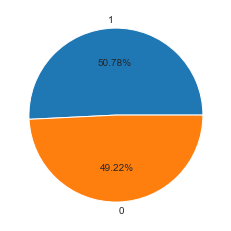

In [50]:
#Piechart visualisation
plt.pie(data_polarity['score'].value_counts(),labels=data_polarity['score'].unique(),autopct='%1.2f%%')
plt.show()

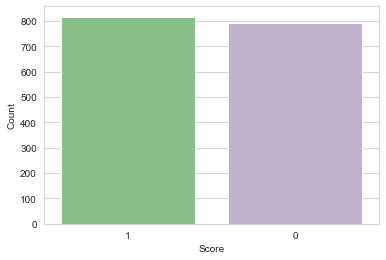

In [51]:
#Barchart Visualisation
sns.barplot(x=data_polarity['score'].unique(),y=data_polarity['score'].value_counts(),data=data_polarity,palette='Accent')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

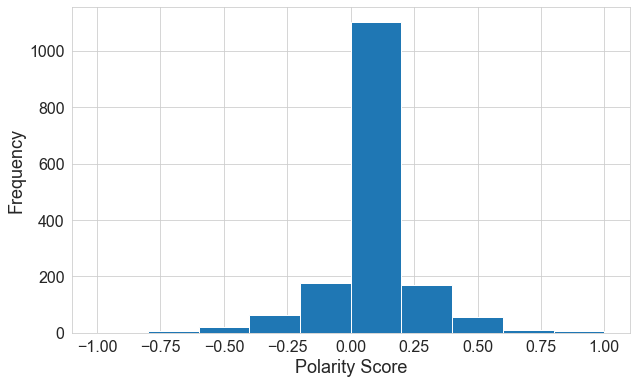

In [52]:
fig = plt.figure(figsize=(10, 6))
covid_data['polarity'].hist()
plt.xlabel('Polarity Score', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#fig.savefig("./figures/polarity_hist.png")

(array([  0., 100., 200., 300., 400., 500.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

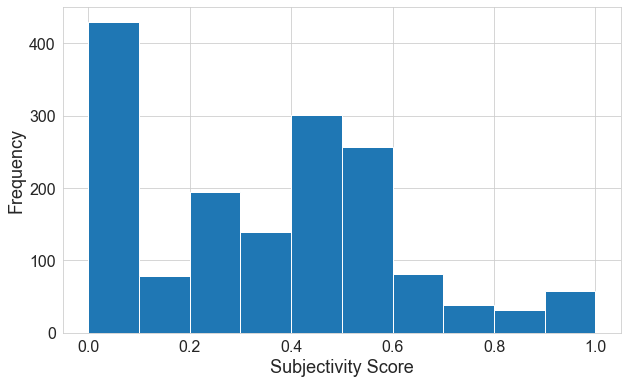

In [53]:

fig = plt.figure(figsize=(10, 6))
covid_data['subjectivity'].hist()
plt.xlabel('Subjectivity Score', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#fig.savefig("./figures/subjectivity_hist.png")

Inspection

In [54]:
# inspect the most negatively charged tweets
covid_data.sort_values(by='polarity', ascending=True)[['ConsumerComplaint', 'polarity', 'subjectivity']].reset_index(drop=True).head(n=10)

,ConsumerComplaint,polarity,subjectivity
0,situation grim state face shortage oxygen med...,-1.000000,1.000000
1,lockdown feel youre show symptom sick think...,-0.714286,0.857143
2,e14 painful swab test say nutshell swab test ...,-0.700000,0.783333
3,watch situation get bad city india watch sit...,-0.700000,0.666667
4,ptvnewstonight bad ph situation mela lesmoras...,-0.700000,0.666667
5,surge saskatchewan strain healthcare system o...,-0.666667,1.000000
6,rapid test head home take dirty washing home ...,-0.600000,0.800000
7,death surge whatsup dangerous situation deat...,-0.600000,0.900000
8,ph rank 111th case fatality rate philippine ...,-0.533333,0.733333
9,unrest create explosive situation guadeloupe ...,-0.500000,1.000000


In [55]:
# inspect the most positively charged tweets
covid_data.sort_values(by='polarity', ascending=False)[['ConsumerComplaint', 'polarity', 'subjectivity']].reset_index(drop=True).head(n=10)

,ConsumerComplaint,polarity,subjectivity
0,panic buying evolutionary brain work videos p...,1.00,1.00
1,use antigen test infectious disease expert ex...,1.00,0.30
2,health worker perform bhangra cheer patient i...,0.85,1.00
3,kapuso showbiz alden richards effect pandem...,0.80,0.75
4,great icmr approve self test kit great icmr...,0.80,0.75
5,elect country president bongbong marcos plan p...,0.80,0.90
6,help deaf people understand pandemic need bre...,0.75,0.95
7,bts jin rm suga successfully recover billboar...,0.75,0.95
8,help deaf people understand pandemic need bre...,0.75,0.95
9,help deaf people understand pandemic need bre...,0.75,0.95


In [56]:
# inspect the most subjective content (NOTE: subjectivity scale ranges from 0 to 1)
covid_data.sort_values(by='subjectivity', ascending=True)[['ConsumerComplaint', 'polarity', 'subjectivity']].reset_index(drop=True).head(n=10)

,ConsumerComplaint,polarity,subjectivity
0,pm modi say fruitful conversation joe biden s...,0.0,0.0
1,globalink senegal receives batch chinese sen...,0.0,0.0
2,shot test fuel walgreens sale walgreens boot...,0.0,0.0
3,senegal start vaccination program china sinop...,0.0,0.0
4,head say pandemic accelerate heartbreaking he...,0.0,0.0
5,dr birx dr ashton sexism medicine science whit...,0.0,0.0
6,globalink senegal kick vaccination campaign c...,0.0,0.0
7,senegal start vaccination program china sinop...,0.0,0.0
8,global situation global situationglobal sit...,0.0,0.0
9,trump v biden issue health donald j trump v j...,0.0,0.0


In [57]:

# inspect the most objective tweets
covid_data.sort_values(by='subjectivity', ascending=False)[['ConsumerComplaint', 'polarity', 'subjectivity']].reset_index(drop=True).head(n=10)

,ConsumerComplaint,polarity,subjectivity
0,visit institut pasteur dakar vaccinate world c...,0.00,1.0
1,visit institut pasteur dakar vaccinate world c...,0.00,1.0
2,pandemic end pandemic end expert look likely ...,0.00,1.0
3,pandemic ultimately think end look like flu ...,0.00,1.0
4,health worker perform bhangra cheer patient i...,0.85,1.0
5,pfizer antibody study study find antibody cre...,0.00,1.0
6,unrest create explosive situation guadeloupe ...,-0.50,1.0
7,layer mask help prevent spread homemade cloth...,0.00,1.0
8,country share case wealthy country donate,0.50,1.0
9,pfizer antibody study study find antibody cre...,0.00,1.0


Time-Series Sentiment Analysis

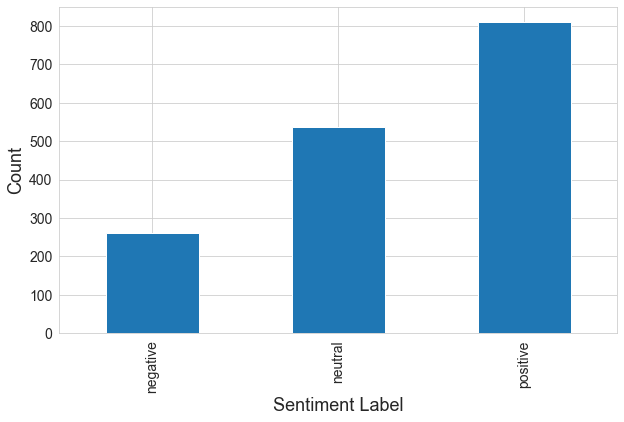

<Figure size 432x288 with 0 Axes>

In [58]:
# polarity values ranging from -1 to 1 are really useful for sentiment analysis
# but let's convert our data to 3 classes (negative, neutral, and positive) so that we can visualize it
criteria = [covid_data['polarity'].between(-1, -0.01), covid_data['polarity'].between(-0.01, 0.01), covid_data['polarity'].between(0.01, 1)]
values = ['negative', 'neutral', 'positive']
covid_data['sentiment'] = np.select(criteria, values, 0)

# plot sentiment counts
fig = plt.figure(figsize=(10, 6))
covid_data['sentiment'].value_counts().sort_index().plot.bar()
plt.xlabel('Sentiment Label', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()
plt.tight_layout()
#fig.savefig("./figures/sentiment_value_counts", bbox_inches='tight');

In [59]:
#!pip install plotly

In [60]:
#!pip install wordcloud

In [61]:
#!pip install gensim
#!pip install gensim
#!pip install gensim==3.8.3

In [62]:
#!pip install pyLDAvis

In [63]:
# Import the following libraries


# Visualization libraries
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
#from wordcloud import WordCloud
from PIL import Image # for world cloud image


# To change date to datetime
from datetime import datetime
import re 

from collections import Counter
import string
import scipy.sparse

# Gensim libraries
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore
#import pyLDAvis
#import pyLDAvis.gensim_models as gensimvis
from gensim.models import CoherenceModel
from gensim import matutils

# To show all the columns
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 300)

# to pickle dataframe
import pickle
# Avoid warnings
import warnings
warnings.filterwarnings("ignore")


# Enable logging for gensim - optional but important
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [64]:
#  Let's pickle it for later use
clean_review = covid_data['ConsumerComplaint']

In [65]:
clean_review

0                               new case linger 3000 fourth day row  new case linger 3000 fourth day rowread httpsbitly3f9sykhwatch httpsthestartvcomcnewssubscribe httpscuttlythestarlike httpsfbcomthestaronline
1                                                                                                        child ukraine unicefsupported doctor ukraine make sure child get vaccinate amid war covid19longlifeforall
2                                                                                   health equity  availability   soon   available cost people age 12 matter immigration  health insurance learn httpsbitly2rzt4hl
3                                 vaccination incentives ethical  context ethical offer incentives get   webmd chief medical officer dr john whyte speak dr arthur l caplan professor bioethics nyu langone health
4                                                                                          protect mental health  pandemic second wave  take toll mental hea

In [66]:
#!pip install spacy

In [67]:
import spacy
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
#stop_words.extend(['covid19','pandemic','people','poverty','hunger'])
nlp = spacy.load('en_core_web_sm')

def lematized_review(text): # text
    rev_text = nlp(text)
    # Extract lematized words in lower case format if not digits, not punctuation, not stopword, and length not less than 2
    rev_text = ([token.lemma_.lower() for token in rev_text if not token.is_stop and token.text not in STOPWORDS and not token.is_punct and len(token.text) > 3])
    return rev_text

In [68]:
%%time
# Applying the function on the reviews 

clean_brand_review = clean_review.apply(lematized_review)

CPU times: total: 14.1 s
Wall time: 14.1 s


In [69]:
clean_brand_review

0                                              [case, linger, 3000, fourth, case, linger, 3000, fourth, rowread, httpsbitly3f9sykhwatch, httpsthestartvcomcnewssubscribe, httpscuttlythestarlike, httpsfbcomthestaronline]
1                                                                                                                  [child, ukraine, unicefsupported, doctor, ukraine, sure, child, vaccinate, amid, covid19longlifeforall]
2                                                                                          [health, equity, availability, soon, available, cost, people, matter, immigration, health, insurance, learn, httpsbitly2rzt4hl]
3                                         [vaccination, incentive, ethical, context, ethical, offer, incentive, webmd, chief, medical, officer, john, whyte, speak, arthur, caplan, professor, bioethics, langone, health]
4                                                                                                 [protect, mental, health, 

In [70]:

%%time
# Create Dictionary
id2word_1 = corpora.Dictionary(clean_brand_review)

# Create Corpus: Term Document Frequency
corpus_1 = [id2word_1.doc2bow(review) for review in clean_brand_review]

 # Build LDA model
ldamodel = LdaMulticore(corpus= corpus_1, num_topics =30, id2word=id2word_1,chunksize=2000, passes=50,per_word_topics=True)

CPU times: total: 58.3 s
Wall time: 59.3 s


chunksize controls how many documents are processed at a time in the training algorithm. Increasing chunksize will speed up training, at least as long as the chunk of documents easily fit into memory. passes controls how often we train the model on the entire corpus

In [71]:
from pprint import pprint

pprint(ldamodel.show_topics(formatted=False))

[(10,
  [('test', 0.035055783),
   ('health', 0.026691955),
   ('senegal', 0.019640706),
   ('people', 0.016162612),
   ('disease', 0.013418309),
   ('treat', 0.011712138),
   ('state', 0.011207887),
   ('million', 0.010878887),
   ('patient', 0.010477918),
   ('question', 0.009969806)]),
 (15,
  [('community', 0.017176885),
   ('people', 0.017153263),
   ('home', 0.0118786255),
   ('deaf', 0.010638971),
   ('test', 0.009781175),
   ('india', 0.009149474),
   ('case', 0.008987965),
   ('protect', 0.00886879),
   ('senegal', 0.008793239),
   ('positive', 0.008391628)]),
 (0,
  [('case', 0.105892934),
   ('health', 0.031829022),
   ('report', 0.030675687),
   ('httpscuttlythestarlike', 0.023385739),
   ('httpsfbcomthestaronline', 0.023385739),
   ('httpsthestartvcomcnewssubscribe', 0.023385739),
   ('record', 0.023065452),
   ('infection', 0.021592883),
   ('omicron', 0.020574637),
   ('variant', 0.016901435)]),
 (12,
  [('health', 0.018082526),
   ('pandemic', 0.01726614),
   ('duterte'

In [72]:
# Compute Perplexity

#It's a measure of how good the model is. The lower the better. Perplexity is a negative value

print('\nPerplexity: ', ldamodel.log_perplexity(corpus_1))  

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamodel, texts=clean_brand_review, dictionary=id2word_1, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\n Basic Ldamodel Coherence Score: ', coherence_lda)


Perplexity:  -7.468489947275434

 Basic Ldamodel Coherence Score:  0.4000945465934927


### Notes

perplexity is a measurement of how well a probability distribution or probability model predicts a sample. It may be used to compare probability models. A low perplexity indicates the probability distribution is good at predicting the sample.

The coherence score is used in assessing the quality of the learned topics, the closer to 1 the better

In [73]:
"""
import os
from gensim.models.wrappers import LdaMallet
os.environ.update({'MALLET_HOME':r'C:/mallet-2.0.8/'}) 

import gensim
#os.environ['MALLET_HOME'] = r'C:/mallet-2.0.8/'

#You should update this path as per the path of Mallet directory on your system.
mallet_path ='C:\\mallet-2.0.8\\bin\\mallet' 
#ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus_1, num_topics=20, id2word=id2word_1)

#pprint(ldamallet.show_topics(formatted=False))
"""

"\nimport os\nfrom gensim.models.wrappers import LdaMallet\nos.environ.update({'MALLET_HOME':r'C:/mallet-2.0.8/'}) \n\nimport gensim\n#os.environ['MALLET_HOME'] = r'C:/mallet-2.0.8/'\n\n#You should update this path as per the path of Mallet directory on your system.\nmallet_path ='C:\\mallet-2.0.8\\bin\\mallet' \n#ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus_1, num_topics=20, id2word=id2word_1)\n\n#pprint(ldamallet.show_topics(formatted=False))\n"

In [74]:
import gensim
#!python -m pip install -U gensim
#!pip3 install gensim==3.8.3

In [75]:
import os
from gensim.models.wrappers import LdaMallet

from gensim.models.wrappers.ldamallet import malletmodel2ldamodel
os.environ.update({'MALLET_HOME':r'C:/mallet-2.0.8/'}) 
#You should update this path as per the path of Mallet directory on your system.
mallet_path = 'C:/mallet-2.0.8/bin/mallet' 
#You should update this path as per the path of Mallet directory on your system.


In [76]:
#conda install -c conda-forge mallet

In [77]:
import gensim
ldamallet = gensim.models.wrappers.LdaMallet(
   mallet_path, corpus=corpus_1, num_topics=20, id2word=id2word_1
)
pprint(ldamallet.show_topics(formatted=False))

[(9,
  [('india', 0.07862679955703211),
   ('pandemic', 0.06921373200442968),
   ('care', 0.040420819490586936),
   ('payment', 0.02602436323366556),
   ('raise', 0.024916943521594685),
   ('fight', 0.01937984496124031),
   ('music', 0.018826135105204873),
   ('initiative', 0.018826135105204873),
   ('bring', 0.01716500553709856),
   ('fund', 0.01716500553709856)]),
 (0,
  [('child', 0.05725376031052887),
   ('food', 0.03444929645803008),
   ('minister', 0.029597282872392043),
   ('government', 0.023289665211062592),
   ('family', 0.021834061135371178),
   ('free', 0.01601164483260553),
   ('hunger', 0.01601164483260553),
   ('school', 0.015041242115477924),
   ('increase', 0.013585638039786511),
   ('member', 0.012130033964095099)]),
 (5,
  [('situation', 0.07450331125827815),
   ('watch', 0.04249448123620309),
   ('medical', 0.039183222958057394),
   ('video', 0.03642384105960265),
   ('chief', 0.028145695364238412),
   ('city', 0.023730684326710817),
   ('control', 0.020971302428256

In [78]:
### Show Topics
#from pprint import pprint
#pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=clean_brand_review, dictionary=id2word_1, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\n Mallet Coherence Score: ', coherence_ldamallet)


 Mallet Coherence Score:  0.41368500964343535


In [79]:
# Compute Coherence Score using UMass
coherence_model_lda = CoherenceModel(model=ldamallet, texts=clean_brand_review, dictionary=id2word_1, coherence="u_mass")
coherence_lda = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.41368500964343535


### To find the optimum number of topics

In [80]:
# Defining a function to get coherence score
def my_coherence_vals(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMallet(mallet_path, corpus=corpus_1, num_topics=num_topics, id2word=id2word_1)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [81]:
# To get the coherence values
model_list, coherence_values = my_coherence_vals(dictionary=id2word_1, corpus=corpus_1, 
                                                 texts=clean_brand_review, start=2, limit=26, step=6)

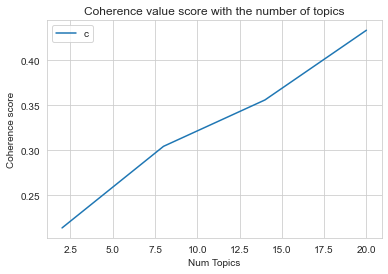

In [82]:
# Show graph for the coherence value scores vs number of topics
limit=26; start=2; step=6;
topics = range(start, limit, step)
plt.plot(topics, coherence_values)
plt.title("Coherence value score with the number of topics")
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### Print the coherence scores
for best, cv in zip(topics, coherence_values):
    print("Topic ", best, " has Coherence Value of", round(cv, 4))

In [83]:
# printing the best topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.056*"senegal" + 0.028*"china" + 0.025*"vaccinate" + 0.025*"government" + '
  '0.025*"globalink" + 0.025*"vaccination" + 0.024*"receive" + 0.020*"worker" '
  '+ 0.020*"continue" + 0.016*"find"'),
 (1,
  '0.038*"world" + 0.016*"high" + 0.015*"food" + 0.012*"national" + '
  '0.012*"expert" + 0.012*"face" + 0.011*"impact" + 0.011*"pandemic" + '
  '0.011*"country" + 0.010*"crisis"'),
 (2,
  '0.084*"people" + 0.022*"hospital" + 0.021*"patient" + 0.015*"young" + '
  '0.012*"surge" + 0.011*"time" + 0.011*"wave" + 0.010*"long" + 0.009*"work" + '
  '0.009*"virus"'),
 (3,
  '0.062*"pandemic" + 0.031*"india" + 0.020*"care" + 0.020*"spread" + '
  '0.018*"share" + 0.015*"medical" + 0.014*"protect" + 0.011*"chief" + '
  '0.011*"fight" + 0.010*"payment"'),
 (4,
  '0.055*"report" + 0.036*"country" + 0.036*"senegal" + 0.034*"pandemic" + '
  '0.027*"minister" + 0.023*"african" + 0.020*"dakar" + 0.019*"shipment" + '
  '0.018*"poverty" + 0.016*"month"'),
 (5,
  '0.040*"situation" + 0.026*"child" 

In [84]:
"""
#Visualize the topic
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(ldamodel, corpus=corpus_1, dictionary=id2word_1,sort_topics=False)
LDAvis_prepared
"""

'\n#Visualize the topic\npyLDAvis.enable_notebook()\nLDAvis_prepared = pyLDAvis.gensim.prepare(ldamodel, corpus=corpus_1, dictionary=id2word_1,sort_topics=False)\nLDAvis_prepared\n'

In [85]:
"""
# Save the visulaization to html
pyLDAvis.save_html(LDAvis_prepared, 'LdaModel_viz.html')
"""

"\n# Save the visulaization to html\npyLDAvis.save_html(LDAvis_prepared, 'LdaModel_viz.html')\n"

### EXTRACTING MORE MEANING FROM THE REVIEWS

In [86]:
# Define the sentence topics
def sentence_topics(ldamodel=None, corpus=corpus_1, texts=clean_brand_review):
    # Init output
    topics_df = pd.DataFrame()

    # Looping through the documents to find the main topics
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        
        # look for the Dominant topic, % contribution and Keywords 
        for j, (topic_num, prop_topic) in enumerate(row):
            
            # Diplay the dominant topics
            if j == 0:  
                dom = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in dom])
                topics_df = topics_df.append(pd.Series([int(topic_num), round(prop_topic,2)*100, topic_keywords]), ignore_index=True)
            else:
                break
    topics_df.columns = ['Dominant_Review_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Concatenate the text and the topics_df
    contents = pd.Series(texts)
    topics_df = pd.concat([topics_df, contents], axis=1)
    return(topics_df)


df_topic_sents_keywords = sentence_topics(ldamodel=ldamodel, corpus=corpus_1, texts=clean_brand_review)

# Format
dominant_review_topic = df_topic_sents_keywords.reset_index()
dominant_review_topic.columns = ['Review_No', 'Dominant_Review_Topic', 'Percent_contr_per_topic', 'Review_Keywords', 'Original review']

# Show
dominant_review_topic.head(10)

,Review_No,Dominant_Review_Topic,Percent_contr_per_topic,Review_Keywords,Original review
0,0,16,47.000000,"people, test, health, south, leader, understand, president, sign, area, nigeria","[case, linger, 3000, fourth, case, linger, 3000, fourth, rowread, httpsbitly3f9sykhwatch, httpsthestartvcomcnewssubscribe, httpscuttlythestarlike, httpsfbcomthestaronline]"
1,1,27,57.999998,"child, california, poppy, hillside, carpet, late, home, people, amid, stay","[child, ukraine, unicefsupported, doctor, ukraine, sure, child, vaccinate, amid, covid19longlifeforall]"
2,2,21,93.000001,"group, china, senegal, pandemic, people, watch, raise, awareness, shanghai, billion","[health, equity, availability, soon, available, cost, people, matter, immigration, health, insurance, learn, httpsbitly2rzt4hl]"
3,3,4,49.000001,"senegal, pandemic, medical, hospital, chief, world, officer, john, whyte, webmd","[vaccination, incentive, ethical, context, ethical, offer, incentive, webmd, chief, medical, officer, john, whyte, speak, arthur, caplan, professor, bioethics, langone, health]"
4,4,28,94.000000,"situation, health, pandemic, mental, impact, current, state, people, watch, report","[protect, mental, health, pandemic, second, wave, toll, mental, health, swati, mukherjee, tell, calm, tackle, situation]"
5,5,21,92.000002,"group, china, senegal, pandemic, people, watch, raise, awareness, shanghai, billion","[senegal, group, music, raise, awareness, meet, group, senegal, music, raise, awareness]"
6,6,17,66.000003,"esport, game, world, player, competition, health, championship, country, korea, case","[hospital, health, worker, serenade, recovery, hotdog, manila, people, successfully, recover, disease, health, care, worker, hospital, manila, sure, sendoff, remember, thursdaycoronaviruscovid19phread, httpsnewsinfoinquirernet1253086staanahospitalhealthworkersserenadecovid19recoverieswithhotdogs..."
7,7,13,60.000002,"payment, pandemic, care, fund, work, gateway, initiative, partner, donation, india","[unicef, covax, work, supply, lowincome, countrieshow, watch, find]"
8,8,7,57.999998,"test, health, positive, fight, senegal, dollar, battle, pandemic, country, experience","[child, wish, child, world, immunization, weekthank, help, protect, child, preventable, disease, like, polio, measle, pandemic, beyondlonglifeforall]"
9,9,10,95.999998,"test, health, senegal, people, disease, treat, state, million, patient, question","[whoopi, goldberg, share, health, test, positive, check, whoopi, test, positive, breakthrough, case, holiday, whoopi, goldberg, join, live, home, tell, share, plan, return, theview, monday, abcnws2rih3wd]"


In [87]:
dominant_review_topic.to_csv("C:/Users/HARYS/OneDrive/Documents/senego/facebook/facebookthree/reviewstwitter.csv", index=False)

<AxesSubplot:xlabel='Dominant_Review_Topic', ylabel='Percent_contr_per_topic'>

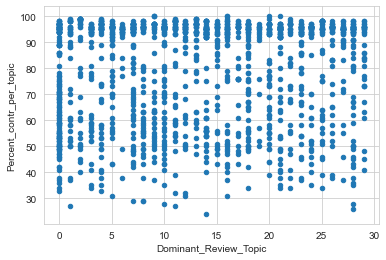

In [88]:
dominant_review_topic[dominant_review_topic['Dominant_Review_Topic'] < 100].plot.scatter(x='Dominant_Review_Topic', y='Percent_contr_per_topic')

In [89]:


# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")

# The Dataframe
sent_topics_df = pd.DataFrame()

topics_out = df_topic_sents_keywords.groupby('Dominant_Review_Topic')

for i, j in topics_out:
    sent_topics_df = pd.concat([sent_topics_df,j.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)

    
sent_topics_df.reset_index(drop=True, inplace=True)

# Format
sent_topics_df.columns = ['Topic_Num', "Percent_contr_per_topic", "Review_Keywords", "Original review"]

# Display the 8 topics
sent_topics_df.head(8)

,Topic_Num,Percent_contr_per_topic,Review_Keywords,Original review
0,0,98.000002,"case, health, report, httpscuttlythestarlike, httpsfbcomthestaronline, httpsthestartvcomcnewssubscribe, record, infection, omicron, variant","[4626, case, saturday, omicron, variant, detect, case, health, ministry, report, 4626, case, 4690, recovery, saturday, 11health, directorgeneral, noor, hisham, abdullah, total, case, variant, concern, report, year, comprise, 4722, case, delta, b16172, case, beta, b11351, case, omicron, b11529rea..."
1,1,99.000001,"pandemic, senegal, response, church, lutheran, fund, country, woman, people, disease","[watch, subsaharan, home, business, health, care, center, need, reliable, electricity, build, selfreliance, respond, covid19through, power, usaid, agency, international, development, united, state, government, strengthen, electricity, transmission, distribution, network, increase, improve, energ..."
2,2,99.000001,"report, poverty, economic, african, dakar, country, discuss, minister, senegal, plan","[com2022expert, discuss, africas, plight, good, practice, prospect, conference, african, minister, finance, plan, economic, development, dakar, senegal, economic, report, address, poverty, vulnerability, pandemic, launch, event, report, indicate, african, country, risk, debt, distress, cameroon,..."
3,3,97.000003,"young, people, pandemic, know, need, spread, virus, video, like, test","[s22e453, science, writer, predict, pandemic, 2012, science, writer, david, quamman, predict, pandemic, like, book, spillover, year, agothe, science, scientist, know, listen, select, group, shrewd, infectious, disease, scientist, come, virus, animal, possibly, httpscnnit3dersq7, cnntownhall]"
4,4,99.000001,"senegal, pandemic, medical, hospital, chief, world, officer, john, whyte, webmd","[hunger, poverty, unemployment, feed, poor, hungry, needy, people, team, tarasankar, charity, youtube, link, httpsyoutube2gskrrfpccannadataproject, teamtarasankarcharitymillion, people, risk, hunger, pandemic, india, individual, rely, food, handout, crisis, livelihood, disease, discriminate, imp..."
5,5,98.000002,"people, test, case, senegal, work, hospital, catastrophic, doctor, surge, patient","[tucker, carlson, claim, america, treat, people, people, reid, deem, tucker, carlson, absolute, claim, america, treat, people, people, aidsthere, comparison, treat, patient, america, simply, people, extremely, infectious, airborne, disease, stay, home, sick, wear, tiny, piece, cloth, cover, coug..."
6,6,97.000003,"test, school, senegal, class, student, centre, issue, laboratory, amid, pandemic","[swab, sample, test, collect, employeesoutsourcingdaily, wager, community, health, centre, khaltsi, khaltsi, subdivision, total, sample, collect, khaltsi, today, swab, sample, test, collect, employeesoutsourcingdaily, wager, community, health, centre, khaltsi, khaltsi, subdivision, total, sample..."
7,7,98.000002,"test, health, positive, fight, senegal, dollar, battle, pandemic, country, experience","[outbreak, girl, changemaker, sweta, live, time, sweta, plan, indias, girl, changemaker, uttarakhand, stress, able, pursue, study, college, share, adopt, online, education, ensure, guidance, peer, mentor, video, series, curate, plan, india, young, girl, changemaker, share, experience, live, time..."


In [90]:
sent_topics_df.to_csv("C:/Users/HARYS/OneDrive/Documents/senego/facebook/facebookthree/sentencestwitter.csv", index=False)

In [91]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Review_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Review_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(10)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,16,"people, test, health, south, leader, understand, president, sign, area, nigeria",154.0,0.0957
1,27,"child, california, poppy, hillside, carpet, late, home, people, amid, stay",43.0,0.0267
2,21,"group, china, senegal, pandemic, people, watch, raise, awareness, shanghai, billion",38.0,0.0236
3,4,"senegal, pandemic, medical, hospital, chief, world, officer, john, whyte, webmd",52.0,0.0323
4,28,"situation, health, pandemic, mental, impact, current, state, people, watch, report",58.0,0.0360
5,21,"group, china, senegal, pandemic, people, watch, raise, awareness, shanghai, billion",61.0,0.0379
6,17,"esport, game, world, player, competition, health, championship, country, korea, case",26.0,0.0162
7,13,"payment, pandemic, care, fund, work, gateway, initiative, partner, donation, india",77.0,0.0479
8,7,"test, health, positive, fight, senegal, dollar, battle, pandemic, country, experience",55.0,0.0342
9,10,"test, health, senegal, people, disease, treat, state, million, patient, question",45.0,0.0280


In [92]:
df_dominant_topics.to_csv("C:/Users/HARYS/OneDrive/Documents/senego/facebook/facebookthree/dominantstwitter.csv", index=False)


In [93]:
# Modify Dataframe 2 by reseting the Index and adding a new column EmpID
data_polarity['EmpID'] = data_polarity.index
data_polarity.reset_index(inplace=True)

In [94]:
data_merge = dominant_review_topic.merge(data_polarity, left_index=True, right_on='EmpID')
data_merge = data_merge.set_index('EmpID')
data_merge.head(10)

,Review_No,Dominant_Review_Topic,Percent_contr_per_topic,Review_Keywords,Original review,index,ConsumerComplaint,polarity,subjectivity,score
EmpID,,,,,,,,,,
0,0,16,47.000000,"people, test, health, south, leader, understand, president, sign, area, nigeria","[case, linger, 3000, fourth, case, linger, 3000, fourth, rowread, httpsbitly3f9sykhwatch, httpsthestartvcomcnewssubscribe, httpscuttlythestarlike, httpsfbcomthestaronline]",0,new case linger 3000 fourth day row new case linger 3000 fourth day rowread httpsbitly3f9sykhwatch httpsthestartvcomcnewssubscribe httpscuttlythestarlike httpsfbcomthestaronline,0.068182,0.227273,1
1,1,27,57.999998,"child, california, poppy, hillside, carpet, late, home, people, amid, stay","[child, ukraine, unicefsupported, doctor, ukraine, sure, child, vaccinate, amid, covid19longlifeforall]",1,child ukraine unicefsupported doctor ukraine make sure child get vaccinate amid war covid19longlifeforall,0.500000,0.888889,1
2,2,21,93.000001,"group, china, senegal, pandemic, people, watch, raise, awareness, shanghai, billion","[health, equity, availability, soon, available, cost, people, matter, immigration, health, insurance, learn, httpsbitly2rzt4hl]",2,health equity availability soon available cost people age 12 matter immigration health insurance learn httpsbitly2rzt4hl,0.400000,0.400000,1
3,3,4,49.000001,"senegal, pandemic, medical, hospital, chief, world, officer, john, whyte, webmd","[vaccination, incentive, ethical, context, ethical, offer, incentive, webmd, chief, medical, officer, john, whyte, speak, arthur, caplan, professor, bioethics, langone, health]",3,vaccination incentives ethical context ethical offer incentives get webmd chief medical officer dr john whyte speak dr arthur l caplan professor bioethics nyu langone health,0.133333,0.400000,1
4,4,28,94.000000,"situation, health, pandemic, mental, impact, current, state, people, watch, report","[protect, mental, health, pandemic, second, wave, toll, mental, health, swati, mukherjee, tell, calm, tackle, situation]",4,protect mental health pandemic second wave take toll mental health here dr swati mukherjee tell calm tackle situation,0.025000,0.287500,1
5,5,21,92.000002,"group, china, senegal, pandemic, people, watch, raise, awareness, shanghai, billion","[senegal, group, music, raise, awareness, meet, group, senegal, music, raise, awareness]",5,senegal rap group use music raise awareness meet rap group senegal music raise awareness,0.000000,0.000000,0
6,6,17,66.000003,"esport, game, world, player, competition, health, championship, country, korea, case","[hospital, health, worker, serenade, recovery, hotdog, manila, people, successfully, recover, disease, health, care, worker, hospital, manila, sure, sendoff, remember, thursdaycoronaviruscovid19phread, httpsnewsinfoinquirernet1253086staanahospitalhealthworkersserenadecovid19recoverieswithhotdogs...",6,sta ana hospital health worker serenade recovery hotdogs manila people successfully recover disease health care worker sta ana hospital manila sure sendoff remember thursdaycoronaviruscovid19phread httpsnewsinfoinquirernet1253086staanahospitalhealthworkersserenadecovid19recoverieswithhotdogsm...,0.625000,0.919444,1
7,7,13,60.000002,"payment, pandemic, care, fund, work, gateway, initiative, partner, donation, india","[unicef, covax, work, supply, lowincome, countrieshow, watch, find]",7,unicef covax work supply lowincome countrieshow watch find,0.000000,0.000000,0
8,8,7,57.999998,"test, health, positive, fight, senegal, dollar, battle, pandemic, country, experience","[child, wish, child, world, immunization, weekthank, help, protect, child, preventable, disease, like, polio, measle, pandemic, beyondlonglifeforall]",8,child wish child world immunization weekthank help protect child preventable disease like polio measles pandemic beyondlonglifeforall,0.000000,0.000000,0


In [ ]:
tt

In [147]:
data_merge.to_excel("C:/Users/HARYS/OneDrive/Documents/senego/facebook/facebookthree/facebooktopics/mergestwitter2.xlsx", index=False)

In [96]:
#C:\Users\harys\OneDrive\Documents\covid
tt

NameError: name 'tt' is not defined

In [148]:
dat_merge = data_merge

In [197]:
#dat_merge = pd.read_csv("C:/Users/HARYS/OneDrive/Documents/senego/facebook/facebookthree/facebooktopics/mergestwitter.csv", encoding = "UTF-8")
dat_merge = pd.read_excel('C:/Users/HARYS/OneDrive/Documents/senego/facebook/facebookthree/facebooktopics/mergestwitter.xlsx', sheet_name='Sheet1')

In [198]:
dat_merge.head()

,Review_No,Dominant_Review_Topic,Percent_contr_per_topic,Review_Keywords,Original review,index,ConsumerComplaint,polarity,subjectivity,score
0,0,16,47.000000,"people, test, health, south, leader, understand, president, sign, area, nigeria","['case', 'linger', '3000', 'fourth', 'case', 'linger', '3000', 'fourth', 'rowread', 'httpsbitly3f9sykhwatch', 'httpsthestartvcomcnewssubscribe', 'httpscuttlythestarlike', 'httpsfbcomthestaronline']",0,new case linger 3000 fourth day row new case linger 3000 fourth day rowread httpsbitly3f9sykhwatch httpsthestartvcomcnewssubscribe httpscuttlythestarlike httpsfbcomthestaronline,0.068182,0.227273,1
1,1,27,57.999998,"child, california, poppy, hillside, carpet, late, home, people, amid, stay","['child', 'ukraine', 'unicefsupported', 'doctor', 'ukraine', 'sure', 'child', 'vaccinate', 'amid', 'covid19longlifeforall']",1,child ukraine unicefsupported doctor ukraine make sure child get vaccinate amid war covid19longlifeforall,0.500000,0.888889,1
2,2,21,93.000001,"group, china, senegal, pandemic, people, watch, raise, awareness, shanghai, billion","['health', 'equity', 'availability', 'soon', 'available', 'cost', 'people', 'matter', 'immigration', 'health', 'insurance', 'learn', 'httpsbitly2rzt4hl']",2,health equity availability soon available cost people age 12 matter immigration health insurance learn httpsbitly2rzt4hl,0.400000,0.400000,1
3,3,4,49.000001,"senegal, pandemic, medical, hospital, chief, world, officer, john, whyte, webmd","['vaccination', 'incentive', 'ethical', 'context', 'ethical', 'offer', 'incentive', 'webmd', 'chief', 'medical', 'officer', 'john', 'whyte', 'speak', 'arthur', 'caplan', 'professor', 'bioethics', 'langone', 'health']",3,vaccination incentives ethical context ethical offer incentives get webmd chief medical officer dr john whyte speak dr arthur l caplan professor bioethics nyu langone health,0.133333,0.400000,1
4,4,28,94.000000,"situation, health, pandemic, mental, impact, current, state, people, watch, report","['protect', 'mental', 'health', 'pandemic', 'second', 'wave', 'toll', 'mental', 'health', 'swati', 'mukherjee', 'tell', 'calm', 'tackle', 'situation']",4,protect mental health pandemic second wave take toll mental health here dr swati mukherjee tell calm tackle situation,0.025000,0.287500,1


In [199]:
a = dat_merge['Review_Keywords'].unique()
#a.sort()
print(a)


['people, test, health, south, leader, understand, president, sign, area, nigeria'
 'child, california, poppy, hillside, carpet, late, home, people, amid, stay'
 'group, china, senegal, pandemic, people, watch, raise, awareness, shanghai, billion'
 'senegal, pandemic, medical, hospital, chief, world, officer, john, whyte, webmd'
 'situation, health, pandemic, mental, impact, current, state, people, watch, report'
 'esport, game, world, player, competition, health, championship, country, korea, case'
 'payment, pandemic, care, fund, work, gateway, initiative, partner, donation, india'
 'test, health, positive, fight, senegal, dollar, battle, pandemic, country, experience'
 'test, health, senegal, people, disease, treat, state, million, patient, question'
 'community, people, home, deaf, test, india, case, protect, senegal, positive'
 'senegal, china, globalink, receive, vaccination, sinopharm, chinese, begin, country, batch'
 'test, positive, patient, case, minute, recap, morning, healt

In [222]:
dat_merge2 = dat_merge.copy()
Topicsw = {'people, test, health, south, leader, understand, president, sign, area, nigeria':'world report',
 'child, california, poppy, hillside, carpet, late, home, people, amid, stay':'public protect',
 'group, china, senegal, pandemic, people, watch, raise, awareness, shanghai, billion':'prevention report',
 'senegal, pandemic, medical, hospital, chief, world, officer, john, whyte, webmd':'healthcare policy',
 'situation, health, pandemic, mental, impact, current, state, people, watch, report':'recovery report',
 'esport, game, world, player, competition, health, championship, country, korea, case':'news report',
 'payment, pandemic, care, fund, work, gateway, initiative, partner, donation, india':'fund policy',
 'test, health, positive, fight, senegal, dollar, battle, pandemic, country, experience':'prevention report',
 'test, health, senegal, people, disease, treat, state, million, patient, question':'recovery report',
 'community, people, home, deaf, test, india, case, protect, senegal, positive':'public protect',
 'senegal, china, globalink, receive, vaccination, sinopharm, chinese, begin, country, batch':'vaccination report',
 'test, positive, patient, case, minute, recap, morning, health, story, member':'news report',
 'case, health, senegal, world, ghana, system, healthcare, story, success, dose':'recovery report',
 'case, health, report, httpscuttlythestarlike, httpsfbcomthestaronline, httpsthestartvcomcnewssubscribe, record, infection, omicron, variant':'vaccination report',
 'health, minister, vaccination, country, technology, ministry, mrna, world, year, people':'government policy',
 'production, pandemic, future, help, plant, european, senegal, finance, bring, need':'fund policy',
 'pandemic, senegal, response, church, lutheran, fund, country, woman, people, disease':'public protect',
 'health, test, positive, fresh, daughter, department, situation, visit, minister, speak':'vaccination report',
 'report, poverty, economic, african, dakar, country, discuss, minister, senegal, plan':'government policy',
 'test, health, pandemic, global, live, border, trump, help, senegal, response':'world report',
 'case, rise, unicef, health, people, pandemic, water, help, protect, share':'world report',
 'health, pandemic, duterte, country, world, people, hunger, food, global, president':'hunger report',
 'test, school, senegal, class, student, centre, issue, laboratory, amid, pandemic':'education policy',
 'government, shutdown, survive, effort, environmental, conservation, time, true, continent, pandemic':'government policy',
 'pandemic, expect, state, situation, white, house, prepare, test, school, clean':'education policy',
 'shipment, moderna, toronto, arrive, pearson, airport, test, month, early, morning':'news report',
 'people, test, case, senegal, work, hospital, catastrophic, doctor, surge, patient':'healthcare policy',
 'food, senegal, recovery, health, doctor, announce, good, cure, vaccinate, bank':'vaccination report',
 'young, people, pandemic, know, need, spread, virus, video, like, test':'public protect',
 'amid, pandemic, program, fight, start, health, people, resurgence, test, government':'healthcare policy'}          
        

dat_merge2["Topics"]=dat_merge2["Review_Keywords"]
dat_merge2.Topics = dat_merge2.Topics.map(Topicsw).fillna(dat_merge2.Topics)
#df = pd.DataFrame(dic)
#df.name = df.name.map({'red': 0, 'blue': 1}).fillna(df.name)

dat_merge2["Topics1"]=dat_merge2["Dominant_Review_Topic"]
dat_merge2.Topics1 = dat_merge2.Topics1.map(Topicsw).fillna(dat_merge2.Topics)





dat_merge2.head(10)


,Review_No,Dominant_Review_Topic,Percent_contr_per_topic,Review_Keywords,Original review,index,ConsumerComplaint,polarity,subjectivity,score,Topics,Topics1
0,0,16,47.000000,"people, test, health, south, leader, understand, president, sign, area, nigeria","['case', 'linger', '3000', 'fourth', 'case', 'linger', '3000', 'fourth', 'rowread', 'httpsbitly3f9sykhwatch', 'httpsthestartvcomcnewssubscribe', 'httpscuttlythestarlike', 'httpsfbcomthestaronline']",0,new case linger 3000 fourth day row new case linger 3000 fourth day rowread httpsbitly3f9sykhwatch httpsthestartvcomcnewssubscribe httpscuttlythestarlike httpsfbcomthestaronline,0.068182,0.227273,1,world report,world report
1,1,27,57.999998,"child, california, poppy, hillside, carpet, late, home, people, amid, stay","['child', 'ukraine', 'unicefsupported', 'doctor', 'ukraine', 'sure', 'child', 'vaccinate', 'amid', 'covid19longlifeforall']",1,child ukraine unicefsupported doctor ukraine make sure child get vaccinate amid war covid19longlifeforall,0.500000,0.888889,1,public protect,public protect
2,2,21,93.000001,"group, china, senegal, pandemic, people, watch, raise, awareness, shanghai, billion","['health', 'equity', 'availability', 'soon', 'available', 'cost', 'people', 'matter', 'immigration', 'health', 'insurance', 'learn', 'httpsbitly2rzt4hl']",2,health equity availability soon available cost people age 12 matter immigration health insurance learn httpsbitly2rzt4hl,0.400000,0.400000,1,prevention report,prevention report
3,3,4,49.000001,"senegal, pandemic, medical, hospital, chief, world, officer, john, whyte, webmd","['vaccination', 'incentive', 'ethical', 'context', 'ethical', 'offer', 'incentive', 'webmd', 'chief', 'medical', 'officer', 'john', 'whyte', 'speak', 'arthur', 'caplan', 'professor', 'bioethics', 'langone', 'health']",3,vaccination incentives ethical context ethical offer incentives get webmd chief medical officer dr john whyte speak dr arthur l caplan professor bioethics nyu langone health,0.133333,0.400000,1,healthcare policy,healthcare policy
4,4,28,94.000000,"situation, health, pandemic, mental, impact, current, state, people, watch, report","['protect', 'mental', 'health', 'pandemic', 'second', 'wave', 'toll', 'mental', 'health', 'swati', 'mukherjee', 'tell', 'calm', 'tackle', 'situation']",4,protect mental health pandemic second wave take toll mental health here dr swati mukherjee tell calm tackle situation,0.025000,0.287500,1,recovery report,recovery report
5,5,21,92.000002,"group, china, senegal, pandemic, people, watch, raise, awareness, shanghai, billion","['senegal', 'group', 'music', 'raise', 'awareness', 'meet', 'group', 'senegal', 'music', 'raise', 'awareness']",5,senegal rap group use music raise awareness meet rap group senegal music raise awareness,0.000000,0.000000,0,prevention report,prevention report
6,6,17,66.000003,"esport, game, world, player, competition, health, championship, country, korea, case","['hospital', 'health', 'worker', 'serenade', 'recovery', 'hotdog', 'manila', 'people', 'successfully', 'recover', 'disease', 'health', 'care', 'worker', 'hospital', 'manila', 'sure', 'sendoff', 'remember', 'thursdaycoronaviruscovid19phread', 'httpsnewsinfoinquirernet1253086staanahospitalhealthwo...",6,sta ana hospital health worker serenade recovery hotdogs manila people successfully recover disease health care worker sta ana hospital manila sure sendoff remember thursdaycoronaviruscovid19phread httpsnewsinfoinquirernet1253086staanahospitalhealthworkersserenadecovid19recoverieswithhotdogsm...,0.625000,0.919444,1,news report,news report
7,7,13,60.000002,"payment, pandemic, care, fund, work, gateway, initiative, partner, donation, india","['unicef', 'covax', 'work', 'supply', 'lowincome', 'countrieshow', 'watch', 'find']",7,unicef covax work supply lowincome countrieshow watch find,0.000000,0.000000,0,fund policy,fund policy
8,8,7,57.999998,"test, health, positive, fight, senegal, dollar, battle, pandemic, country, experience","['child', 'wish',

<AxesSubplot:xlabel='polarity', ylabel='Percent_contr_per_topic'>

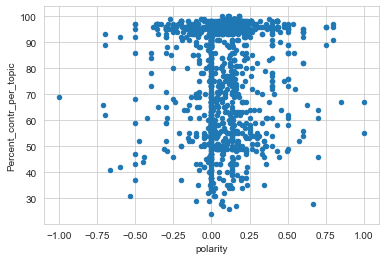

In [223]:
dat_merge[dat_merge['Dominant_Review_Topic'] < 100].plot.scatter(x='polarity', y='Percent_contr_per_topic')

In [224]:
poke = dat_merge2.groupby(['Topics']).mean()[['subjectivity', 'polarity']]

<AxesSubplot:xlabel='Topics'>

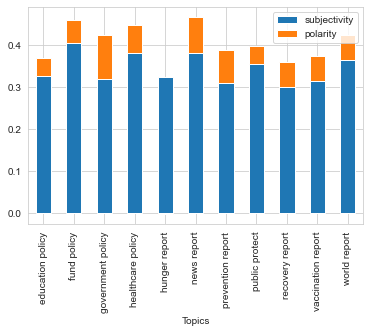

In [225]:
poke.plot.bar(stacked=True)

<AxesSubplot:xlabel='Topics'>

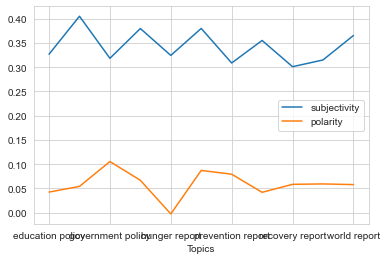

In [226]:
poke.plot.line()

In [227]:
poke2 = dat_merge.groupby('Dominant_Review_Topic').mean()[['subjectivity', 'polarity','Percent_contr_per_topic']]

<AxesSubplot:xlabel='Dominant_Review_Topic'>

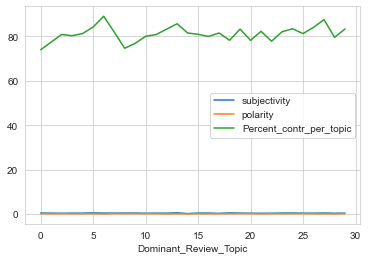

In [228]:
poke2.plot.line()

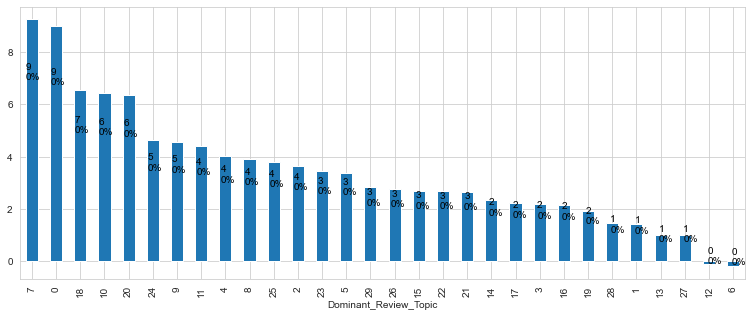

In [229]:
x = dat_merge.groupby(['Dominant_Review_Topic']).sum().copy()
ax = x.polarity.sort_values(ascending=False).plot(kind='bar', figsize=(13, 5));

for p in ax.patches:
    ax.annotate(str( round( p.get_height() ) ) + "\n" + str(round( p.get_height() /89.170) )+ "%", 
                (p.get_x() * 1.007, p.get_height() * 0.75),
                color='black')

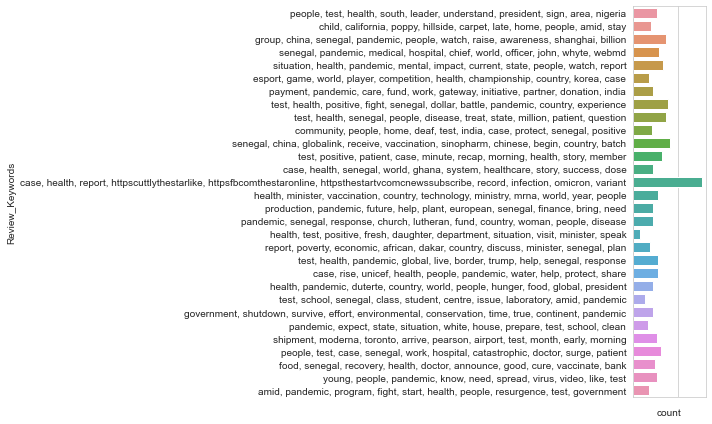

In [230]:
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
ax = sns.countplot(y='Review_Keywords', data=dat_merge)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

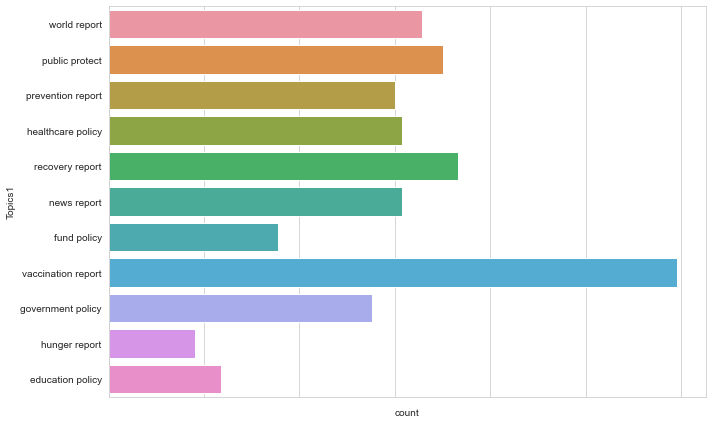

In [231]:
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
ax = sns.countplot(y='Topics1', data=dat_merge2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

In [232]:
data_merge.head(2)

,Review_No,Dominant_Review_Topic,Percent_contr_per_topic,Review_Keywords,Original review,index,ConsumerComplaint,polarity,subjectivity,score
EmpID,,,,,,,,,,
0,0,16,47.000000,"people, test, health, south, leader, understand, president, sign, area, nigeria","[case, linger, 3000, fourth, case, linger, 3000, fourth, rowread, httpsbitly3f9sykhwatch, httpsthestartvcomcnewssubscribe, httpscuttlythestarlike, httpsfbcomthestaronline]",0,new case linger 3000 fourth day row new case linger 3000 fourth day rowread httpsbitly3f9sykhwatch httpsthestartvcomcnewssubscribe httpscuttlythestarlike httpsfbcomthestaronline,0.068182,0.227273,1
1,1,27,57.999998,"child, california, poppy, hillside, carpet, late, home, people, amid, stay","[child, ukraine, unicefsupported, doctor, ukraine, sure, child, vaccinate, amid, covid19longlifeforall]",1,child ukraine unicefsupported doctor ukraine make sure child get vaccinate amid war covid19longlifeforall,0.500000,0.888889,1


In [161]:
dat_government = dat_merge2[dat_merge2['ConsumerComplaint'].str.contains(r'government')]
dat_government.head(2)

,Review_No,Dominant_Review_Topic,Percent_contr_per_topic,Review_Keywords,Original review,index,ConsumerComplaint,polarity,subjectivity,score,Topics,Topics1
EmpID,,,,,,,,,,,,
44,44,22,99.000001,"pandemic, expect, state, situation, white, house, prepare, test, school, clean","[clarification, dennis, statement, minister, health, school, student, parent, remain, guard, amidst, situation, dennis, fong, seek, clarity, government, decision, undertake, case, infect, staff, student, educational, institution, temporary, closure, institutionlocation, issue, stayhome, notice, ...",44,clarification dennis tan statement minister health school student parent remain guard amidst situation dennis tan lip fong sought clarity government decision undertake case infected staff student educational institution eg temporary closure institutionlocation issue stayhome notice pupils staf...,0.123333,0.200,1,education policy,education policy
89,89,9,94.000000,"government, shutdown, survive, effort, environmental, conservation, time, true, continent, pandemic","[etonguestickingoutcheekyplayfulorblowingaraspberrylainer, pandemic, rappler, sit, expert, scenario, endemic, future, virus, government, carve, path, pandemicmore, rappler, httpswwwrapplercomnewsbreakexplainersvideoexplaineriscovid19pandemicover]",89,etonguestickingoutcheekyplayfulorblowingaraspberrylainer pandemic rappler sits expert lay scenario endemic future virus government carve path pandemicmore rappler httpswwwrapplercomnewsbreakexplainersvideoexplaineriscovid19pandemicover,0.000000,0.125,0,governent policy,governent policy


In [233]:
dat_pharmacy = dat_merge2[dat_merge2['ConsumerComplaint'].str.contains(r'pharmacy')]
dat_pharmacy.head(2)

,Review_No,Dominant_Review_Topic,Percent_contr_per_topic,Review_Keywords,Original review,index,ConsumerComplaint,polarity,subjectivity,score,Topics,Topics1
176,176,3,94.0,"young, people, pandemic, know, need, spread, virus, video, like, test","['test', 'watch', 'test', 'sale', 'singapore', 'pharmacy', 'today', 'like', 'journalist', 'timothy', 'abbott', 'panbio', 'antigen', 'selftest', 'httpsstrsg34si']",176,diy test kit watch diy test kit sale singapore pharmacy today like use on journalist timothy goh try abbott panbio antigen selftest httpsstrsg34si,0.0,0.0,0,public protect,public protect
319,319,20,69.0,"health, minister, vaccination, country, technology, ministry, mrna, world, year, people","['govt', 'roll', 'vaccination', 'select', 'pharmacy', 'government', 'roll', 'vaccination', 'select', 'pharmacy', 'january', 'test', 'czar', 'vince', 'dizon', 'announcedread', 'httpsnewsinfoinquirernet1541793govtrollsoutcovid19vaccinationinselectpharmaciesonjan20to21']",319,govt roll vaccination select pharmacy jan 20 21 government roll vaccination select pharmacy january 20 21 test czar vince dizon announcedread httpsnewsinfoinquirernet1541793govtrollsoutcovid19vaccinationinselectpharmaciesonjan20to21,0.0,0.0,0,government policy,government policy


In [234]:
dat_security = dat_merge2[dat_merge2['ConsumerComplaint'].str.contains(r'security')]
dat_security.head(2)

,Review_No,Dominant_Review_Topic,Percent_contr_per_topic,Review_Keywords,Original review,index,ConsumerComplaint,polarity,subjectivity,score,Topics,Topics1
261,261,21,100.000000,"group, china, senegal, pandemic, people, watch, raise, awareness, shanghai, billion","['founder', 'president', 'sedima', 'group', 'babacar', 'ngom', 'ghana', 'team', 'investor', 'offer', 'opportunity', 'enable', 'ghana', 'attain', 'selfsufficiency', 'poultry', 'production', 'sedima', 'group', 'senegalese', 'business', 'dakar', 'deploy', 'agrobusiness', 'flour', 'mill', 'poultry',...",261,founder president sedima group mr babacar ngom ghana 6th team investor offer opportunity enable ghana attain selfsufficiency poultry production sedima group senegalese business dakar deploy agrobusiness flour mill poultry real estate lead company offer service field senegal subregion primary foc...,0.112821,0.402564,1,prevention report,prevention report
331,331,11,64.999998,"food, senegal, recovery, health, doctor, announce, good, cure, vaccinate, bank","['respond', 'food', 'insecurity', 'pandemic', 'food', 'insecurity', 'worsen', 'pandemic', 'late', 'video', 'share', 'datum', 'child', 'household', 'struggle', 'food', 'insecurity', 'explore', 'resource', 'respond', 'food', 'insecurity', 'httpsbuffly3mj0lw0']",331,respond food insecurity pandemic food insecurity worsen pandemic dr b late video share data child household struggle food insecurity explore resource respond food insecurity httpsbuffly3mj0lw0,-0.300000,0.600000,0,vaccination report,vaccination report


In [240]:
dat_media = dat_merge2[dat_merge2['ConsumerComplaint'].str.contains(r'media')]
dat_media.head(2)

,Review_No,Dominant_Review_Topic,Percent_contr_per_topic,Review_Keywords,Original review,index,ConsumerComplaint,polarity,subjectivity,score,Topics,Topics1
620,620,25,34.000000,"production, pandemic, future, help, plant, european, senegal, finance, bring, need","['world', 'health', 'organization', 'foundation', 'expand', 'access', 'trust', 'information', 'fight', 'access', 'information', 'critical', 'join', 'force', 'wikimedia', 'foundation', 'public', 'health', 'information', 'available', 'free', 'license', 'distribute', 'wikipediabetter', 'knowledge',...",620,world health organization foundation expand access trust information fight access information critical joining force wikimedia foundation public health information available free license distribute wikipediabetter knowledge well health,0.200000,0.516667,1,fund policy,fund policy
763,763,8,95.999998,"case, rise, unicef, health, people, pandemic, water, help, protect, share","['philippine', 'stop', 'release', 'daily', 'case', 'social', 'medium', 'nearly', 'year', 'case', 'bulletin', 'later', 'philippine', 'health', 'department', 'long', 'release', 'daily', 'social', 'medium', 'case', 'country', 'begin', 'january', 'story', 'httpswwwrapplercomnationphilippinesstoprele...",763,philippine stop release daily case social medium nearly year 600 case bulletin later philippine health department say long release daily social medium case country begin january 1 story httpswwwrapplercomnationphilippinesstopreleasingdailycovid19caseupdatesonsocialmediajanuary12022,0.016667,0.133333,1,world report,world report


In [236]:
dat_business = dat_merge2[dat_merge2['ConsumerComplaint'].str.contains(r'business')]
dat_business.head(2)

,Review_No,Dominant_Review_Topic,Percent_contr_per_topic,Review_Keywords,Original review,index,ConsumerComplaint,polarity,subjectivity,score,Topics,Topics1
112,112,1,99.000001,"pandemic, senegal, response, church, lutheran, fund, country, woman, people, disease","['watch', 'subsaharan', 'home', 'business', 'health', 'care', 'center', 'need', 'reliable', 'electricity', 'build', 'selfreliance', 'respond', 'covid19through', 'power', 'usaid', 'agency', 'international', 'development', 'united', 'state', 'government', 'strengthen', 'electricity', 'transmission...",112,watch subsaharan home business health care center need reliable electricity build selfreliance respond covid19through power usaid agency international development united state government strengthen electricity transmission distribution network increase improve energy accesscovid19 subsaharana...,-0.05,0.050,0,public protect,public protect
183,183,12,95.999998,"health, pandemic, duterte, country, world, people, hunger, food, global, president","['axis', 'bank', 'winner', 'post', 'mayhem', 'idea', 'profit', 'private', 'lender', 'axis', 'bank', 'cautious', 'step', 'weigh', 'fy21', 'profit', 'quality', 'balance', 'sheet', 'shape', 'axis', 'bank', 'longterm', 'winner', 'find', 'herehttpswwwmoneycontrolcomnewsbusinessearningsideasforprofitw...",183,make axis bank winner post mayhem idea profit private lender axis bank cautious step weigh q1 fy21 profit quality balance sheet get shape axis bank longterm winner find herehttpswwwmoneycontrolcomnewsbusinessearningsideasforprofitwhatmakesaxisbankawinnerpostthecovid19mayhem5580611html,0.00,0.375,0,hunger report,hunger report


In [237]:
dat_transport = dat_merge2[dat_merge2['ConsumerComplaint'].str.contains(r'transport')]
dat_transport.head(2)

,Review_No,Dominant_Review_Topic,Percent_contr_per_topic,Review_Keywords,Original review,index,ConsumerComplaint,polarity,subjectivity,score,Topics,Topics1
27,27,4,97.000003,"senegal, pandemic, medical, hospital, chief, world, officer, john, whyte, webmd","['total', 'panic', 'overwhelm', 'senegal', 'hospital', 'usbased', 'transport', 'worker', 'idrissa', 'return', 'senegal', 'family', 'member', 'start', 'week', 'mourn', 'fifth', 'relative', 'wave', 'leave', 'hospital', 'capital', 'spare', 'severe', 'case', 'race', 'vaccinate']",27,total panic overwhelms senegal hospital usbased transport worker idrissa lo return senegal family member start die week mourn fifth relative wave leave hospital capital spare bed severe case race vaccinate,0.0,0.375,0,healthcare policy,healthcare policy
131,131,4,97.000003,"senegal, pandemic, medical, hospital, chief, world, officer, john, whyte, webmd","['total', 'panic', 'overwhelm', 'senegal', 'hospital', 'usbased', 'transport', 'worker', 'idrissa', 'return', 'senegal', 'family', 'member', 'start', 'week', 'mourn', 'fifth', 'relative', 'wave', 'leave', 'hospital', 'capital', 'spare', 'severe', 'case', 'race', 'vaccinate']",131,total panic overwhelms senegal hospital usbased transport worker idrissa lo return senegal family member start die week mourn fifth relative wave leave hospital capital spare bed severe case race vaccinate,0.0,0.375,0,healthcare policy,healthcare policy


In [163]:
dat_education = dat_merge2[dat_merge2['ConsumerComplaint'].str.contains(r'education')]
dat_education.head(2)

,Review_No,Dominant_Review_Topic,Percent_contr_per_topic,Review_Keywords,Original review,index,ConsumerComplaint,polarity,subjectivity,score,Topics,Topics1
EmpID,,,,,,,,,,,,
44,44,22,99.000001,"pandemic, expect, state, situation, white, house, prepare, test, school, clean","[clarification, dennis, statement, minister, health, school, student, parent, remain, guard, amidst, situation, dennis, fong, seek, clarity, government, decision, undertake, case, infect, staff, student, educational, institution, temporary, closure, institutionlocation, issue, stayhome, notice, ...",44,clarification dennis tan statement minister health school student parent remain guard amidst situation dennis tan lip fong sought clarity government decision undertake case infected staff student educational institution eg temporary closure institutionlocation issue stayhome notice pupils staf...,0.123333,0.200000,1,education policy,education policy
105,105,14,98.000002,"senegal, china, globalink, receive, vaccination, sinopharm, chinese, begin, country, batch","[senegal, senegal, senegal, country, director, larson, holt, school, year, wrap, want, sure, recognize, incredible, work, accomplish, teacher, past, year, senegal, situation, remain, somewhat, stable, relative, country, school, close, 2020, information, work, senegal, visit, httpsmomsagainstpove...",105,map map senegal new map map senegal senegal country director larson holt school year wrap want sure recognize incredible work accomplish teacher past year senegal situation remain somewhat stable relative country school close well 2020 information work senegal visit httpsmomsagainstpovertyorg...,0.257273,0.498687,1,vaccination report,vaccination report


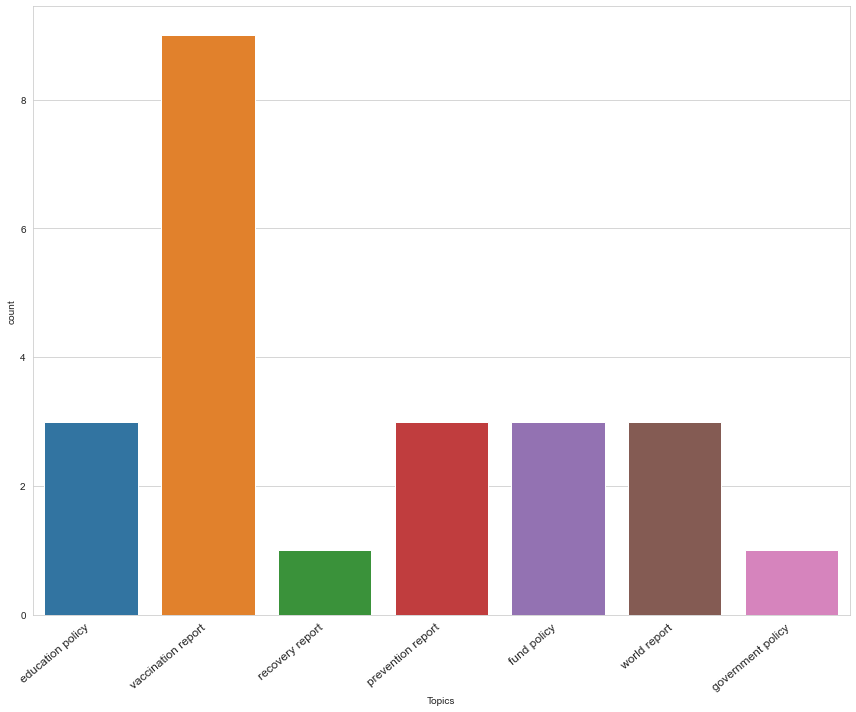

In [164]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 10))
ax = sns.countplot(x='Topics', data=dat_education)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

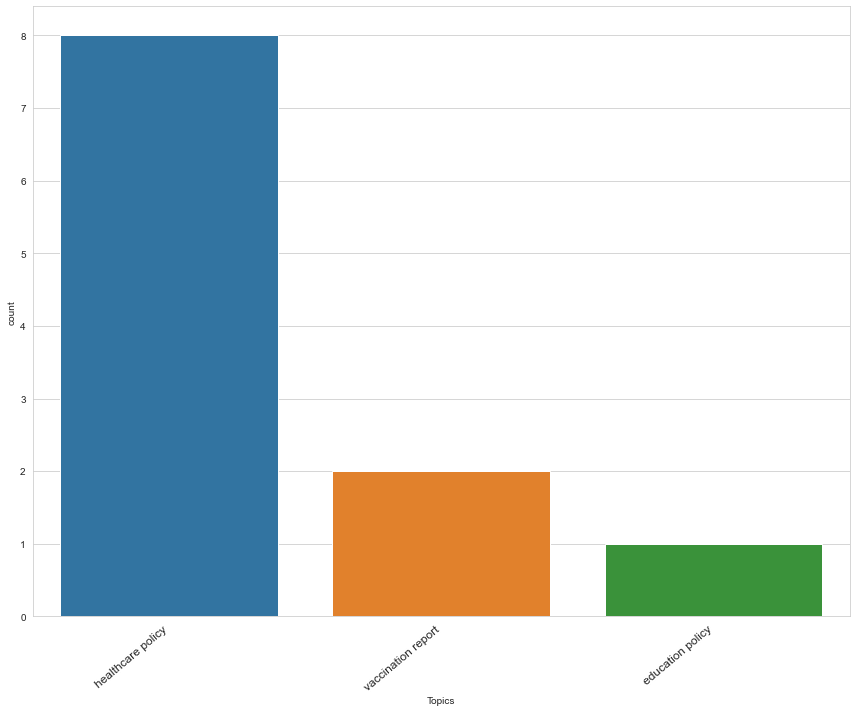

In [165]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 10))
ax = sns.countplot(x='Topics', data=dat_transport)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

In [178]:
#dat_poverty = dat_merge2[dat_merge2['ConsumerComplaint'].str.contains(r'poverty'and 'country'and'child'and'live'and'world'and'poor'and'development'and 'corruption' and 'economic')]
dat_poverty = dat_merge2[dat_merge2['ConsumerComplaint'].str.contains(r'poverty'or 'country'or'child'or'live'or'world'or'poor'or'development'or'corruption'or'economic')]

dat_poverty.head(2)

,Review_No,Dominant_Review_Topic,Percent_contr_per_topic,Review_Keywords,Original review,index,ConsumerComplaint,polarity,subjectivity,score,Topics,Topics1
EmpID,,,,,,,,,,,,
22,22,21,41.000000,"group, china, senegal, pandemic, people, watch, raise, awareness, shanghai, billion","[push, million, people, live, million, people, southeast, asia, push, poverty, read, httpsbitly3fb9u16]",22,push 130 million people live 190 day 82 million people southeast asia push poverty read httpsbitly3fb9u16,0.136364,0.500000,1,prevention report,prevention report
105,105,14,98.000002,"senegal, china, globalink, receive, vaccination, sinopharm, chinese, begin, country, batch","[senegal, senegal, senegal, country, director, larson, holt, school, year, wrap, want, sure, recognize, incredible, work, accomplish, teacher, past, year, senegal, situation, remain, somewhat, stable, relative, country, school, close, 2020, information, work, senegal, visit, httpsmomsagainstpove...",105,map map senegal new map map senegal senegal country director larson holt school year wrap want sure recognize incredible work accomplish teacher past year senegal situation remain somewhat stable relative country school close well 2020 information work senegal visit httpsmomsagainstpovertyorg...,0.257273,0.498687,1,vaccination report,vaccination report


In [179]:
#dat_hunger = dat_merge2[dat_merge2['ConsumerComplaint'].str.contains(r'hunger'and'food'and'eat'and'famine'and 'thirst'and'world' and 'like' and'child' and 'weight')]
dat_hunger = dat_merge2[dat_merge2['ConsumerComplaint'].str.contains(r'hunger'or'food'or'eat'or'famine'or'thirst'or'world' or 'like' or'child' or 'weight')]

dat_hunger.head(2)

,Review_No,Dominant_Review_Topic,Percent_contr_per_topic,Review_Keywords,Original review,index,ConsumerComplaint,polarity,subjectivity,score,Topics,Topics1
EmpID,,,,,,,,,,,,
76,76,26,69.999999,"case, health, senegal, world, ghana, system, healthcare, story, success, dose","[kroger, zero, hunger, zero, waste, foundation, help, child, atrisk, hunger, thanks, kroger, zero, hunger, zero, waste, foundation, generous, support, second, harvest, food, bank, middle, tennessee, response, feedinghope, fightinghunger, zerohungerzerowaste]",76,kroger zero hunger zero waste foundation help fee child atrisk hunger thanks kroger zero hunger zero waste foundation generous support second harvest food bank middle tennessee response feedinghope fightinghunger zerohungerzerowaste,-0.040000,0.04,0,recovery report,recovery report
202,202,4,99.000001,"senegal, pandemic, medical, hospital, chief, world, officer, john, whyte, webmd","[hunger, poverty, unemployment, feed, poor, hungry, needy, people, team, tarasankar, charity, youtube, link, httpsyoutube2gskrrfpccannadataproject, teamtarasankarcharitymillion, people, risk, hunger, pandemic, india, individual, rely, food, handout, crisis, livelihood, disease, discriminate, imp...",202,hunger poverty unemployment feed poor hungry needy people team tarasankar charity youtube link httpsyoutube2gskrrfpccannadataproject teamtarasankarcharitymillions people risk hunger pandemic india individual rely food handout crisis hit livelihood disease doesnt discriminate way impact disadva...,-0.066667,0.40,0,healthcare policy,healthcare policy


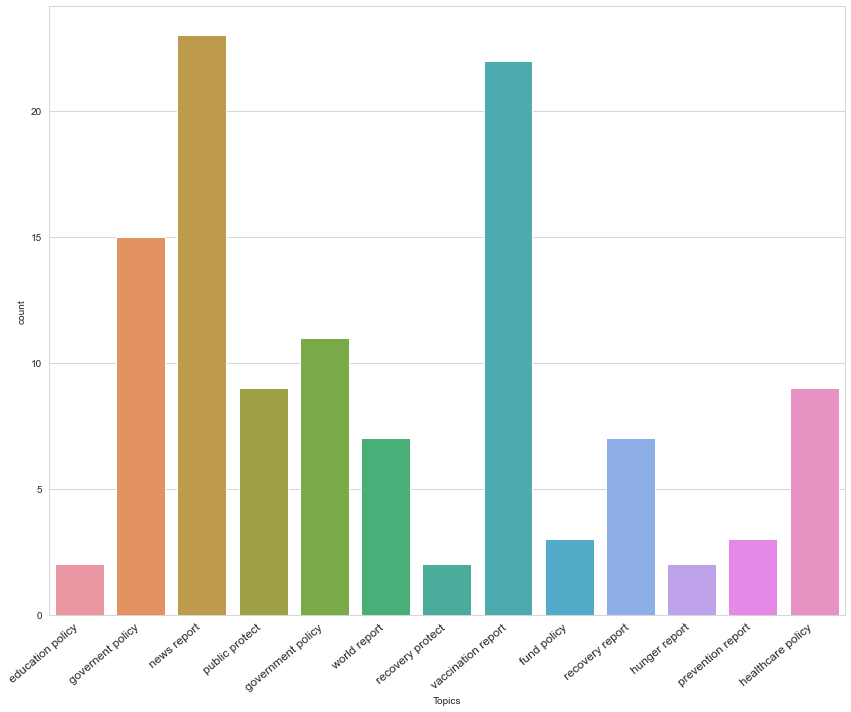

In [180]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 10))
ax = sns.countplot(x='Topics', data=dat_government)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

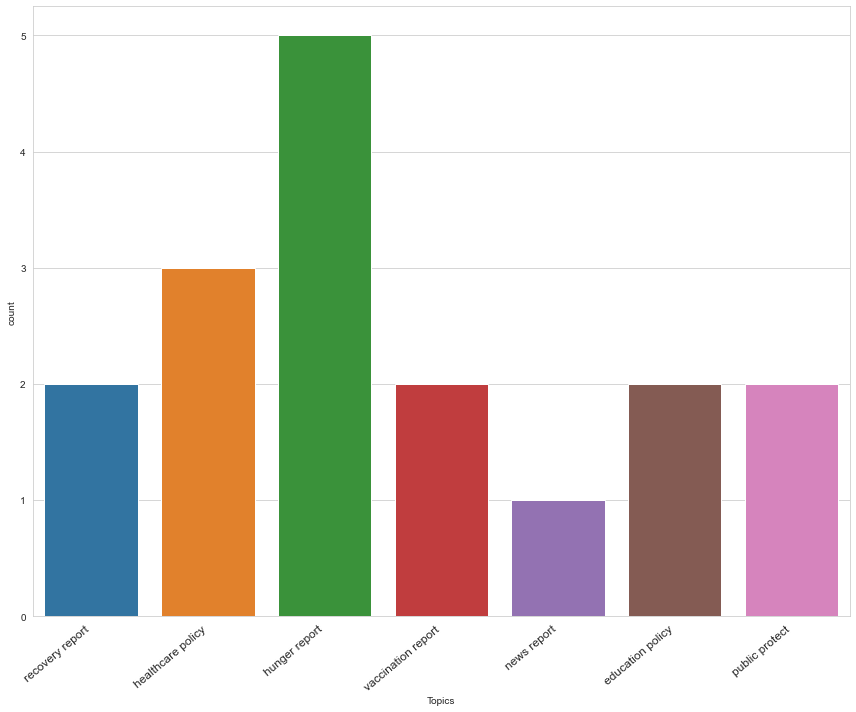

In [188]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 10))
ax = sns.countplot(x='Topics', data=dat_hunger)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

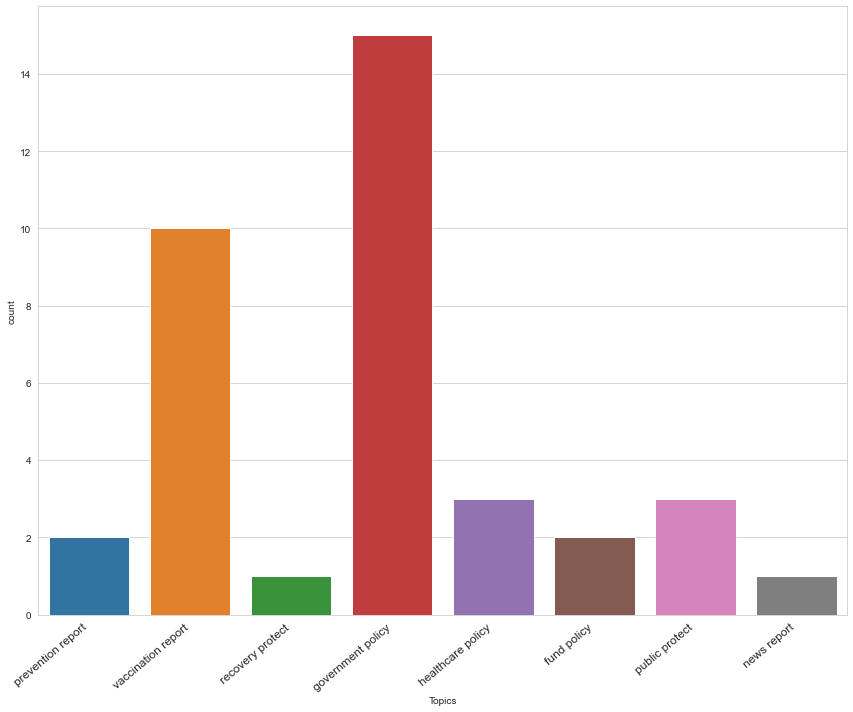

In [244]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 10))
ax = sns.countplot(x='Topics', data=dat_poverty)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

In [245]:
tt

NameError: name 'tt' is not defined

In [246]:
dat_security.to_csv("C:/Users/HARYS/OneDrive/Documents/senego/facebook/facebookthree/facebooktopics/securitytwitter.csv", index=False)
dat_media.to_csv("C:/Users/HARYS/OneDrive/Documents/senego/facebook/facebookthree/facebooktopics/mediatwitter.csv", index=False)
dat_business.to_csv("C:/Users/HARYS/OneDrive/Documents/senego/facebook/facebookthree/facebooktopics/businesstwitter.csv", index=False)
dat_pharmacy.to_csv("C:/Users/HARYS/OneDrive/Documents/senego/facebook/facebookthree/facebooktopics/pharmacytwitter.csv", index=False)


In [247]:
dat_education.to_csv("C:/Users/HARYS/OneDrive/Documents/senego/facebook/facebookthree/facebooktopics/educationtwitter.csv", index=False)

In [248]:
dat_transport.to_csv("C:/Users/HARYS/OneDrive/Documents/senego/facebook/facebookthree/facebooktopics/transporttwitter.csv", index=False)

In [249]:
dat_government.to_csv("C:/Users/HARYS/OneDrive/Documents/senego/facebook/facebookthree/facebooktopics/governmenttwitter.csv", index=False)


In [250]:
dat_poverty.to_csv("C:/Users/HARYS/OneDrive/Documents/senego/facebook/facebookthree/facebooktopics/povertytwitter.csv", index=False)

In [193]:
dat_hunger.to_csv("C:/Users/HARYS/OneDrive/Documents/senego/facebook/facebookthree/facebooktopics/hungertwitter.csv", index=False)

In [137]:
datastudy = pd.read_csv("C:/Users/HARYS/OneDrive/Documents/senego/facebook/facebookthree/facebooktopics/samplelast.csv", encoding = "UTF-8")
#datastudy.dropna()
datastudy.head(2)

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/HARYS/OneDrive/Documents/senego/facebook/facebookthree/facebooktopics/samplelast.csv'

In [ ]:
#datastudy.head(2)

In [ ]:
#Piechart visualisation
plt.pie(datastudy['impact'].value_counts(),labels=datastudy['impact'].unique(),autopct='%1.2f%%')
#plt.figure(figsize=(12, 10))
plt.show()

In [ ]:
datastudy2 = pd.read_csv("C:/Users/harys/Downloads/covid3/covid/twitter/sampleone.csv", encoding = "UTF-8")
#datastudy.dropna()
datastudy2.head(2)

In [ ]:
#Piechart visualisation
plt.pie(datastudy2['impact'].value_counts(),labels=datastudy2['impact'].unique(),autopct='%1.2f%%')
#plt.figure(figsize=(10, 8))
plt.show()

In [ ]:
datastudy3 = pd.read_csv("C:/Users/harys/Downloads/covid3/covid/twitter/sampleoneall.csv", encoding = "UTF-8")
#datastudy.dropna()
datastudy3.head(2)

In [ ]:
#Piechart visualisation
plt.pie(datastudy3['impact'].value_counts(),labels=datastudy3['impact'].unique(),autopct='%1.2f%%')
#plt.figure(figsize=(10, 8))
plt.show()

In [ ]:
datastudy4 = pd.read_csv("C:/Users/harys/Downloads/covid3/covid/twitter/sampleone.csv", encoding = "UTF-8")
#datastudy.dropna()
datastudy4.head(2)

In [ ]:
#Piechart visualisation
plt.pie(datastudy4['impact'].value_counts(),labels=datastudy4['impact'].unique(),autopct='%1.2f%%')
#plt.figure(figsize=(10, 8))
plt.show()

In [ ]:
dat_health = dat_merge[dat_merge['Review_Keywords'].str.contains(r'health')]
dat_death = dat_merge[dat_merge['Review_Keywords'].str.contains(r'death')]
dat_spread = dat_merge[dat_merge['Review_Keywords'].str.contains(r'spread')]
dat_virus = dat_merge[dat_merge['Review_Keywords'].str.contains(r'virus')]
dat_mask = dat_merge[dat_merge['Review_Keywords'].str.contains(r'mask')]
dat_live = dat_merge[dat_merge['Review_Keywords'].str.contains(r'live')]
dat_people = dat_merge[dat_merge['Review_Keywords'].str.contains(r'people')]

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 10))
ax = sns.countplot(x='Review_Keywords', data=dat_health)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 10))
ax = sns.countplot(x='Review_Keywords', data=dat_people)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 10))
ax = sns.countplot(x='Review_Keywords', data=dat_spread)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 10))
ax = sns.countplot(x='Review_Keywords', data=dat_virus)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 10))
ax = sns.countplot(x='Review_Keywords', data=dat_mask)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 10))
ax = sns.countplot(x='Review_Keywords', data=dat_live)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 10))
ax = sns.countplot(x='Review_Keywords', data=dat_people)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

In [ ]:
dat_vaccine = dat_merge[dat_merge['Review_Keywords'].str.contains(r'vaccine')]
dat_test = dat_merge[dat_merge['Review_Keywords'].str.contains(r'test')]
dat_face = dat_merge[dat_merge['Review_Keywords'].str.contains(r'face')]

dat_poverty = dat_merge[dat_merge['Review_Keywords'].str.contains(r'poverty')]
dat_hunger = dat_merge[dat_merge['Review_Keywords'].str.contains(r'hunger')]
dat_country = dat_merge[dat_merge['Review_Keywords'].str.contains(r'country')]
dat_government = dat_merge[dat_merge['Review_Keywords'].str.contains(r'government')]
dat_spread = dat_merge[dat_merge['Review_Keywords'].str.contains(r'spread')]
dat_public = dat_merge[dat_merge['Review_Keywords'].str.contains(r'public')]

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 10))
ax = sns.countplot(x='Review_Keywords', data=dat_poverty)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 10))
ax = sns.countplot(x='Review_Keywords', data=dat_hunger)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 10))
ax = sns.countplot(x='Review_Keywords', data=dat_country)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 10))
ax = sns.countplot(x='Review_Keywords', data=dat_government)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 10))
ax = sns.countplot(x='Review_Keywords', data=dat_spread)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 10))
ax = sns.countplot(x='Review_Keywords', data=dat_public)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 10))
ax = sns.countplot(x='Review_Keywords', data=dat_vaccine)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 10))
ax = sns.countplot(x='Review_Keywords', data=dat_test)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 10))
ax = sns.countplot(x='Review_Keywords', data=dat_face)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

In [ ]:
from gensim import corpora
from gensim.models import LsiModel

In [ ]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(clean_brand_review)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(review) for review in clean_brand_review]
    # generate LDA model
    return dictionary,doc_term_matrix

In [ ]:
def create_gensim_lsa_model(clean_brand_review,number_of_topics,words): 
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(clean_brand_review)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [ ]:
def compute_coherence_values(dictionary, doc_term_matrix, clean_brand_review, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=clean_brand_review, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [ ]:
def plot_graph(clean_brand_review,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(clean_brand_review)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,clean_brand_review,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
start,stop,step=2,12,1
number_of_topics=8
plot_graph(clean_brand_review,start,stop,step)

In [ ]:
# LSA Model
number_of_topics=8
words=10
#document_list,titles=load_data("","articles.txt")
#clean_text=preprocess_data(document_list)
model=create_gensim_lsa_model(clean_brand_review,number_of_topics,words)

In [ ]:
# Define the sentence topics
def sentence_topics(lsamodel=lsamodel, corpus=corpus_1, texts=clean_brand_review):
    # Init output
    topics_df = pd.DataFrame()

    # Looping through the documents to find the main topics
    for i, row in enumerate(lsamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        
        # look for the Dominant topic, % contribution and Keywords 
        for j, (topic_num, prop_topic) in enumerate(row):
            
            # Diplay the dominant topics
            if j == 0:  
                dom = lsamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in dom])
                topics_df = topics_df.append(pd.Series([int(topic_num), round(prop_topic,2)*100, topic_keywords]), ignore_index=True)
            else:
                break
    topics_df.columns = ['Dominant_Review_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Concatenate the text and the topics_df
    contents = pd.Series(texts)
    topics_df = pd.concat([topics_df, contents], axis=1)
    return(topics_df)


df_topic_sents_keywords = sentence_topics(lsamodel=lsamodel, corpus=corpus_1, texts=clean_brand_review)

# Format
dominant_review_topic = df_topic_sents_keywords.reset_index()
dominant_review_topic.columns = ['Review_No', 'Dominant_Review_Topic', 'Percent_contr_per_topic', 'Review_Keywords', 'Original review']

# Show
dominant_review_topic.head(10)

### Topic modelling of each keyword

The previous LDA model that I ran was for the reviews of all the keywords. Here I want to understand and visualize 6 topics in each keyword. This could help to understand the discussion in the review of each keyword.

In [ ]:
# saving the review of each brand in a DataFrame
poverty_df = ([sent for sent in dataset.loc[dataset['Product'] == 'poverty', 'ConsumerComplaint']])
hunger_df = ([sent for sent in dataset.loc[dataset['Product'] == 'hunger', 'ConsumerComplaint']])
covid_df = ([sent for sent in dataset.loc[dataset['Product'] == 'covid', 'ConsumerComplaint']])


In [ ]:
%%time

# Defining a function to get the topics and visualize them 
def each_brand(text):

    # Create Dictionary
    id2word_2 = corpora.Dictionary(text)

    # Create Corpus: Term Document Frequency
    corpus_2 = [id2word_2.doc2bow(ConsumerComplaint) for ConsumerComplaint in text]
    
    # Here I decided to reduce the number of topics to only six for each brand
    model2 = LdaMulticore(corpus=corpus_2, num_topics = 6, id2word=id2word_2,chunksize=2000, passes=80,per_word_topics=True)
    
    
    LDAvis_prepared = pyLDAvis.gensim.prepare(model, corpus=corpus_2, dictionary=id2word_2,sort_topics=False)

    return LDAvis_prepared
    #ldamodel2 = LdaMulticore(corpus= corpus_1, num_topics =8, id2word=id2word_1,chunksize=2000, passes=50,per_word_topics=True)

In [ ]:
# Fitting the LDA model on each brand to visual the topics
poverty_lda = each_brand(poverty_df)
covid_lda = each_brand(covid_df)
hunger_lda = each_brand(hunger_df)


In [ ]:
from pprint import pprint

pprint(LdaMulticore.show_topics(formatted=False))

Output:
Lower the perplexity better the model.
Higher the topic coherence, the topic is more human interpretable.

# Feature selection
Different ways to view features 

In [ ]:
import string
import collections
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.cm as cm
import matplotlib.pyplot as plt


In [ ]:
text = " ".join(review for review in dataset.ConsumerComplaint)
wordcloud = WordCloud().generate(text)
wordcloud = WordCloud(background_color = 'lightcyan', width = 900, height = 900).generate(text)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
hunger_text = " ".join(review for review in dataset['ConsumerComplaint'][dataset['Product']=='hunger'])# you replace the word hunger with poverty

wordcloud = WordCloud(background_color = 'lightcyan', width = 900, height = 900).generate(hunger_text)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
hunger_text = " ".join(review for review in dataset['ConsumerComplaint'][dataset['Product']=='poverty'])# you replace the word hunger with poverty

wordcloud = WordCloud(background_color = 'lightcyan', width = 900, height = 900).generate(hunger_text)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
hunger_text = " ".join(review for review in dataset['ConsumerComplaint'][dataset['Product']=='covid'])# you replace the word hunger with poverty

wordcloud = WordCloud(background_color = 'lightcyan', width = 900, height = 900).generate(hunger_text)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Creating features by CountVectorizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
#excluding ‘community’ and ‘tribe’ from the analysis by adding to the existing list of stop words
cv = CountVectorizer(stop_words = text.ENGLISH_STOP_WORDS.union(["say","must"]))
dataset.ConsumerComplaint = dataset.ConsumerComplaint.astype(str)
words = cv.fit_transform(dataset['ConsumerComplaint'][dataset['Product']=='poverty'])
sum_words = words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])
frequency.head(20)
#plt.style.use('fivethirtyeight')
#color = plt.cm.gist_earth(np.linspace(0, 1, 25))
#frequency.head(20).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color = color)
#plt.title("Most Frequently Words in Questions - Top 20")
#plt.xlabel('Word')
#plt.ylabel('Frequency'

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
#excluding ‘community’ and ‘tribe’ from the analysis by adding to the existing list of stop words
cv = CountVectorizer(stop_words = text.ENGLISH_STOP_WORDS.union(["say","must"]))
dataset.ConsumerComplaint = dataset.ConsumerComplaint.astype(str)
words = cv.fit_transform(dataset['ConsumerComplaint'][dataset['Product']=='covid'])
sum_words = words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])
frequency.head(10)
#plt.style.use('fivethirtyeight')
#color = plt.cm.gist_earth(np.linspace(0, 1, 25))
#frequency.head(20).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color = color)
#plt.title("Most Frequently Words in Questions - Top 20")
#plt.xlabel('Word')
#plt.ylabel('Frequency'

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
#excluding ‘community’ and ‘tribe’ from the analysis by adding to the existing list of stop words
cv = CountVectorizer(stop_words = text.ENGLISH_STOP_WORDS.union(["say","must"]))
dataset.ConsumerComplaint = dataset.ConsumerComplaint.astype(str)
words = cv.fit_transform(dataset['ConsumerComplaint'][dataset['Product']=='hunger'])
sum_words = words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])
frequency.head(20)
#plt.style.use('fivethirtyeight')
#color = plt.cm.gist_earth(np.linspace(0, 1, 25))
#frequency.head(20).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color = color)
#plt.title("Most Frequently Words in Questions - Top 20")
#plt.xlabel('Word')
#plt.ylabel('Frequency'

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
#excluding ‘community’ and ‘tribe’ from the analysis by adding to the existing list of stop words
cv = CountVectorizer(stop_words = text.ENGLISH_STOP_WORDS.union(["say","must"]))
dataset.ConsumerComplaint = dataset.ConsumerComplaint.astype(str)
words = cv.fit_transform(dataset['ConsumerComplaint'][dataset['Product']=='poverty'])
sum_words = words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])
plt.style.use('fivethirtyeight')
color = plt.cm.gist_earth(np.linspace(0, 1, 25))
frequency.head(20).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color = color)
plt.title("Most Frequently Words in Questions - Top 20")
plt.xlabel('Word')
plt.ylabel('Frequency')

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
#excluding ‘community’ and ‘tribe’ from the analysis by adding to the existing list of stop words
cv = CountVectorizer(stop_words = text.ENGLISH_STOP_WORDS.union(["say","must"]))
dataset.ConsumerComplaint = dataset.ConsumerComplaint.astype(str)
words = cv.fit_transform(dataset['ConsumerComplaint'][dataset['Product']=='covid'])
sum_words = words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])
plt.style.use('fivethirtyeight')
color = plt.cm.gist_earth(np.linspace(0, 1, 25))
frequency.head(20).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color = color)
plt.title("Most Frequently Words in Questions - Top 20")
plt.xlabel('Word')
plt.ylabel('Frequency')

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
#excluding ‘community’ and ‘tribe’ from the analysis by adding to the existing list of stop words
cv = CountVectorizer(stop_words = text.ENGLISH_STOP_WORDS.union(["say","must"]))
dataset.ConsumerComplaint = dataset.ConsumerComplaint.astype(str)
words = cv.fit_transform(dataset['ConsumerComplaint'][dataset['Product']=='hunger'])
sum_words = words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])
plt.style.use('fivethirtyeight')
color = plt.cm.gist_earth(np.linspace(0, 1, 25))
frequency.head(20).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color = color)
plt.title("Most Frequently Words in Questions - Top 20")
plt.xlabel('Word')
plt.ylabel('Frequency')

In [ ]:
def get_top_n_bigram(dataset, n=None):

  vec = CountVectorizer(ngram_range=(2, 2), stop_words=text.ENGLISH_STOP_WORDS.union(["want","go"])).fit(dataset)

  bag_of_words = vec.transform(dataset)
  sum_words = bag_of_words.sum(axis=0)
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  return words_freq[:n]

common_words = get_top_n_bigram(dataset['ConsumerComplaint'][dataset['Product']=='poverty'])
df_b = pd.DataFrame(common_words, columns = ['bigrams' , 'count'])
df_b.head(10)


In [ ]:
def get_top_n_bigram(dataset, n=None):

  vec = CountVectorizer(ngram_range=(2, 2), stop_words=text.ENGLISH_STOP_WORDS.union(["want","go"])).fit(dataset)

  bag_of_words = vec.transform(dataset)
  sum_words = bag_of_words.sum(axis=0)
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  return words_freq[:n]

common_words = get_top_n_bigram(dataset['ConsumerComplaint'][dataset['Product']=='covid'])
df_b = pd.DataFrame(common_words, columns = ['bigrams' , 'count'])
df_b.head(10)

In [ ]:
def get_top_n_bigram(dataset, n=None):

  vec = CountVectorizer(ngram_range=(2, 2), stop_words=text.ENGLISH_STOP_WORDS.union(["want","go"])).fit(dataset)

  bag_of_words = vec.transform(dataset)
  sum_words = bag_of_words.sum(axis=0)
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  return words_freq[:n]

common_words = get_top_n_bigram(dataset['ConsumerComplaint'][dataset['Product']=='hunger'])
df_b = pd.DataFrame(common_words, columns = ['bigrams' , 'count'])
df_b.head(10)

Creating features by TF-IDF method

In [ ]:
# Create a new column 'label_id' with encoded categories 
dataset['label_id'] = dataset['Product'].factorize()[0]
new_df = dataset[['Product', 'label_id']].drop_duplicates()
# Dictionaries for future use
category_to_id = dict(new_df.values)
id_to_category = dict(new_df[['label_id', 'Product']].values)
# New dataframe


In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')
# We transform each news data into a vector
features = tfidf.fit_transform(dataset.ConsumerComplaint).toarray()
labels = dataset.label_id
print("Each of the %d news data is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

In [ ]:
N = 10
for Category, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> ", (Category), ":")
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))

# Data mining 

# Using TF-IDF method of feature engineering

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.feature_extraction.text as text
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn import metrics

from textblob import TextBlob
from nltk.stem import PorterStemmer,SnowballStemmer
from textblob import Word
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize.toktok import ToktokTokenizer

from io import StringIO
import os
import string
import gensim
from gensim.models import Word2Vec
import itertools
import scipy
from scipy import spatial
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')  

In [ ]:
#Slipliting the dataset
train_x, valid_x, train_y, valid_y, indices_train, indices_test= train_test_split(dataset['ConsumerComplaint'], dataset['Product'],dataset.index,stratify=dataset['Product'], 
                                                    test_size=0.25)

In [ ]:
##tf-idf verctor representation
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(dataset['ConsumerComplaint'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

In [ ]:
from sklearn.model_selection import GridSearchCV
clf = LogisticRegression()
lr_params = {'C':[int(x) for x in np.linspace(1,10,10)]}
grid_lr = GridSearchCV(estimator=clf,param_grid=lr_params,cv=5,n_jobs=-1)
grid_lr.fit(xtrain_tfidf,train_y)

In [ ]:
print(grid_lr.best_params_)
print(grid_lr.best_score_)

In [ ]:
final_lr = LogisticRegression(C=5)
final_lr.fit(xtrain_tfidf,train_y)

In [ ]:
final_lr_predict = final_lr.predict(xvalid_tfidf)
lr_accuracy = metrics.accuracy_score(final_lr_predict, valid_y)
print ("Logistic Regression > Accuracy: ", lr_accuracy)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(valid_y, final_lr_predict,target_names=dataset['Product'].unique()))

In [ ]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(valid_y, final_lr_predict)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="BuPu",xticklabels=dataset['Product'].unique(),yticklabels=dataset['Product'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
for predicted in new_df.label_id:
    for actual in new_df.label_id:
        if predicted != actual and conf_mat[actual, predicted] >=5:
            print("actual class '{}' predicted as '{}' : {} examples.".format(id_to_category[actual], 
                                                           id_to_category[predicted], 
                                                           conf_mat[actual, predicted]))
    
            display(dataset.loc[indices_test[(valid_y == actual) & (final_lr_predict == predicted)]][['Product', 
                                                                'ConsumerComplaint']])
            print('')

In [ ]:
from sklearn.svm import LinearSVC
svc_model = LinearSVC()

svc_model.fit(xtrain_tfidf,train_y)

In [ ]:
predict = svc_model.predict(xvalid_tfidf)
svc_accuracy = metrics.accuracy_score(predict, valid_y)
print ("SVC > Accuracy: ", svc_accuracy)

In [ ]:
print(classification_report(valid_y, predict,target_names=dataset['Product'].unique()))

In [ ]:
conf_mat = confusion_matrix(valid_y, predict)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="BuPu",xticklabels=dataset['Product'].unique(),yticklabels=dataset['Product'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
for predicted in new_df.label_id:
    for actual in new_df.label_id:
        if predicted != actual and conf_mat[actual, predicted] >=5:
            print("actual class '{}' predicted as '{}' : {} examples.".format(id_to_category[actual], 
                                                           id_to_category[predicted], 
                                                           conf_mat[actual, predicted]))
    
            display(dataset.loc[indices_test[(valid_y == actual) & (final_lr_predict == predicted)]][['Product', 
                                                                'ConsumerComplaint']])
            print('')


In [ ]:

from xgboost import XGBClassifier
xgb_model = XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, gamma=0, reg_alpha=4, eta=0.3, silent=1, subsample=0.8)
xgb_model.fit(xtrain_tfidf, train_y)

In [ ]:
xgb_predict = xgb_model.predict(xvalid_tfidf)
xgb_accuracy = metrics.accuracy_score(xgb_predict, valid_y)
print ("XGBoost > Accuracy: ", xgb_accuracy)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(valid_y, xgb_predict,target_names=dataset['Product'].unique()))

In [ ]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(valid_y, xgb_predict)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="BuPu",xticklabels=dataset['Product'].unique(),yticklabels=dataset['Product'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
for predicted in new_df.label_id:
    for actual in new_df.label_id:
        if predicted != actual and conf_mat[actual, predicted] >=5:
            print("actual class '{}' predicted as '{}' : {} examples.".format(id_to_category[actual], 
                                                           id_to_category[predicted], 
                                                           conf_mat[actual, predicted]))
    
            display(dataset.loc[indices_test[(valid_y == actual) & (final_lr_predict == predicted)]][['Product', 
                                                                'ConsumerComplaint']])
            print('')

In [ ]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()


In [ ]:
%time model.fit(xtrain_tfidf,train_y)

In [ ]:
predict = model.predict(xvalid_tfidf)
accuracy = metrics.accuracy_score(predict, valid_y)
print ("MNB > Accuracy: ", accuracy)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(valid_y, predict,target_names=dataset['Product'].unique()))

In [ ]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(valid_y, predict)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="BuPu",xticklabels=dataset['Product'].unique(),yticklabels=dataset['Product'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
for predicted in new_df.label_id:
    for actual in new_df.label_id:
        if predicted != actual and conf_mat[actual, predicted] >=5:
            print("actual class '{}' predicted as '{}' : {} examples.".format(id_to_category[actual], 
                                                           id_to_category[predicted], 
                                                           conf_mat[actual, predicted]))
    
            display(dataset.loc[indices_test[(valid_y == actual) & (final_lr_predict == predicted)]][['Product', 
                                                                'ConsumerComplaint']])
            print('')

In [ ]:
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
%time model.fit(xtrain_tfidf,train_y)


In [ ]:
predict = model.predict(xvalid_tfidf)
accuracy = metrics.accuracy_score(predict, valid_y)
print ("RF > Accuracy: ", accuracy)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(valid_y, predict,target_names=dataset['Product'].unique()))

In [ ]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(valid_y, predict)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="BuPu",xticklabels=dataset['Product'].unique(),yticklabels=dataset['Product'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
for predicted in new_df.label_id:
    for actual in new_df.label_id:
        if predicted != actual and conf_mat[actual, predicted] >=5:
            print("actual class '{}' predicted as '{}' : {} examples.".format(id_to_category[actual], 
                                                           id_to_category[predicted], 
                                                           conf_mat[actual, predicted]))
    
            display(dataset.loc[indices_test[(valid_y == actual) & (final_lr_predict == predicted)]][['Product', 
                                                                'ConsumerComplaint']])
            print('')

# DEEP LEARNING

One-hot encoding using custom models

Split the data into training and test sets

In [ ]:
complaints = dataset["ConsumerComplaint"].values
labels = dataset[["Product"]].values

X_train, y_train, X_test, y_test = train_test_split(complaints,labels, test_size = 0.20, random_state = 42)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

#Set Hyperparameters

In [ ]:
# The maximum number of words to be used. (most frequent)
vocab_size = 50000

# Dimension of the dense embedding.
embedding_dim = 128

# Max number of words in each complaint.
max_length = 200

# Truncate and padding options
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [ ]:
#tokenize text
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
dict(list(word_index.items())[0:10])

#padding sequence 
train_seq = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

#padding sequence
validation_seq = tokenizer.texts_to_sequences(y_train)
validation_padded = pad_sequences(validation_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print('Shape of data tensor:', train_padded.shape)
print('Shape of data tensor:', validation_padded.shape)

In [ ]:
encode = OneHotEncoder()

training_labels = encode.fit_transform(X_test)
validation_labels = encode.transform(y_test)

In [ ]:
print(train_padded.shape)
print(validation_labels.shape)
print(validation_padded.shape)
print(training_labels.shape)
print(type(train_padded))
print(type(validation_padded))
print(type(training_labels))
print(type(validation_labels))



# The labels must be converted to arrays
# Convert the labels to arrays
training_labels = training_labels.toarray()
validation_labels = validation_labels.toarray()

print(type(training_labels))
print(type(validation_labels))


 Build the Model

Using CNN neural network model

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]))


model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=3))
#model.add(LSTM(100))

model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 100
batch_size = 32

history = model.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    validation_split=0.2,
                    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001), 
                               EarlyStopping(monitor='val_loss', mode='min', patience=2, verbose=1),
                               EarlyStopping(monitor='val_accuracy', mode='max', patience=3, verbose=1)])

In [ ]:
#Plot the Model Loss and Accuracy for each epoch
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

Evaluating the model and make predictions 

In [ ]:
# First we create an evaluation function to output all the needs metrics

def evaluate_preds(y_true, y_preds):
    """
    Performs evaluation comparison on y_true labels vs. y_pred labels
    on a classification.
    """
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds, average='micro')
    recall = recall_score(y_true, y_preds, average='micro')
    f1 = f1_score(y_true, y_preds, average='micro')
    metric_dict = {"accuracy": round(accuracy, 2),
                   "precision": round(precision, 2),
                   "recall": round(recall, 2),
                   "f1": round(f1, 2)}
    print(f"Acc: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")
    
    return metric_dict

 Make Predictions

In [ ]:
# Now we make predictions using the test data to see how the model performs

predicted = model.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))

In [ ]:
#Create a Classification Report
import sklearn.metrics as metrics
print(metrics.classification_report(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1), 
                                    target_names=dataset['Product'].unique()))

In [ ]:
#Create a Confusion Matrix
conf_mat = confusion_matrix(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt="d",
            xticklabels=dataset.Product.unique(), yticklabels=dataset.Product.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Test model

In [ ]:
complaint = original_text[23]
new_complaint = [lemmatize_words(complaint)]
print(complaint)
print(new_complaint)
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
pred = model.predict(padded)
acc = model.predict_proba(padded)
predicted_label = encode.inverse_transform(pred)
print('')
print(f'Product category id: {np.argmax(pred[0])}')
print(f'Predicted label is: {predicted_label[0]}')
print(f'Accuracy score: { acc.max() * 100}')


Modal 2:
Using RNN (Bidirectional LSTM) neural network model

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]))


model.add(Bidirectional(LSTM(100)))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 100
batch_size = 32

history = model.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    validation_split=0.2,
                    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001), 
                               EarlyStopping(monitor='val_loss', mode='min', patience=2, verbose=1),
                               EarlyStopping(monitor='val_accuracy', mode='max', patience=3, verbose=1)])

 Plot the Model Loss and Accuracy for each epoch

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

#Evaluating the model and make predictions

In [ ]:
# First we create an evaluation function to output all the needs metrics

def evaluate_preds(y_true, y_preds):
    """
    Performs evaluation comparison on y_true labels vs. y_pred labels
    on a classification.
    """
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds, average='micro')
    recall = recall_score(y_true, y_preds, average='micro')
    f1 = f1_score(y_true, y_preds, average='micro')
    metric_dict = {"accuracy": round(accuracy, 2),
                   "precision": round(precision, 2),
                   "recall": round(recall, 2),
                   "f1": round(f1, 2)}
    print(f"Acc: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")
    
    return metric_dict

#Make Predictions

In [ ]:
# Now we make predictions using the test data to see how the model performs

predicted = model.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))

In [ ]:
#Create a Classification Report
import sklearn.metrics as metrics
print(metrics.classification_report(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1), 
                                    target_names=dataset['Product'].unique()))


In [ ]:
#Create a Confusion Matrix
conf_mat = confusion_matrix(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=dataset.Product.unique(), yticklabels=dataset.Product.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#Test model

In [ ]:
complaint = original_text[25]
new_complaint = [lemmatize_words(complaint)]
print(complaint)
print(new_complaint)
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
pred = model.predict(padded)
acc = model.predict_proba(padded)
predicted_label = encode.inverse_transform(pred)
print('')
print(f'Product category id: {np.argmax(pred[0])}')
print(f'Predicted label is: {predicted_label[0]}')
print(f'Accuracy score: { acc.max() * 100}')


# Deep learning by pre-trained words

Using pretrained word embeddings We start with Feature Engineering by transforming the same preprocessed data (list of lists of n-grams) given to the Word2Vec into a list of sequences using tensorflow/keras

We’ll use pre-trained embeddings such as Glove, Word2Vec which provides word based vector representation trained on a large data

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D, Conv1D, SimpleRNN
from keras.models import Model
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.layers import Dense, Input, Flatten, Dropout, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Sequential


In [ ]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('D:\dataset\glove.6B\glove.6B.300d.txt', encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

In [ ]:
complaints = dataset["ConsumerComplaint"].values
labels = dataset[["Product"]].values

X_train, y_train, X_test, y_test = train_test_split(complaints,labels, test_size = 0.20, random_state = 42)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

In [ ]:
##label encoding target variable
encode = OneHotEncoder()

training_labels = encode.fit_transform(X_test)
validation_labels = encode.transform(y_test)

In [ ]:
total_complaints = np.append(X_train,X_test)
#tokenizer = Tokenizer(num_words=25000)
#tokenizer.fit_on_texts(train_x.values)#total_complaints
#train_sequences = tokenizer.texts_to_sequences(train_x.values)
#test_sequences = tokenizer.texts_to_sequences(valid_x.values)

#tokenize text
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
dict(list(word_index.items())[0:10])

#padding sequence 
train_seq = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

#padding sequence
validation_seq = tokenizer.texts_to_sequences(y_train)
validation_padded = pad_sequences(validation_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print('Shape of data tensor:', train_padded.shape)
print('Shape of data tensor:', validation_padded.shape)

In [ ]:
word_index = tokenizer.word_index# dictionary containing words and their index
print('Found %s unique tokens.' % len(word_index))

In [ ]:
MAX_SEQUENCE_LENGTH = max([len(c.split()) for c in total_complaints])

In [ ]:
MAX_SEQUENCE_LENGTH

In [ ]:
EMBEDDING_DIM = 300
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
[(k,v) for k,v in word_index.items() if v==4]

In [ ]:
embedding_matrix[4]

In [ ]:
embedding_dim = 300
vocab_size = len(tokenizer.word_index)+1

In [ ]:
# Convert the labels to arrays
training_labels = training_labels.toarray()
validation_labels = validation_labels.toarray()

print(type(training_labels))
print(type(validation_labels))

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]))

model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=3))
#model.add(LSTM(100))

model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 100
batch_size = 32

history = model.fit(train_padded, training_labels,
 batch_size=64,
 epochs=8,
 validation_data=(validation_padded, validation_labels))

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [ ]:
# First we create an evaluation function to output all the needs metrics

def evaluate_preds(y_true, y_preds):
   
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds, average='micro')
    recall = recall_score(y_true, y_preds, average='micro')
    f1 = f1_score(y_true, y_preds, average='micro')
    metric_dict = {"accuracy": round(accuracy, 2),
                   "precision": round(precision, 2),
                   "recall": round(recall, 2),
                   "f1": round(f1, 2)}
    print(f"Acc: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")
    
    return metric_dict

In [ ]:
# Now we make predictions using the test data to see how the model performs

predicted = model.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))

In [ ]:
conf_mat = confusion_matrix(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=dataset.Product.unique(), yticklabels=dataset.Product.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
predicted=model.predict(validation_padded)
predicted

In [ ]:
import sklearn
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(validation_labels, predicted.round())
print('precision: \n{}'.format(precision))
print('recall: \n{}'.format(recall))
print('fscore: \n{}'.format(fscore))
print('support: \n{}'.format(support))

In [ ]:
import sklearn.metrics as metrics
print(metrics.classification_report(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1), 
                                    target_names=dataset['Product'].unique()))

In [ ]:
vocab_size = len(tokenizer.word_index)+1
EMBEDDING_DIM = 300
max_length = 394

In [ ]:
complaint = original_text[23]
new_complaint = [lemmatize_words(complaint)]
print(complaint)
print(new_complaint)
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
pred = model.predict(validation_padded)
#predicted=model.predict(test_data)
acc = model.predict_proba(validation_padded)
predicted_label = encode.inverse_transform(pred)
print('')
print(f'Product category id: {np.argmax(pred[0])}')
print(f'Predicted label is: {predicted_label[0]}')
print(f'Accuracy score: { acc.max() * 100}')


In [ ]:
#Using RNN (Bidirectional LSTM) neural network model
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]))


model.add(Bidirectional(LSTM(100)))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 100
batch_size = 32

history = model.fit(train_padded, training_labels,
 batch_size=64,
 epochs=8,
 validation_data=(validation_padded, validation_labels))


In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [ ]:
# First we create an evaluation function to output all the needs metrics

def evaluate_preds(y_true, y_preds):
  
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds, average='micro')
    recall = recall_score(y_true, y_preds, average='micro')
    f1 = f1_score(y_true, y_preds, average='micro')
    metric_dict = {"accuracy": round(accuracy, 2),
                   "precision": round(precision, 2),
                   "recall": round(recall, 2),
                   "f1": round(f1, 2)}
    print(f"Acc: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")
    
    return metric_dict

In [ ]:

predicted = model.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))

In [ ]:
import sklearn.metrics as metrics
print(metrics.classification_report(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1), 
                                    target_names=dataset['Product'].unique()))


In [ ]:
import sklearn
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(validation_labels, predicted.round())
print('precision: \n{}'.format(precision))
print('recall: \n{}'.format(recall))
print('fscore: \n{}'.format(fscore))
print('support: \n{}'.format(support))

In [ ]:
conf_mat = confusion_matrix(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=dataset.Product.unique(), yticklabels=dataset.Product.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
complaint = original_text[25]
new_complaint = [lemmatize_words(complaint)]
print(complaint)
print(new_complaint)
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
pred = model.predict(padded)
acc = model.predict_proba(padded)
predicted_label = encode.inverse_transform(pred)
print('')
print(f'Product category id: {np.argmax(pred[0])}')
print(f'Predicted label is: {predicted_label[0]}')
print(f'Accuracy score: { acc.max() * 100}')